# Numerically Solving Various Potential Functions applied to the Quantum Particle in a Box via the Shooting Method

## Introduction

Finding analytical solutions to the Schrödinger equation can become impractical for complex systems, such as asymmetric quantum wells used to model electrons in semiconductors or molecules with multiple interacting charged particles. Solutions are found by solving the Time-Independent Schrodinger Equation (TISE); the general TISE is given by:

\begin{align}
\hat{H}\psi(\mathbf{r}) = E\,\psi(\mathbf{r})
\end{align}

where:

$\hat{H}$ is the Hamiltonian operator, which depends on the physical system (e.g. single-particle systems are simpler than molecular wavefunctions), $\psi(\mathbf{r})$ is the wavefunction of the quantum system in three dimensions, and  $E$ is the eigen energies of the system.

To make problems analytically tractable, simplifying assumptions are introduced, such as the Born-Oppenheimer approximation (Rae & Napolitano, 2016), which separates electronic and nuclear motion in molecules. However, in many cases, numerical methods are necessary - which is the focus of this study.

A one-dimensional infinite potential well, which serves as a simple model for quantum dots is considered in the investigation. Quantum dots are nanometer-scale semiconductor structures that confine electrons, leading to discrete energy levels (McMillan, Batrakova & Gendelman, 2011). When an electron transitions between these levels, it emits photons of narrow spectral width (i.e. a very pure colour), thus making quantum dots valuable for applications in commercial use cases such as displays (Li et al., 2024) and medical imaging.

The Schrodinger Equation for a single particle in one-dimension is given by:

\begin{align}
-\frac{\hbar^2}{2m}\frac{\mathrm{d}^2 \psi(x)}{\mathrm{d}x^2} + V(x)\,\psi(x) = E\,\psi(x) 
\end{align}

where $\hbar$ is Planck's Constant divided by $2\pi$, $m$ is the mass of the particle, $V(x)$ is the potential energy function within the well, and $\psi(x)$ is the wavefunction in one dimension.

This study applies the Shooting Method to solve the TISE for various potential functions (four in total), which combines the Fourth-Order Runge-Kutta (RK4) method for initial-value problems and the Secant Method for root-finding (to satisfy boundary conditions).

## Method
### Shooting Method
The Shooting Method is a numerical approach used to solve boundary value problems (BVP) (Newman, 2013). Here, it is applied to enforce the boundary conditions of the electron wavefunction inside the potential well.

#### Fourth-Order Runge-Kutta Method

RK4 is a numerical integration technique for solving initial value problems involving systems of first-order differential equations. The Schrödinger equation can be rewritten as two first-order differential equations:
\begin{align}
\frac{\mathrm{d}\psi}{dt} &= \phi = f(\psi), \\ 
\frac{\mathrm{d} \phi}{dt} &= \frac{2m}{\hbar^2}\left [V(x) - E \right]\psi(x) = f(\phi) \\
\implies \mathbf{f} = \begin{pmatrix} 
f_{\psi} \\ 
f_{\phi}
\end{pmatrix} &= \begin{pmatrix}
\phi \\
\frac{2m}{\hbar^2}\left [V(x) - E \right]\psi(x)
\end{pmatrix}
\end{align}
RK4 is utilised to compute $\psi(x)$ numerically, starting from an initial condition where the wavefunction is zero at one boundary. The initial choice of $\psi(x)$ affects the amplitude and sign of the wavefunction (of lesser importance since the wavefunction will be normalised).

#### Secant Method

The Secant Method is an iterative algorithm used to find the eigen energies that satisfy the boundary conditions. In the infinite square well, the wavefunction must be zero at both boundaries. The problem of finding energy eigenvalues can therefore be transmuted into a root-finding problem, where we search for values of $E$ that ensure:
\begin{align}
\psi_{x=d/2}(E) = 0
\end{align}

where $\psi_{x=d/2}(E)$ is the final point of the wavefunction as a function of energy, $E$, and the energies which satisfy (6) are the eigen energies of the TISE.

To apply the Secant Method, two initial energy estimates are required. If these estimates are too far from the actual eigenvalues, the method may either fail to converge or find an excited-state energy instead of the ground state. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.special import eval_hermite

In [4]:
#Defining constants to be used throughout the notebook
#mass of electron (kg)
m_e = 9.109383702e-31
#Placks's Constant/2pi (Js)
h_bar = 1.054571817e-34 
#charge of the electron (C)
e = 1.602176634e-19 
#width of the well (m)
d = 5e-9 
#Height of the harmonic potential
V0_harmonic = 20*e
#finite square well potential
V0_finite = 10*e

#Defining array of points for the well's spatial domain
N = 2000
#spatial increment between each point, h
h = d/N 
xpoints = np.linspace(-d/2, d/2, N)

In [5]:
def V_infinite(x):
    """Potential for the infinite square well within the width of the well (from -d/2 < x < d/2).
    Takes a single point, x within the well and calculates the potential at that point; in this
    case, the potential is 0 everywhere in the well."""
    return 0.0

def V_harmonic(x):
    """Harmonic potential defined within the domain -d/2 < x < d/2, while the potential is infinite otherwise.
    Takes a single point, x within the well and calculates the potential at that point; in this
    case, the potential is the harmonic potential given in equation (). """
    return V0_harmonic*((x**2)/((d/2)**2))

def V_finite(x):
    """Finite square well potential as per equation ().
    Takes a value, x and returns zero potential if x is within the well, and a specified V0_finite
    if the point is outside the well."""
    if abs(x) <= d/4:
        return 0.0
    else:
        return V0_finite

In [6]:
def f_tise(r,x,V, E):
    """Vector function of the two 1st order ODEs as seen in equation ().
    Inputs:
        r (array) - initial values of psi and phi
        x (float) - point within the width of the well 
        V (function) - the potential function that describes the well
        E (float) - guess of the energy which would solve the BVP where psi(d/2) = 0
        
    Outputs an array of values for each function, f_psi and f_phi."""

    #extracting initia values for psi and phi from r
    psi = r[0]
    phi = r[1]

    #calculating values for the vector function 
    f_psi = phi
    f_phi = ( (2*m_e)/(h_bar**2) ) * (V(x) - E)*psi

    return np.array([f_psi, f_phi])

In [7]:
def RungeKutta(r, xpoints, V, f, E):
    """Fourth-order Runge-Kutta written for the TISE vector function as in equation ().
    Inputs: 
        r (array) - initial values of psi and phi
        xpoints (array) - holds all points within the width of the well 
        V (function) - the potential function that describes the well
        f (function) - the vector function in equation ()
        E (float) - guess of the energy which would solve the BVP where psi(d/2) = 0
        
    Outputs an array of values ([psi_points, phi_points]) for the wavefunction, psi, and its derivative, phi."""

    #lists to hold the approximated values at each point in the spatial domain of the well
    psi_points = []
    phi_points = []
    
    h = xpoints[1] - xpoints[0]

    #iterate over each value in the spatial domain to calculate the next
    #then appending the approximated values to psi/phi_points lists
    for x in xpoints:
        psi_points.append(r[0])
        phi_points.append(r[1])
        #Apply RungeKutta formula
        k1 = h*f(r, x, V, E)
        k2 = h*f(r+k1/2, x+h/2, V, E)         
        k3 = h*f(r+k2/2, x+h/2, V, E)
        k4 = h*f(r+k3, x+h, V, E)
        r = r + (k1 + 2*k2 + 2*k3 + k4)/6
        
    psi_points.append(r[0])
    phi_points.append(r[1])
    return np.array([psi_points, phi_points])

In [8]:
def secant_method(r, xpoints, V, f, E, tolerance):
    """Function implements the Secant Method to solve BVPs, written to solve for the eigen energies for the TISE wavefunctions.
    Inputs:
        r (array) - initial values of psi and phi
        xpoints (array) - holds all points within the width of the well 
        V (function) - the potential function that describes the well
        f (function) - the vector function in equation ()
        E (array) - two guess values of the energy which would solve the BVP where psi(d/2) = 0
        
    Outputs the eigenenergy, E3, and the solved wavefunction values at the corresponding x points."""
    #extract energies from the E array
    E1 = E[0]
    E2 = E[1]
    #calculate the final value of the wavefunction at x = d/2
    psi_final_1 = RungeKutta(r, xpoints, V, f, E1)[0][-1]
    psi_final_2 = RungeKutta(r, xpoints, V, f, E2)[0][-1]
    
    #If the values of E1 and E2 are not yet converged, repeat
    while abs(E2-E1) > tolerance:
        E3 = E2 - psi_final_2 * (E2 - E1)/(psi_final_2 - psi_final_1)
        
        #Updating the energy values to be reiterated
        E1 = E2
        E2 = E3
        
        #Recalculate the wavefunction and extract the final value again until tolerance is reached
        psi_final_1 = RungeKutta(r, xpoints, V, f, E1)[0][-1]
        psi_final_2 = RungeKutta(r, xpoints, V, f, E2)[0][-1]

    return E3, RungeKutta(r, xpoints, V, f, E3)

In [9]:
def integrate(y, h):
    """Implements the trapezoidal rule for numerical integration.
    Inputs:
        y (array) - the value of the function y(x) evaluated at each x point (spaced in intervals of h)
        h (float) - the width of the interval/height of the trapezium
        
    Outputs the area from the start of the array to the end."""
    return h*(0.5*y[0] + 0.5*y[-1] + np.sum(y[1:-1]))

In order to normalise the numerical wavefunctions, a numerical integration technique (trapezoidal integration) is implemented in the integrate function. As such, the square of the numerical wavefunction is calculated, and the numerical wavefunction is divided by the square root of the integral to procure the normalised numerical wavefunction.

## Wavefunctions of the Infinite Square Well

The infinite square well will first be considered in order to validate the quality of our numerical solutions. The infinite square well describes a particle confined to a width $d$ (centered about $x=0$), experiencing zero potential inside and an infinite potential at the boundaries and outside. The potential function is defined as:

\begin{align*}
V_{\mathrm{inf}}(x) &= \begin{cases} 
    0 & |x| \le \frac{d}{2} \\
    \infty & |x| > \frac{d}{2} \dots \ \dots \ \dots \ \dots \ \dots \ \dots (7)
   \end{cases}
\end{align*}

where the well extends from $\pm d/2$. The TISE within the region with zero potential is given by:

\begin{align*}
-\frac{\hbar^2}{2m}& \frac{\mathrm{d}^2 \psi(x)}{\mathrm{d}x^2} = E\,\psi(x), \ \ x \in \left [\frac{-d}{2}, \frac{d}{2} \right ]  \dots \ \dots \ \dots \ \dots \ \dots \ \dots (8)
\end{align*}

with boundary conditions:

Thus, we know the boundary conditions: 
\begin{align*}
\psi(-d/2) = \psi(d/2) = 0  \dots \ \dots \ \dots \ \dots \ \dots \ \dots (9)
\end{align*}

This may be solved analytically, and the normalised wavefunctions, $\psi_n (x)$, its derivative, $\phi_n(x)$ and the eigen energies, $E_n$ are given by:

\begin{align*}
\psi_n(x) = 
\begin{cases}
\displaystyle \frac{1}{\sqrt{d/2}} \cos\left(\frac{n\pi x}{d}\right), & n \text{ odd} \\
\displaystyle \frac{1}{\sqrt{d/2}} \sin\left(\frac{n\pi x}{d}\right), & n \text{ even}
\end{cases} \
\ \implies \phi_n = \frac{d\psi_n}{dx} = 
\begin{cases}
\displaystyle -\frac{n\pi}{d} \cdot \frac{1}{\sqrt{d/2}} \sin\left(\frac{n\pi x}{d}\right), & n \text{ odd} \\
\displaystyle \frac{n\pi}{d} \cdot \frac{1}{\sqrt{d/2}} \cos\left(\frac{n\pi x}{d}\right), & n \text{ even}
\end{cases}  \dots \ \dots \ \dots \ \dots \ \dots \ \dots &(10) \\
E_n = \frac{\pi^2 \hbar^2 n^2}{2 m d^2}, \ n = 1, 2, 3, \dots; \ \ \  \dots \ \dots \ \dots \ \dots \ \dots \ \dots \ \dots \ \dots \ \dots \ \dots \ \dots \ \dots \ \dots  \ \dots \ \dots \ \dots &(11) 
\end{align*}

Thus, the sign on the initial guessed value of $\phi$ may be ascertained through evaluating the analytic derivative at the start of the well. Furthermore, the analytic eigen energies may be determined and compared to with our numerical values with relative ease. This provides a reliable method of backtesting the numerical solutions procured.

## Efficiently Estimating a Guess Energy
In numerical approaches, estimating the correct eigen energies is crucial for solving the Schrodinger equation accurately. To approximate these eigenvalues, how the wavefunction behaves at the boundary as energy varies should be first investigated. Specifically, by plotting the final value of $\psi_{\mathrm{final}}(x)$ as a function of energy, we can identify points where $\psi(x)$ approaches zero, indicating possible eigenvalues.

A function may be implemented to systematically scan a specified energy range, evaluating the final value of $\psi(x)$ at each step. Energy values that bring $\psi(x)$ close to zero are recorded as initial ansatz guesses for the Secant Method. However, since this function iterates over discrete energy values and calls the Runge-Kutta Method (which involves a loop), the computational complexity scales as $\mathcal{O}(n^2)$. To reduce runtime, fewer discrete energy points must be used, trading off accuracy for efficiency in the initial estimation. By using this approach with numerical solvers, the desired wavefunctions and eigen energies may be determined accurately.

The function implemented specifically considers whether there is a change in sign between two points (i.e. where the function crosses the x-axis), and returns one of the two energy values at which this sign change occurs. It is noted, however, that the sign need not flip for the final point of the wavefunction to be zero (i.e. minima/maxima could occur, which still are eigen energies). Furthermore, discontinuities would also result in a sign change, though these energies are not eigen energies. Thus, this implemented function is not general, and new functions should be synthesised depending on the behaviour of the function.

In [10]:
def energy_guess(r, xpoints, f, V, E_range):
    """Function provides an array of energies which potentially solve the boundary condition (that the wave function is 0 at the last pointh)
    within a specified energy range; if there is no potential energy that satisfies the BVP, function returns 0.
    
    Inputs:
        r (array) - initial values of psi and phi
        xpoints (array) - holds all points within the desired domain (in meters) 
        V (function) - the potential function that describes the well
        f (function) - the vector function in equation ()
        E_range (array) - a range of energy values (in Joules) to be checked 
                    for potential eigen energies (to be passed as ansatz in further functions)
                    
    Outputs an array of potential eigen energies, and 0 if there is none within the specified range."""

    #array to store the eigen energies
    eigen_energy_guess_array = []
    psi_final = []

    #checks each energy relative to the previoufrs to see if there is a sign change in 
    #wavefunction value (indicating a crossing of the axis or a discontinuity)
    for i in range(len(E_range)-1):
        #temporary variables store the sign (+1, -1 or 0) of the previous and latter values of the energy range 
        tempvar1 = RungeKutta(r, xpoints, V, f, E_range[i])[0][-1]
        tempvar2 = RungeKutta(r, xpoints, V, f, E_range[i+1])[0][-1]
        #append the last point to the list
        psi_final.append(tempvar1)
        #check the sign of the last point of the wave function
        tempvar1 = np.sign(tempvar1)
        tempvar2 = np.sign(tempvar2)

        #check if the sum of the signs is equal to 0 (i.e. -1 + 1 => sign change)
        #then if True, append the ith index to the eigen energy array
        if int(abs(tempvar2 + tempvar1)) == 0:
            eigen_energy_guess_array.append(E_range[i])
            
    #append last point of last energy to psi_final list
    psi_final.append(RungeKutta(r, xpoints, V, f, E_range[-1])[0][-1])

    return eigen_energy_guess_array, psi_final

In [11]:
#Obtaining the first five eigen energy guesses (the range from 0.001e to 0.5e was arbitrarily chosen)
#25 points was chosen as the code ran fairly quickly; however the trade off is that the guessed values are less accurate
E_ansatz_inf, psi_inf_finalpts = energy_guess([0,1], xpoints, f_tise, V_infinite, np.linspace(0.001*e, 0.5*e, 25))
print(f"The eigen energy guesses for the first five eigen states of the infinite square well: {np.array(E_ansatz_inf)/e}eV")

The eigen energy guesses for the first five eigen states of the infinite square well: [0.001      0.04258333 0.12575    0.22970833 0.37525   ]eV


Text(0.5, 1.0, 'Final Point of the Numerical Wavefunction, $\\psi_{\\mathrm{final}}$ as a function of Energy \nfor the Infinite Square Well')

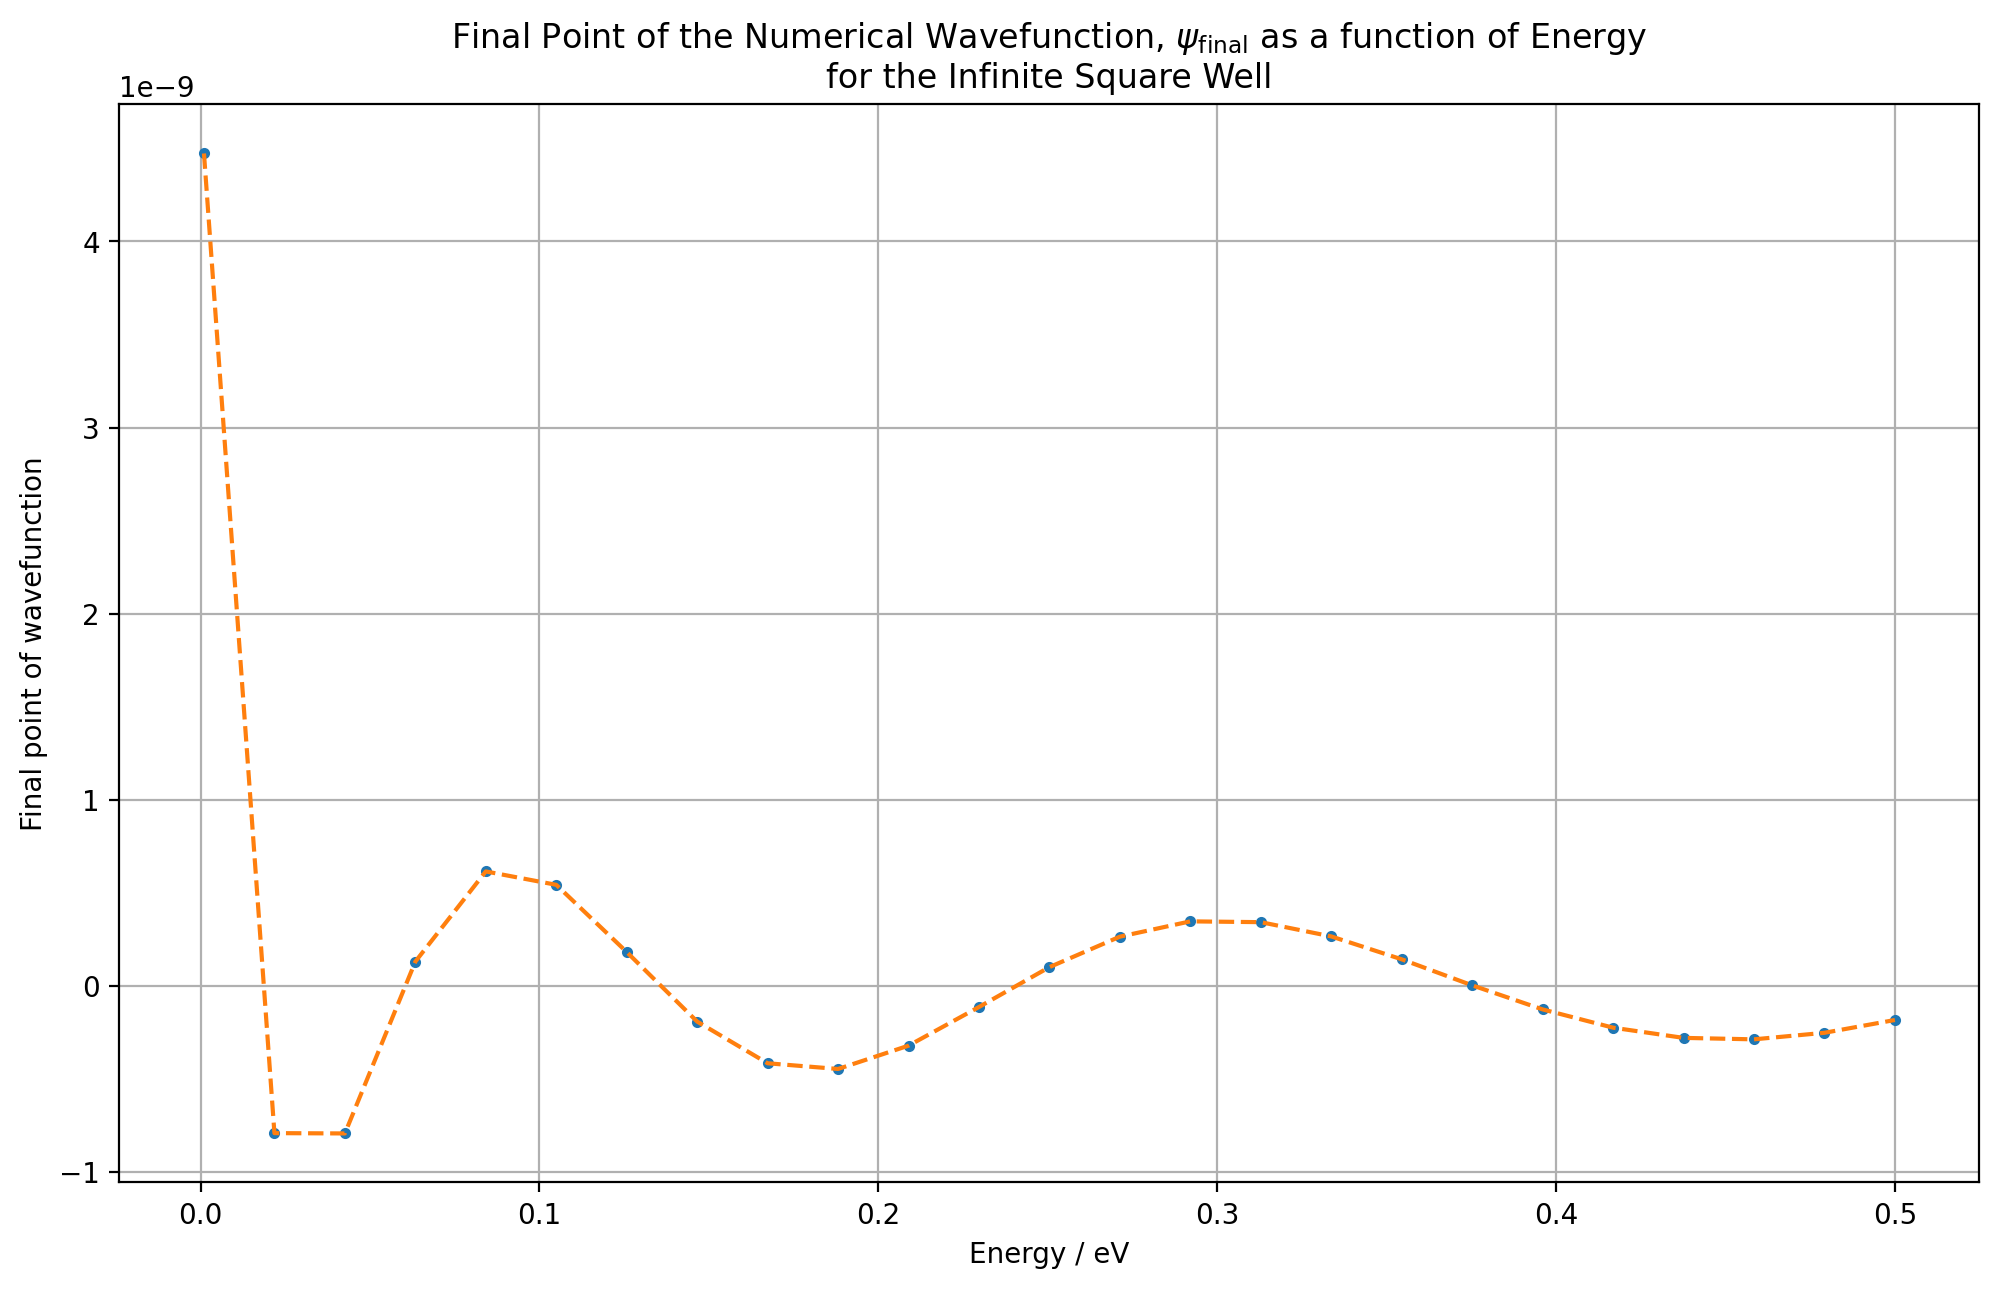

In [12]:
#Plotting the final point of the infinite square well wave function as a function of energy;
#the intersection points with the x-axis are the eigen energies of the infinite square well
plt.plot(np.linspace(0.001*e, 0.5*e, 25)/e, psi_inf_finalpts, '.')
plt.plot(np.linspace(0.001*e, 0.5*e, 25)/e, psi_inf_finalpts, '--')
plt.grid()
plt.xlabel("Energy / eV")
plt.ylabel("Final point of wavefunction")
plt.title("Final Point of the Numerical Wavefunction, $\psi_{\mathrm{final}}$ as a function of Energy \nfor the Infinite Square Well")

The final value of the wavefunction, $\psi_{\text{final}}$, is plotted as a function of energy, allowing for visualisation of the eigen energy distribution.; eigen energies correspond to the roots of this function, where $\psi_{\text{final}} \approx 0$.

From the plot, it is observed that as energy increases, the spacing between adjacent eigen energies widens. This agrees with the analytic solution, where eigen energies for the infinite square well scale as: $E_n \propto n^2$. Additionally, it is further noted that the higher energy eigenvalues are better approximated despite the relatively low number of discrete energy points used. This is due to the smoother curve of $\psi_{\text{final}}$ at higher energies, whereas the ground-state region exhibits more sharp changes.

These observations validate the choice of using a reduced number of energy points for estimating eigen energies for higher energy states of the infinite square well, as higher energy states yield reasonably accurate guesses for the Secant Method without requiring excessive computational resources.

Text(1.2e-09, 16000, 'Numerical Energy: 0.01503eV \nAnalytic Energy: 0.01504eV \nDifference: 2e-05eV')

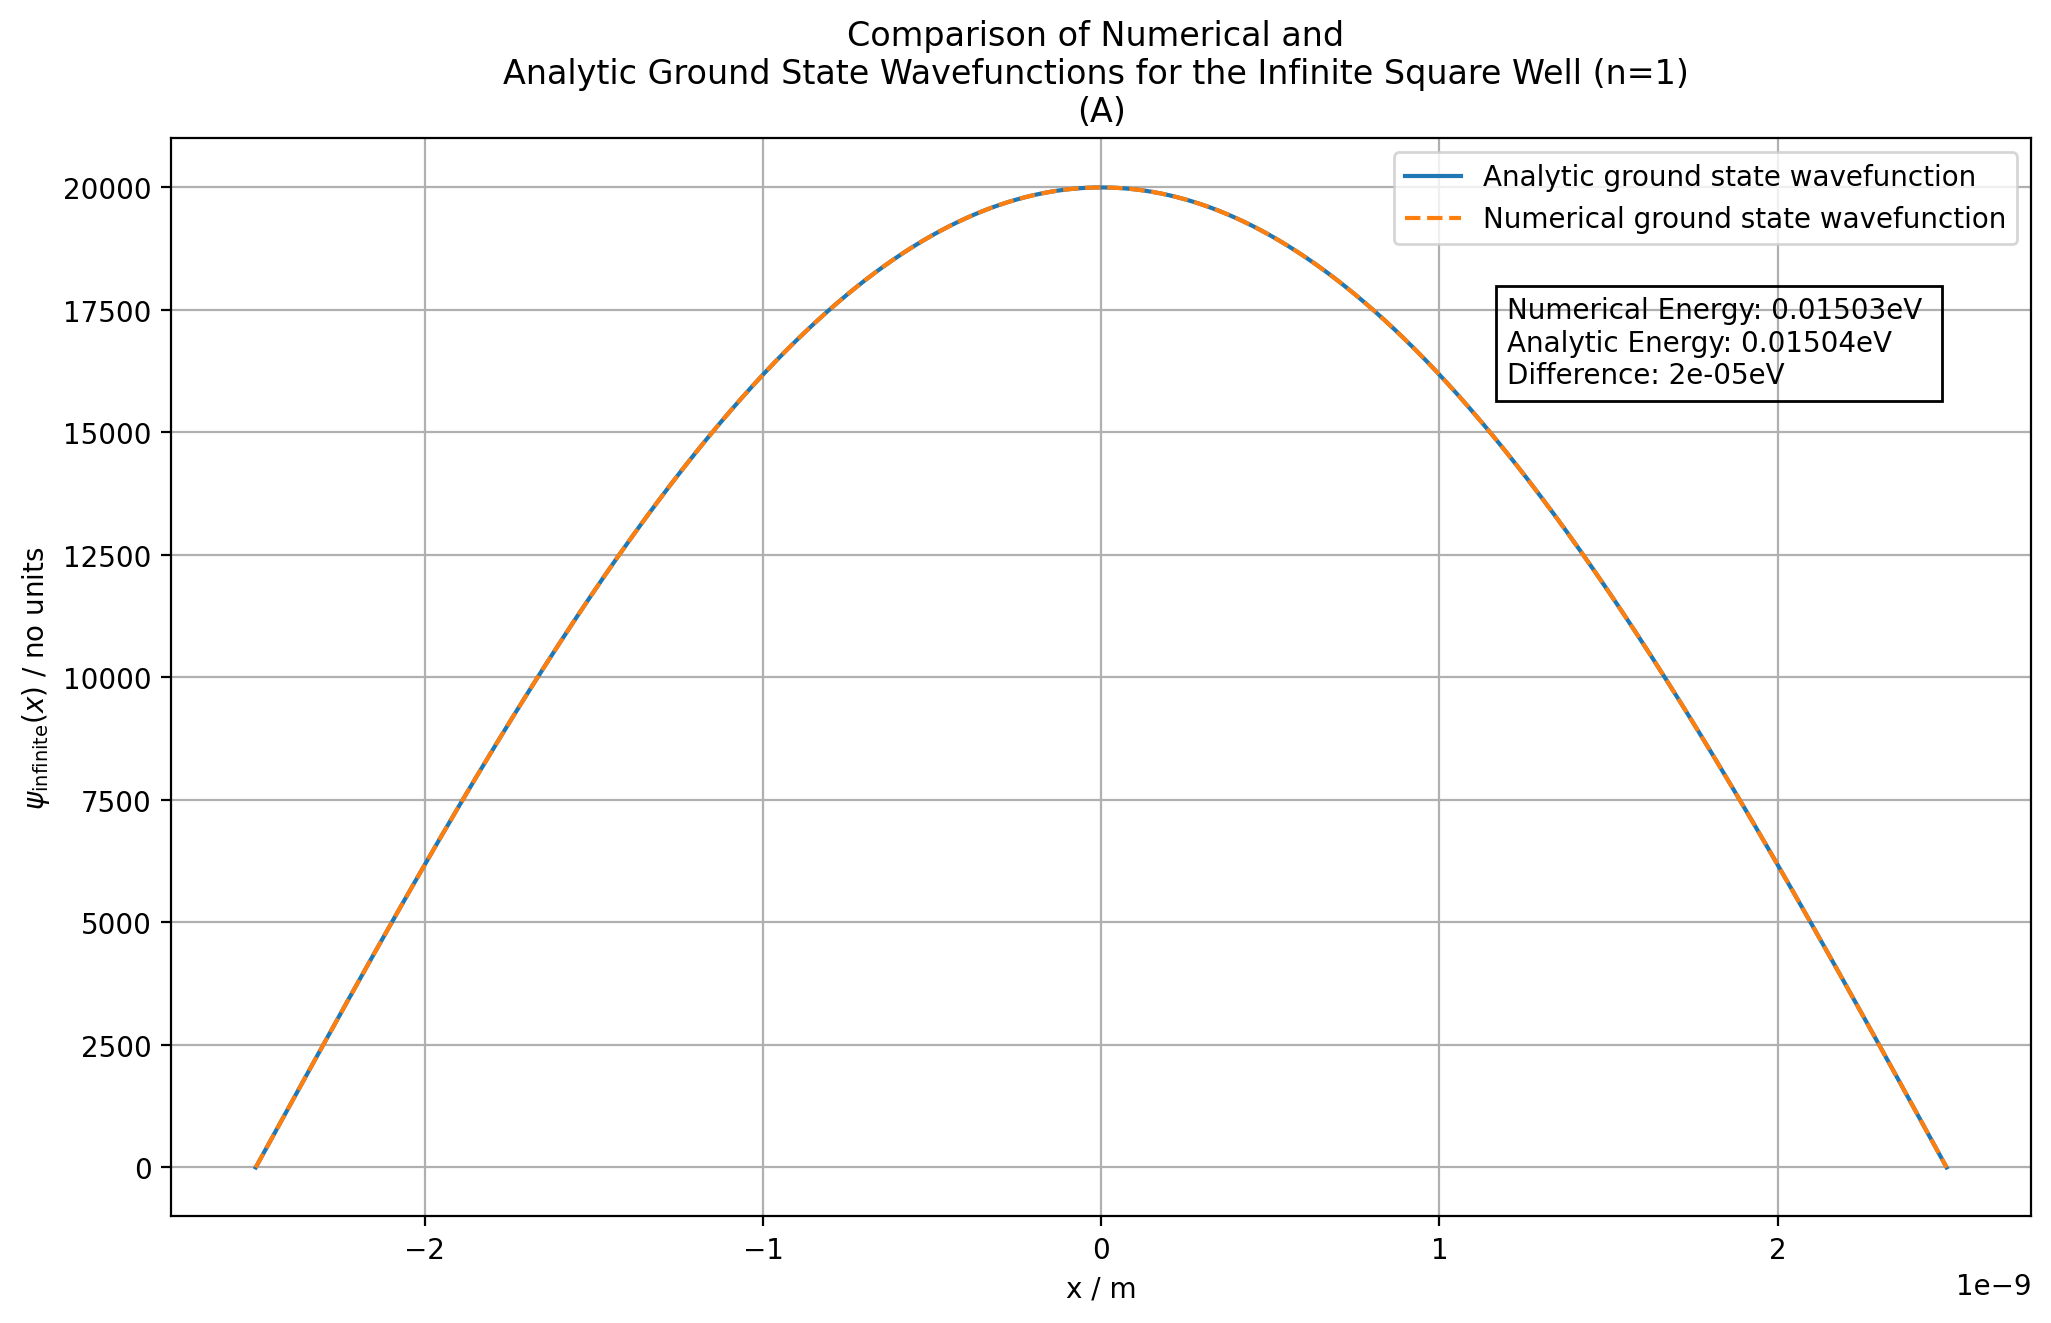

In [13]:
xarray = np.arange(-d/2, d/2 + h, h)
#Energy guess, using the guesses obtained from the energy_guess function
E_gnd_ansatz_inf = np.array([E_ansatz_inf[0]*0.9 ,E_ansatz_inf[0]])
gnd_analytic_inf = (np.pi*h_bar)**2 / (2*m_e*d**2)

#obtaining eigen energy and gnd state wavefunction and normalising
E_gnd_inf, psi_gnd_inf = secant_method(np.array([0,1]), xpoints, V_infinite, f_tise, E_gnd_ansatz_inf, e/100000)
psi_gnd_norm_inf = psi_gnd_inf[0] * 1/np.sqrt(integrate(psi_gnd_inf[0]**2, h))

#plotting numerical and analytic wavefunctions
plt.figure()
plt.grid()
plt.plot(xarray, (1/np.sqrt(d/2)) * np.cos((np.pi*xarray)/d), label = "Analytic ground state wavefunction")
plt.plot(xarray, psi_gnd_norm_inf, "--", label = "Numerical ground state wavefunction")
plt.xlabel("x / m")
plt.ylabel(r"$\psi_{\mathrm{infinite}} (x)$ / no units")
plt.title("Comparison of Numerical and \nAnalytic Ground State Wavefunctions for the Infinite Square Well (n=1) \n(A)")
plt.legend(loc = "best")
str1 = f"Numerical Energy: {E_gnd_inf/e:.5f}eV \nAnalytic Energy: {gnd_analytic_inf/e:.5f}eV \nDifference: {((gnd_analytic_inf-E_gnd_inf)/e ):.0e}eV"
plt.text(1.2e-9,16000,str1, fontsize = 10, bbox=dict(facecolor='none', edgecolor="black"))

From \textbf{(A)}, it is evident that the numerical solution for the ground state wavefunction of the infinite square well closely approximates the analytic solution, which may be seen in the overlap between the two wavefunctions when overlaid.

Furthermore, the numerical and analytic eigen energies differ by only $2 \times 10^{-5} \,\text{eV}$, indicating that the numerical method achieves accuracy up to four decimal places; The discrepancy arises from the discretisation of the $x$ values. 

### Plots of Excited States

Text(-2.5e-09, 16000, 'Numerical Energy: 0.3757eV \nAnalytic Energy: 0.3760eV \nDifference: 4e-04eV')

<Figure size 1200x700 with 0 Axes>

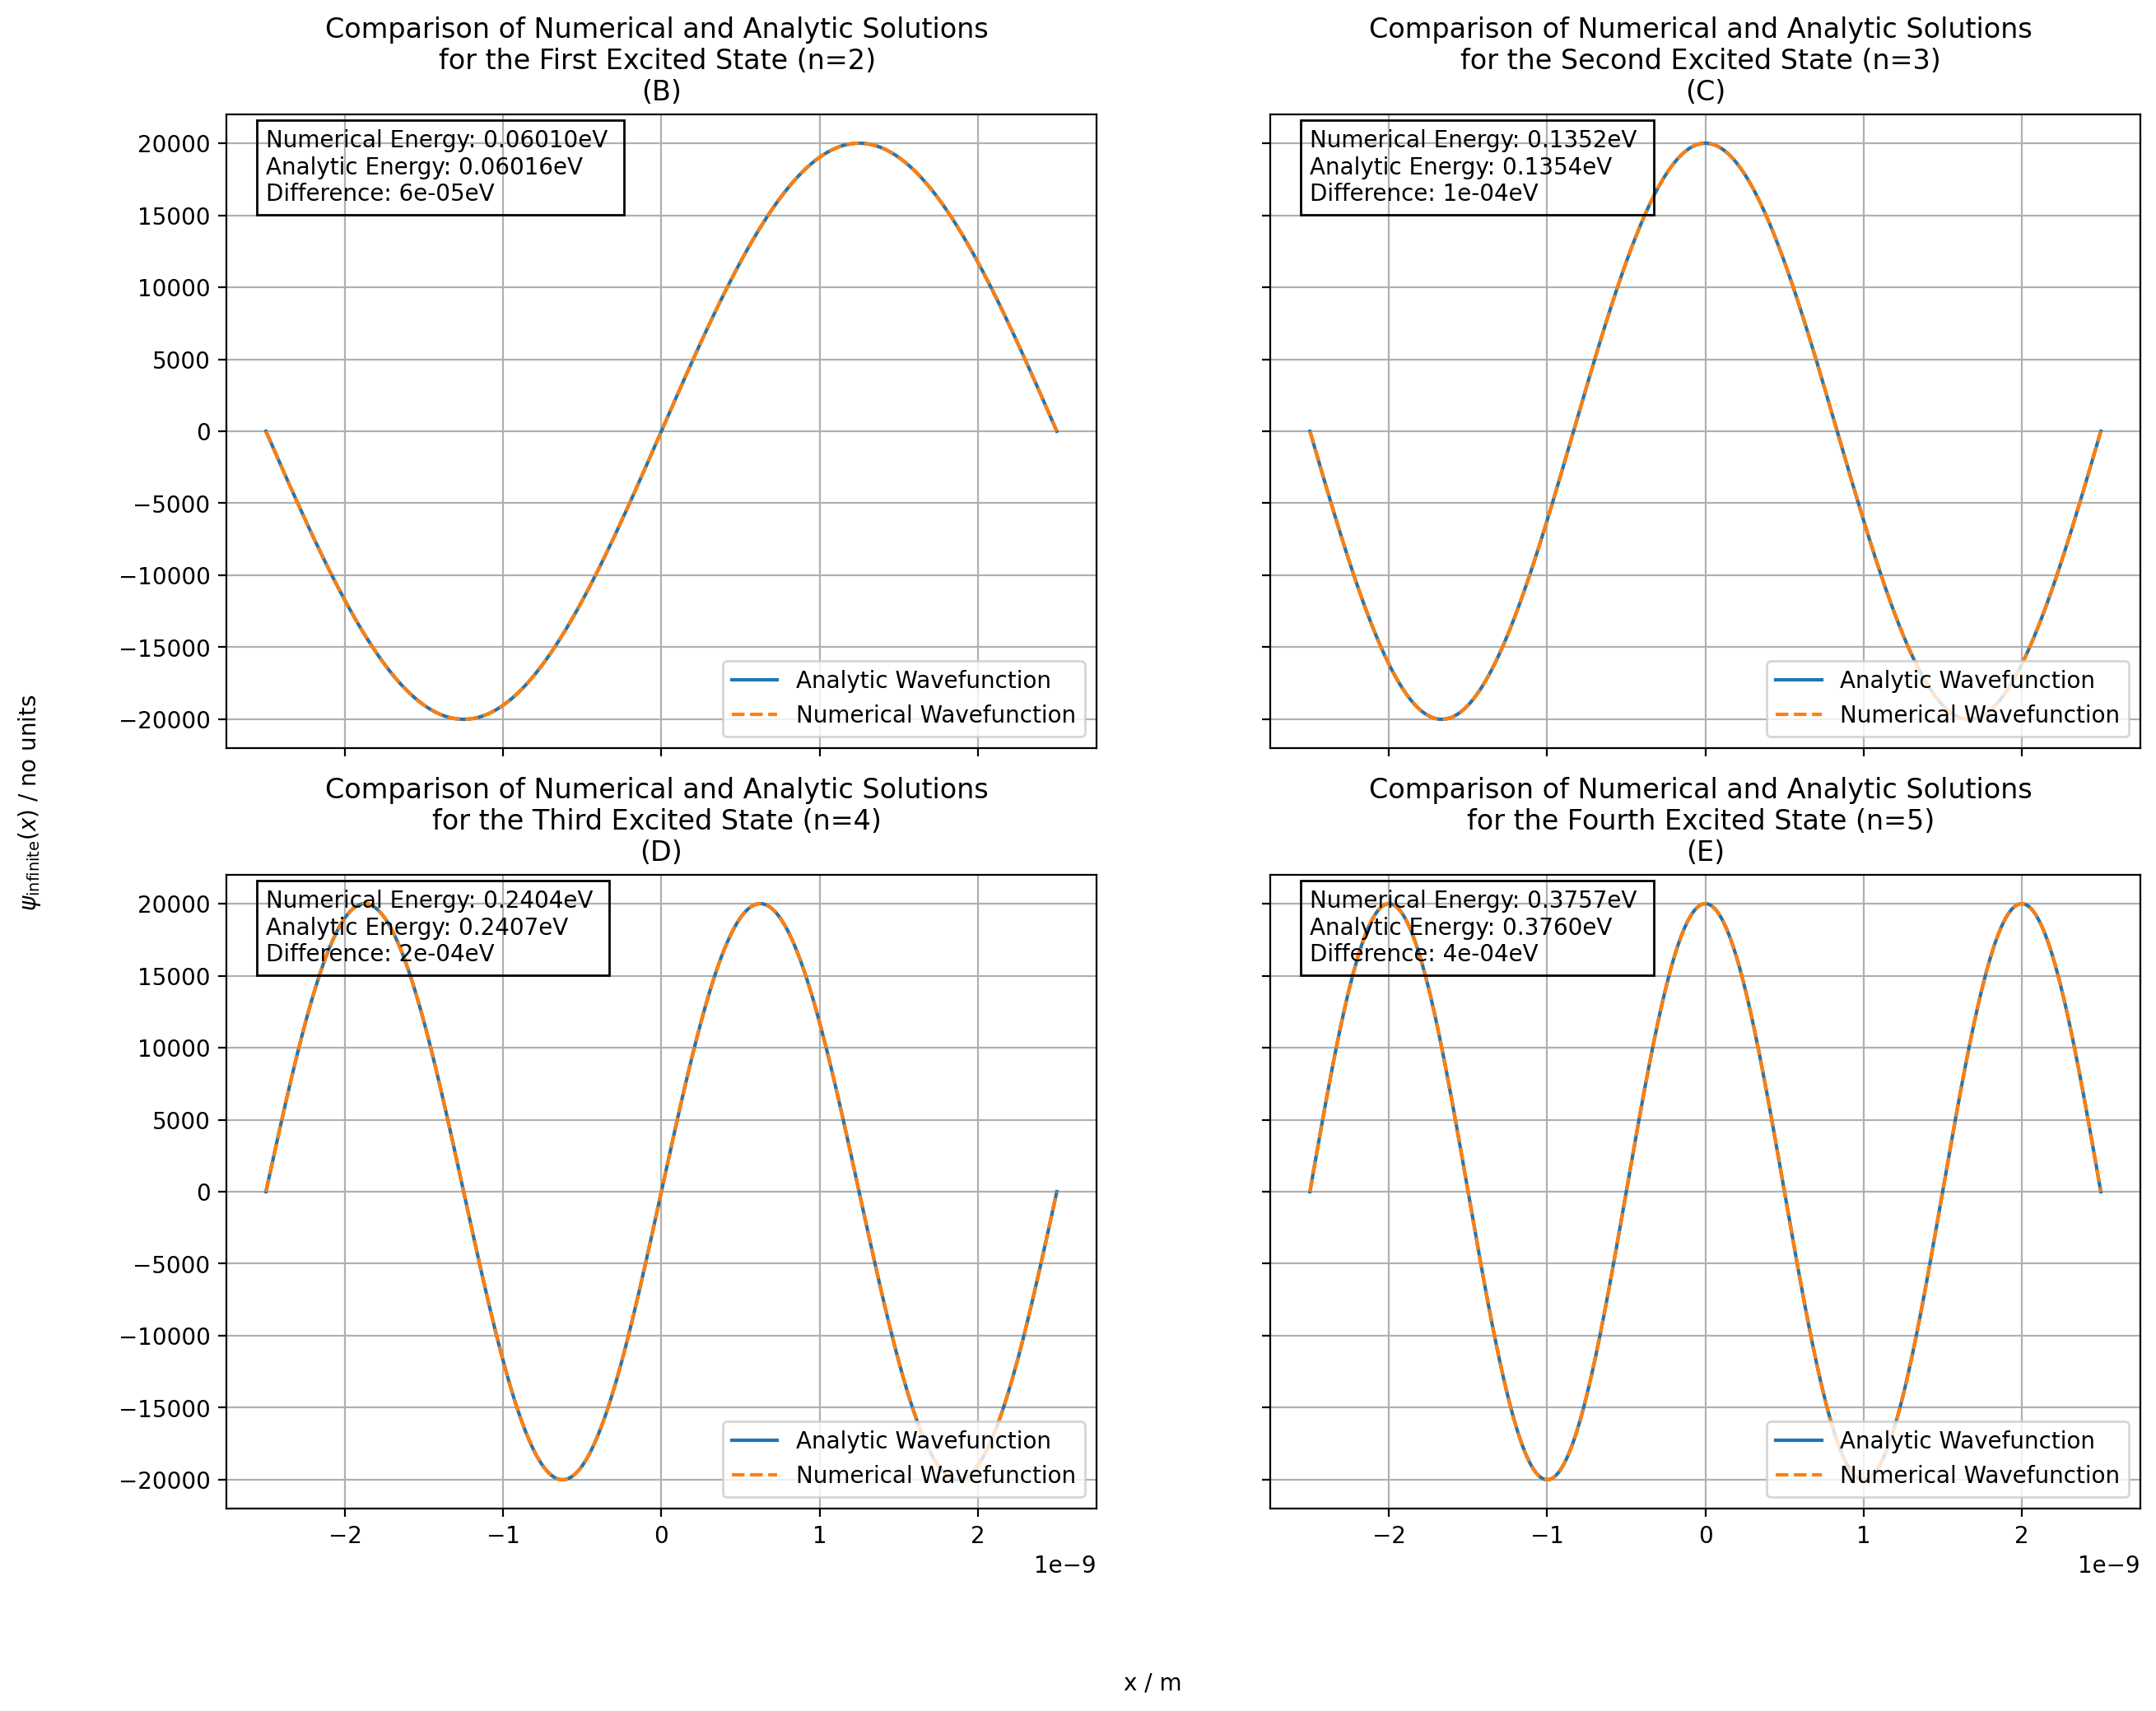

In [14]:
#Obtaining eigen energies and normalised numerical wavefunctions for the excited states n = 2, 3, 4, 5.
#n = 2 calculations
E_n2_ansatz_inf = np.array([0.8*E_ansatz_inf[1],E_ansatz_inf[1]])
E_n2_inf, psi_n2 = secant_method(np.array([0,-1]), xpoints, V_infinite, f_tise, E_n2_ansatz_inf, e/100000)
psi_n2_norm_inf = psi_n2[0] * 1/np.sqrt(integrate(psi_n2[0]**2, h))
#analytic eigen energy for n =2
n2_analytic_inf = gnd_analytic_inf*4

#n = 3 calculations
E_n3_ansatz_inf = np.array([0.8*E_ansatz_inf[2],E_ansatz_inf[2]])
E_n3_inf, psi_n3_inf = secant_method(np.array([0,-1]), xpoints, V_infinite, f_tise, E_n3_ansatz_inf, e/100000)
psi_n3_norm_inf = psi_n3_inf[0] * 1/np.sqrt(integrate(psi_n3_inf[0]**2, h))
#analytic eigen energy for n =3
n3_analytic_inf = gnd_analytic_inf*9

#n = 4 calculations
E_n4_ansatz_inf = np.array([0.8*E_ansatz_inf[3],E_ansatz_inf[3]])
E_n4_inf, psi_n4_inf = secant_method(np.array([0,1]), xpoints, V_infinite, f_tise, E_n4_ansatz_inf, e/100000)
psi_n4_norm_inf = psi_n4_inf[0] * 1/np.sqrt(integrate(psi_n4_inf[0]**2, h))
#analytic eigen energy for n =4
n4_analytic_inf = gnd_analytic_inf*16

#n = 5 calculations
E_n5_ansatz_inf = np.array([0.8*E_ansatz_inf[4],E_ansatz_inf[4]])
E_n5_inf, psi_n5_inf = secant_method(np.array([0,1]), xpoints, V_infinite, f_tise, E_n5_ansatz_inf, e/100000)
psi_n5_norm_inf = psi_n5_inf[0] * 1/np.sqrt(integrate(psi_n5_inf[0]**2, h))
#analytic eigen energy for n =5
n5_analytic_inf = gnd_analytic_inf*25

#Plotting analytic and numerical solutions at each excited state
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
fig, axs = plt.subplots(2,2, sharex = True, sharey = True, figsize = (15,11))
fig.text(0.5, 0.01, 'x / m', ha='center')
fig.text(0.04, 0.5, r'$\psi_{\mathrm{infinite}} (x)$ / no units', va='center', rotation='vertical')

for i in range(2):
    for j in range(2):
        axs[i,j].grid()
        
axs[0,0].set_title("Comparison of Numerical and Analytic Solutions \nfor the First Excited State (n=2) \n(B)")
axs[0,1].set_title("Comparison of Numerical and Analytic Solutions \nfor the Second Excited State (n=3) \n(C)")
axs[1,0].set_title("Comparison of Numerical and Analytic Solutions \nfor the Third Excited State (n=4) \n(D)")
axs[1,1].set_title("Comparison of Numerical and Analytic Solutions \nfor the Fourth Excited State (n=5) \n(E)")

axs[0,0].plot(xarray, (1/np.sqrt(d/2)) * np.sin((np.pi*xarray*2)/d), label = "Analytic Wavefunction")
axs[0,0].plot(xarray, psi_n2_norm_inf, "--", label = "Numerical Wavefunction")
axs[0,0].legend(loc = "lower right")
str2 = f"Numerical Energy: {E_n2_inf/e:.5f}eV \nAnalytic Energy: {n2_analytic_inf/e:.5f}eV \nDifference: {(abs(n2_analytic_inf-E_n2_inf)/e ):.0e}eV"
axs[0,0].text(-2.5e-9,16000,str2, fontsize = 10, bbox=dict(facecolor='none', edgecolor="black"))

axs[0,1].plot(xarray, (1/np.sqrt(d/2)) * np.cos((np.pi*xarray*3)/d), label = "Analytic Wavefunction")
axs[0,1].plot(xarray, psi_n3_norm_inf, "--", label = "Numerical Wavefunction")
axs[0,1].legend(loc = "lower right")
str3 = f"Numerical Energy: {E_n3_inf/e:.4f}eV \nAnalytic Energy: {n3_analytic_inf/e:.4f}eV \nDifference: {(abs(n3_analytic_inf-E_n3_inf)/e ):.0e}eV"
axs[0,1].text(-2.5e-9,16000,str3, fontsize = 10, bbox=dict(facecolor='none', edgecolor="black"))

axs[1,0].plot(xarray, (1/np.sqrt(d/2)) * np.sin((np.pi*xarray*4)/d), label = "Analytic Wavefunction")
axs[1,0].plot(xarray, psi_n4_norm_inf, "--", label = "Numerical Wavefunction")
axs[1,0].legend(loc = "lower right")
str4 = f"Numerical Energy: {E_n4_inf/e:.4f}eV \nAnalytic Energy: {n4_analytic_inf/e:.4f}eV \nDifference: {(abs(n4_analytic_inf-E_n4_inf)/e ):.0e}eV"
axs[1,0].text(-2.5e-9,16000,str4, fontsize = 10, bbox=dict(facecolor='none', edgecolor="black"))


axs[1,1].plot(xarray, (1/np.sqrt(d/2)) * np.cos((np.pi*xarray*5)/d), label = "Analytic Wavefunction")
axs[1,1].plot(xarray, psi_n5_norm_inf, "--", label = "Numerical Wavefunction")
axs[1,1].legend(loc = "lower right")
str5 = f"Numerical Energy: {E_n5_inf/e:.4f}eV \nAnalytic Energy: {n5_analytic_inf/e:.4f}eV \nDifference: {(abs(n5_analytic_inf-E_n5_inf)/e ):.0e}eV"
axs[1,1].text(-2.5e-9,16000,str5, fontsize = 10, bbox=dict(facecolor='none', edgecolor="black"))

Overlaying the analytic solutions onto the numerical solutions in Figures \textbf{(B)} to \textbf{(E)}, it is evident that the numerical wavefunctions for the low-lying excited states closely match their analytic solutions.

Furthermore, numerical and analytic eigen energies agree to a fairly high precision; a trend is noted that as the energy state increases, the numerical and analytic solutions start to differ to a greater degree, as seen in the ~$10^{-5}$ errors in the ground and first excited state, to the ~$10^{-4}$ error in latter states.

From these findings, it may be concluded that the accuracy of our initial energy estimates was sufficient for the Secant Method to converge to the correct eigen energies; using only 25 discrete energy points within the range $0.001 \,\text{eV}$ to $0.5 \,\text{eV}$ proved to be adequately dense for obtaining accurate initial guesses, thus balancing computational efficiency with guess quality.

### Higher Excited States

Extending the analysis beyond the lower energy states, investigation of the cases of $n = 18$ and $n = 25$ will also be considered. Since these higher excited states lie well beyond the energy range used for the ground and low lying states, modifications to the 'energy_guess' function are necessary. 

A new approach is implemented to ensure that if the specified energy range does not contain the desired higher eigen energies, the search range is automatically extended. This iterative process continues until the $n$th eigenstate of interest is successfully identified. By automating the adjustment of the energy search range, the method reduces trial and error and ensures the desired eigen energy is found.

In [15]:
def guess_energy_higher(r, xpoints, f, V, E_range, n):
    """Function outputs the guessed eigen energies for higher excited states, specified by the input n.
    Inputs:
        r (array) - initial values of psi and phi
        xpoints (array) - holds all points within the desired domain (in meters) 
        V (function) - the potential function that describes the well
        f (function) - the vector function in equation ()
        E_range (array) - a range of energy values (in Joules) to be checked 
                    for potential eigen energies (to be passed as ansatz in further functions)
        n (int) - the higher excited state of interest.
    
    Outputs a list of guessed eigen energies up to and including the nth energy state, along with 
    the final points of the wave function and the total energy range considered."""
    
    #make a copy of the original E_range
    E_range2 = np.copy(E_range)
    
    #calculate the full range of the E_range array and size of interval
    step = E_range[1] - E_range[0]
    full_range = E_range[-1] - E_range[0]
    
    #obtain the list of preliminary guessed eigen values in the specified range, along with 
    #the final points of the wavefunction (to be plotted) and convert them to arrays
    eigen_guess, psi_final = energy_guess(r, xpoints, f, V, E_range)
    eigen_guess = np.array(eigen_guess)
    psi_final = np.array(psi_final)
    
    #if the number of eigen guesses in the list does not reach the desired nth state,
    #repeat this block until the criterion is met:
    while len(eigen_guess) < n:
        
        #First obtain the sign of the last value of the E_range
        tempvar1 = np.sign(RungeKutta(r, xpoints, V, f, E_range[-1])[0][-1])
        
        #Redefine E_range to start at its previous endpoint + step, and extending its
        #new endpoint by the "full_range" variable (extra +step is to capture the endpoint)
        E_range = np.arange(E_range[-1] + step, E_range[-1]+full_range+step, step)
        
        #Add the new E_range onto the old
        E_range2 = np.concatenate((E_range2, E_range))
        
        #Check the sign of the new startpoint of the new E_range
        tempvar2 = np.sign(RungeKutta(r, xpoints, V, f, E_range[0])[0][-1])
        
        #Check if there is a sign change in going from the endpoint of the old E_range
        #to the start of the new E_range.
        if int(tempvar1 + tempvar2) == 0:
            eigen_guess = np.concatenate((eigen_guess, np.array([E_range[0]])))
        
        #Find eigen values in the new range and convert list to arrays
        eigen_guess2, psi_final2 = energy_guess(r, xpoints, f, V, E_range)
        eigen_guess2 = np.array(eigen_guess2)
        psi_final2 = np.array(psi_final2)
        
        #Concatenate the old array of eigen guesses with the ones found in the new range
        eigen_guess = np.concatenate((eigen_guess, eigen_guess2))
        psi_final = np.concatenate((psi_final, psi_final2))
        
    
    #output the total array of eigen guesses, final points of the wavefunction as a function of energy
    #and the total energy range
    return eigen_guess, psi_final, E_range2

In [16]:
#finding guess eigen energies up to n = 25
E_ansatz_inf2, psi_inf_finalpts2, E_range2 = guess_energy_higher(np.array([0,1]), xpoints, f_tise, V_infinite, np.linspace(0.001*e, 0.5*e, 10), 25)

The guessed eigen energies up to n = 25 for the inf. sq. well:
 [1.00000000e-03 5.64444444e-02 1.11888889e-01 2.22777778e-01
 3.33666667e-01 5.55444444e-01 7.21777778e-01 9.43555556e-01
 1.16533333e+00 1.55344444e+00 1.77522222e+00 2.16333333e+00
 2.55144444e+00 2.93955556e+00 3.32766667e+00 3.82666667e+00
 4.32566667e+00 4.82466667e+00 5.37911111e+00 5.98900000e+00
 6.59888889e+00 7.31966667e+00 7.92955556e+00 8.65033333e+00
 9.37111111e+00]eV


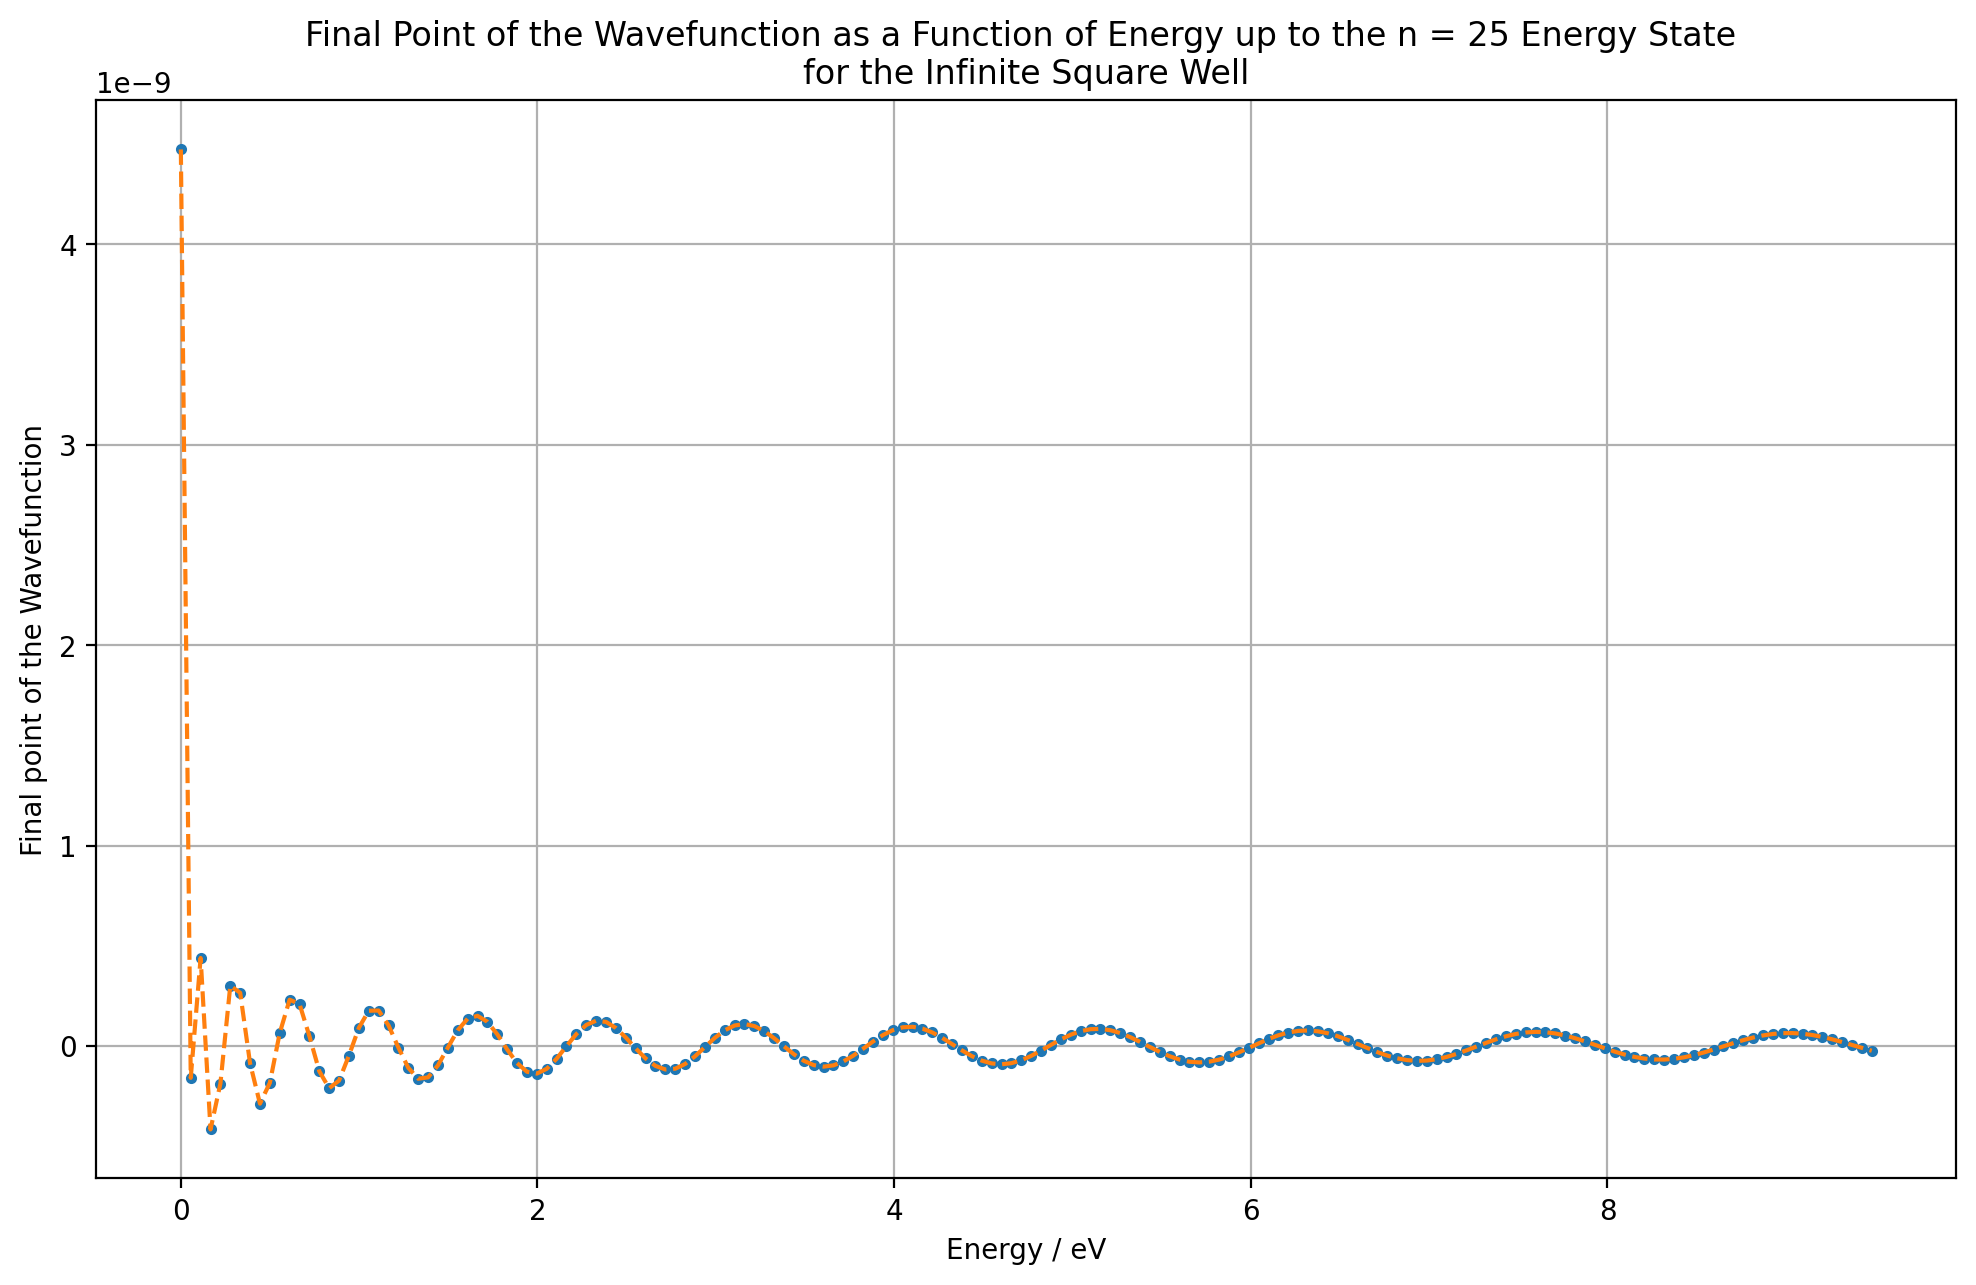

In [17]:
#plotting the wavefunction's final points as a function of energy
plt.plot(E_range2/e, psi_inf_finalpts2, '.')
plt.plot(E_range2/e, psi_inf_finalpts2, '--')
plt.grid()
plt.xlabel("Energy / eV")
plt.ylabel("Final point of the Wavefunction")
plt.title("Final Point of the Wavefunction as a Function of Energy up to the n = 25 Energy State \nfor the Infinite Square Well")
print(f"The guessed eigen energies up to n = 25 for the inf. sq. well:\n {np.array(E_ansatz_inf2)/e}eV")

The variation of $\psi_{\mathrm{final}}$ with $E$ is well modelled despite the sparse number of datapoints. This allows accurate guesses to be obtained at higher energies.

Text(-2.5e-09, -30000, 'Numerical Energy: 9.391eV \nAnalytic Energy: 9.401eV \nDifference: 9e-03eV')

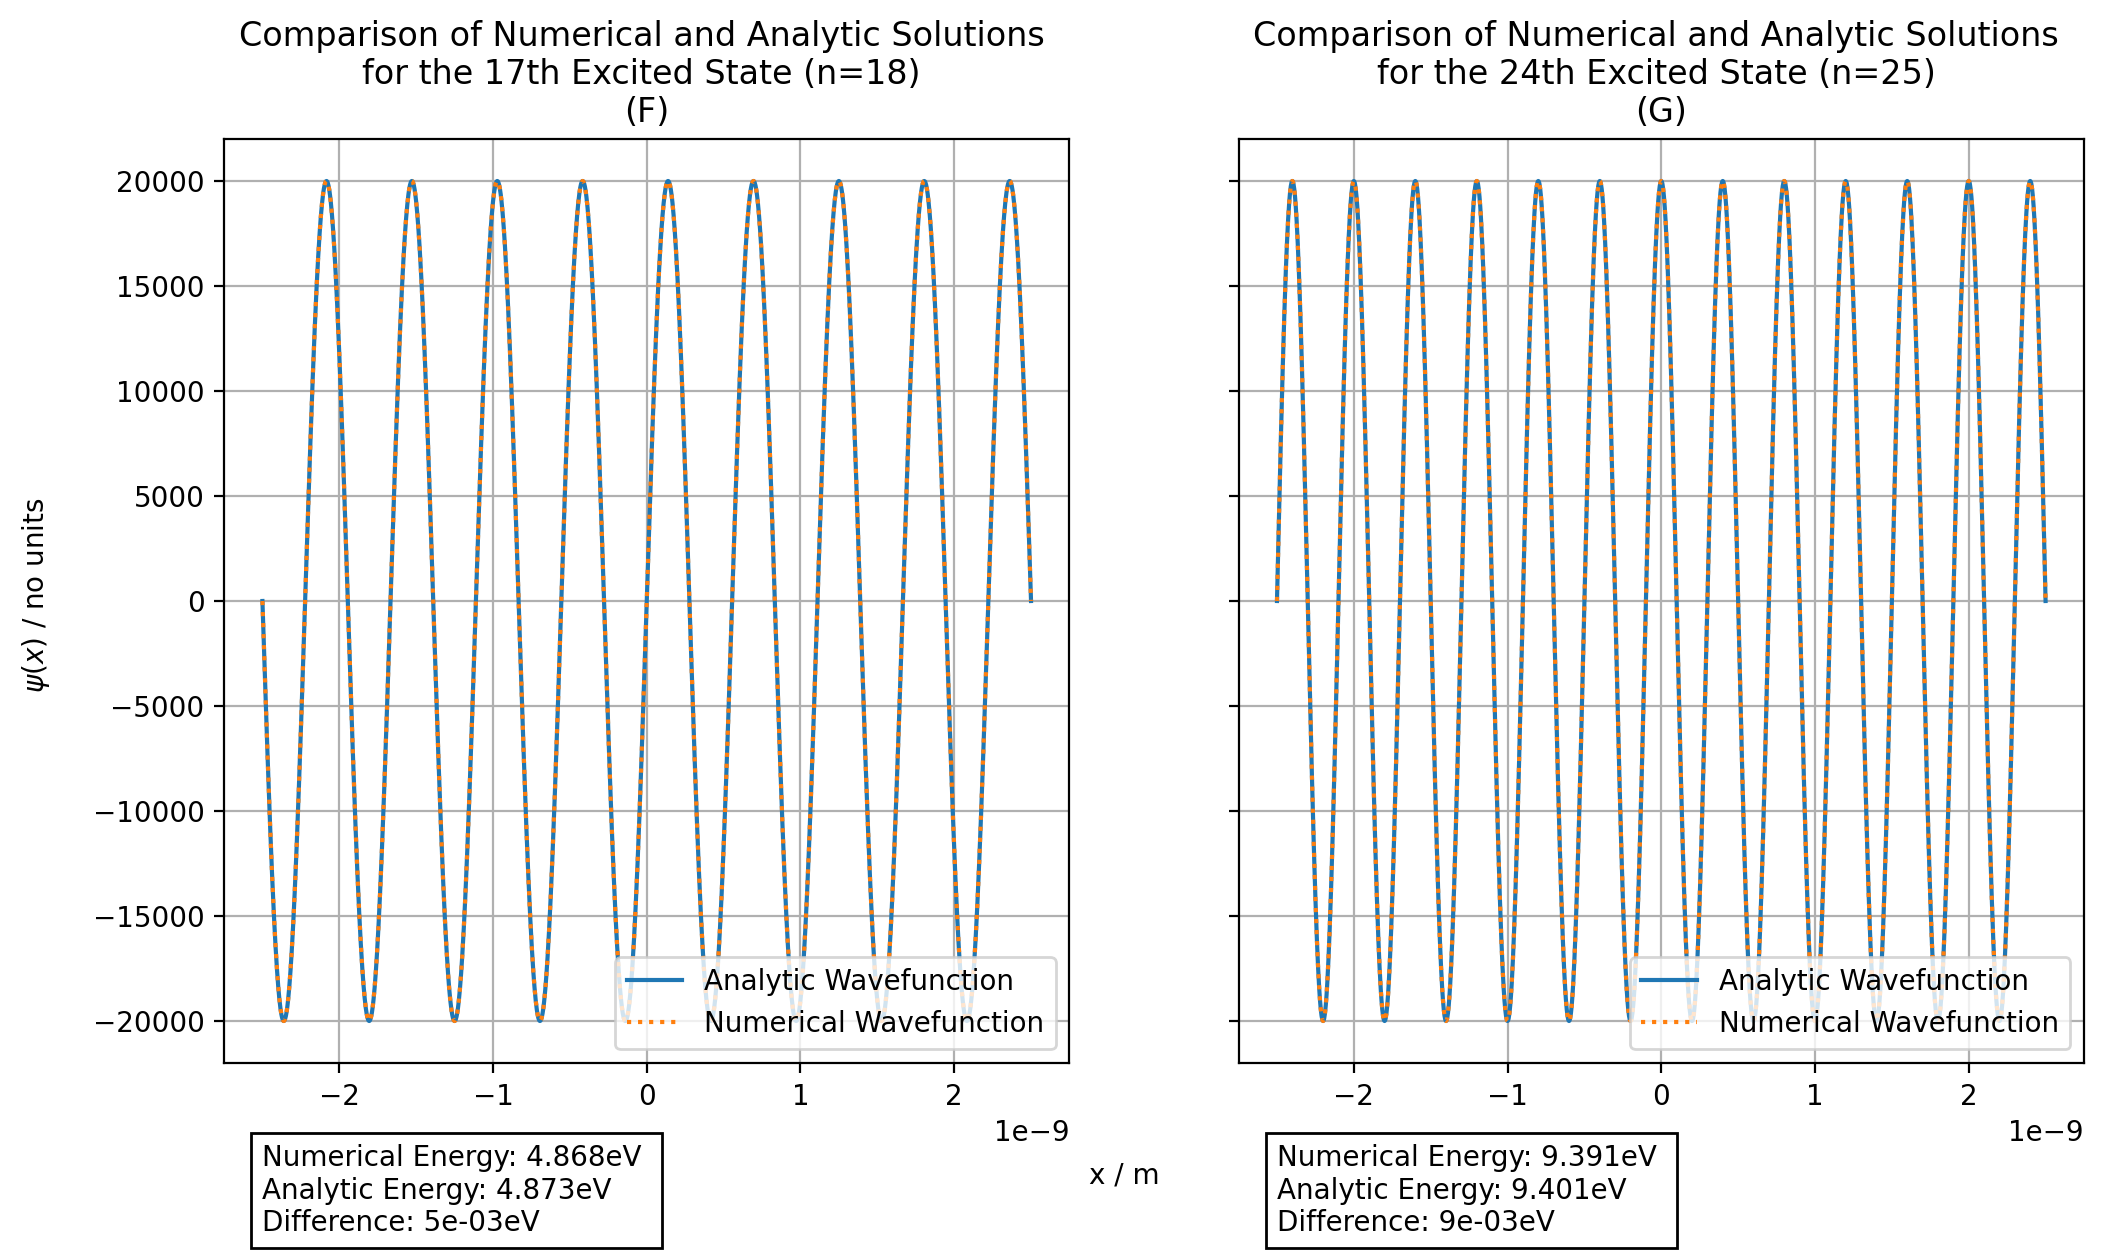

In [18]:
#n = 18 calculations
E_n18_ansatz_inf = np.array([0.95*E_ansatz_inf2[17],E_ansatz_inf2[17]])
E_n18_inf, psi_n18_inf = secant_method(np.array([0,-1]), xpoints, V_infinite, f_tise, E_n18_ansatz_inf, e/100000)
psi_n18_norm_inf = psi_n18_inf[0] * 1/np.sqrt(integrate(psi_n18_inf[0]**2, h))
#analytic eigen energy for n = 18
n18_analytic_inf = gnd_analytic_inf*(18**2)

#n = 25 calculations
E_n25_ansatz_inf = np.array([E_ansatz_inf2[24]*0.8,E_ansatz_inf2[24]])
E_n25_inf, psi_n25_inf = secant_method(np.array([0,1]), xpoints, V_infinite, f_tise, E_n25_ansatz_inf, e/100000)
psi_n25_norm_inf = psi_n25_inf[0] * 1/np.sqrt(integrate(psi_n25_inf[0]**2, h))
#analytic eigen energy for n = 25
n25_analytic_inf = gnd_analytic_inf*(25**2)

#plotting
fig, axs = plt.subplots(1,2, sharex = True, sharey = True, figsize = (12,6))
fig.text(0.5, 0.01, 'x / m', ha='center')
fig.text(0.04, 0.5, r'$\psi (x)$ / no units', va='center', rotation='vertical')

axs[0].grid()
axs[0].set_title("Comparison of Numerical and Analytic Solutions \nfor the 17th Excited State (n=18) \n(F)")
axs[0].plot(xarray, (1/np.sqrt(d/2)) * np.sin((np.pi*xarray*18)/d), label = "Analytic Wavefunction")
axs[0].plot(xarray, psi_n18_norm_inf, ":", label = "Numerical Wavefunction")
axs[0].legend(loc = "lower right")
str6 = f"Numerical Energy: {E_n18_inf/e:.3f}eV \nAnalytic Energy: {n18_analytic_inf/e:.3f}eV \nDifference: {(abs(n18_analytic_inf-E_n18_inf)/e ):.0e}eV"
axs[0].text(-2.5e-9,-30000,str6, fontsize = 10, bbox=dict(facecolor='none', edgecolor="black"))

axs[1].grid()
axs[1].set_title("Comparison of Numerical and Analytic Solutions \nfor the 24th Excited State (n=25) \n(G)")
axs[1].plot(xarray, (1/np.sqrt(d/2)) * np.cos((np.pi*xarray*25)/d), label = "Analytic Wavefunction")
axs[1].plot(xarray, psi_n25_norm_inf, ":", label = "Numerical Wavefunction")
axs[1].legend(loc = "lower right")
str7 = f"Numerical Energy: {E_n25_inf/e:.3f}eV \nAnalytic Energy: {n25_analytic_inf/e:.3f}eV \nDifference: {(abs(n25_analytic_inf-E_n25_inf)/e ):.0e}eV"
axs[1].text(-2.5e-9,-30000,str7, fontsize = 10, bbox=dict(facecolor='none', edgecolor="black"))

Overlaying the analytic plots on the numerical solutions yield near identical results. Inspecting the eigen energies, although the agreement in precision continues to decline (now the error is larger at ~$10^{-3}$), the percentage error stays roughly the same, at ~0.1%.

Thus, the numerical method agrees well with the known solutions of the infinite square well - for both low lying and higher excited states. Hence, more complicated potentials may be considered with confidence.

## Infinite 'Unsquare' Well

In the investigation of the infinite square well, a method was developed to approximate eigen energies in non-analytic situations. Backtesting this approach against known solutions for the infinite square well showed that the numerically solved eigen energies align closely with the analytic solutions (differing by ~0.1%), demonstrating accuracy of the method. Thus, the Shooting Method will be applied to the embedded harmonic potential, where solutions are not immediately solvable analytically.

### Harmonic Potential

The regular harmonic potential, with its domain spanning $\pm \infty$, has the potential function given by:
$$
V_{\mathrm{harm}}(x) =V_0 \frac{x^2}{(d/2)^2} = \frac{\omega^2 m}{2} x^2  \dots \ \dots \ \dots \ \dots \ \dots \ \dots (12) \\
\implies \omega = \frac{1}{(d/2)}\sqrt{\frac{2V_0}{m}} \dots \ \dots \ \dots \ \dots \ \dots \ \dots (13)
$$

where $\omega$ is the angular frequency, $V_0$ is the scaling factor of the potential, and $d/2$ is a constant (defined here as the half-width of the well). Thus, the TISE is given by:
\begin{align*}
-\frac{\hbar^2}{2m}& \frac{\mathrm{d}^2 \psi(x)}{\mathrm{d}x^2} + V_0 \frac{x^2}{(d/2)^2}\psi(x) = E\,\psi(x), \ \ x \in \left [-\infty,\infty \right ] \dots \ \dots \ \dots \ \dots \ \dots \ \dots (14)
\end{align*}

This has solutions given by:

\begin{align*}
\psi_n(x)= A_n
H_n\!\left(\sqrt{\frac{m\omega}{\hbar}}\, x\right)
\exp\!\left(-\frac{m\omega}{2\hbar}\, x^2\right)  \dots \ \dots \ \dots \ \dots \ \dots \ \dots &(15)\\
A_n = \left(\frac{m\omega}{\pi\hbar}\right)^{\frac{1}{4}} \frac{1}{\sqrt{2^n n!}} \dots \ \dots \ \dots \ \dots \ \dots \ \dots &(16)
\end{align*}

where $H_n\!\left(\sqrt{\frac{m\omega}{\hbar}}\, x\right)$ is the $n\rm{th}$ Hermite Polynomiall, and $A_n$ is a normalisation constant (Griffiths & Schroeter, 2001). The energies for the regular harmonic potential are given by:

$$
E_n = \hbar \omega \left(n+\frac{1}{2}\right), \quad n = 0,1,2,\dots; \  \dots \ \dots \ \dots \ \dots \ \dots \ \dots (17)
$$

### Embedded Harmonic Potential

The embedded harmonic potential describes a harmonic potential within a finite domain given by:

$$
V_{\mathrm{emb. \ harm}}(x) = \begin{cases}
V_0 \frac{x^2}{(d/2)^2} & |x| \le \frac{d}{2} \\
\infty & |x| > \frac{d}{2}
\end{cases}  \dots \ \dots \ \dots \ \dots \ \dots \ \dots (18)
$$

The TISE is only defined within the domain $x \in [-d/2, d/2]$. As a result, the wavefunction is confined within the boundaries of the well, unlike the regular harmonic potential. This confinement leads to differences in the eigen energies and wavefunction behavior. In particular, the normalisation constant in the embedded case will differ because as wavefunction must be zero at the boundaries of the well. 

A potential discrepancy between the embedded harmonic potential and the regular potential arises more apparently for higher energy states. In the embedded case, the electron is confined within the well, while in the regular case, the wavefunction of the electron is still defined outside the well. This confinement leads to higher amplitudes for the wavefunction within the well, which may differ significantly from the analytic wavefunction of the regular harmonic potential.

In [19]:
#defining the normalisation constant function to help with the investigation
def norm_const(n):
    """Returns the nth normalisation constant for the analytic wavefunction of the harmonic potential
    Takes an integer input, n and returns A_n."""
    return ( (np.sqrt(2*V0_harmonic*m_e)/(np.pi*h_bar*a))**(1/4) ) * (1/(np.sqrt(float(math.factorial(n))*(2**n))))

### Obtaining Ansatz Energies for the Embedded Harmonic Potential

The same method of obtaining guess energies is employed for the embedded harmonic potential.

In [20]:
#Calculating the first five eigen energy guesses for the embedded harmonic potential
E_ansatz_harmonic, psi_final_harmonic, E_range_harmonic = guess_energy_higher([0,1], xpoints,f_tise, V_harmonic, np.linspace(0.001*e, 0.5*e,20), 5)
print(f"First five guessed eigen energies for the embedded harmonic potential: \n{np.array(E_ansatz_harmonic)/e}eV")

First five guessed eigen energies for the embedded harmonic potential: 
[0.34242105 1.02526316 1.73436842 2.44347368 3.12631579]eV


The first five eigen energy guesses: [0.34242105 1.02526316 1.73436842 2.44347368 3.12631579]eV


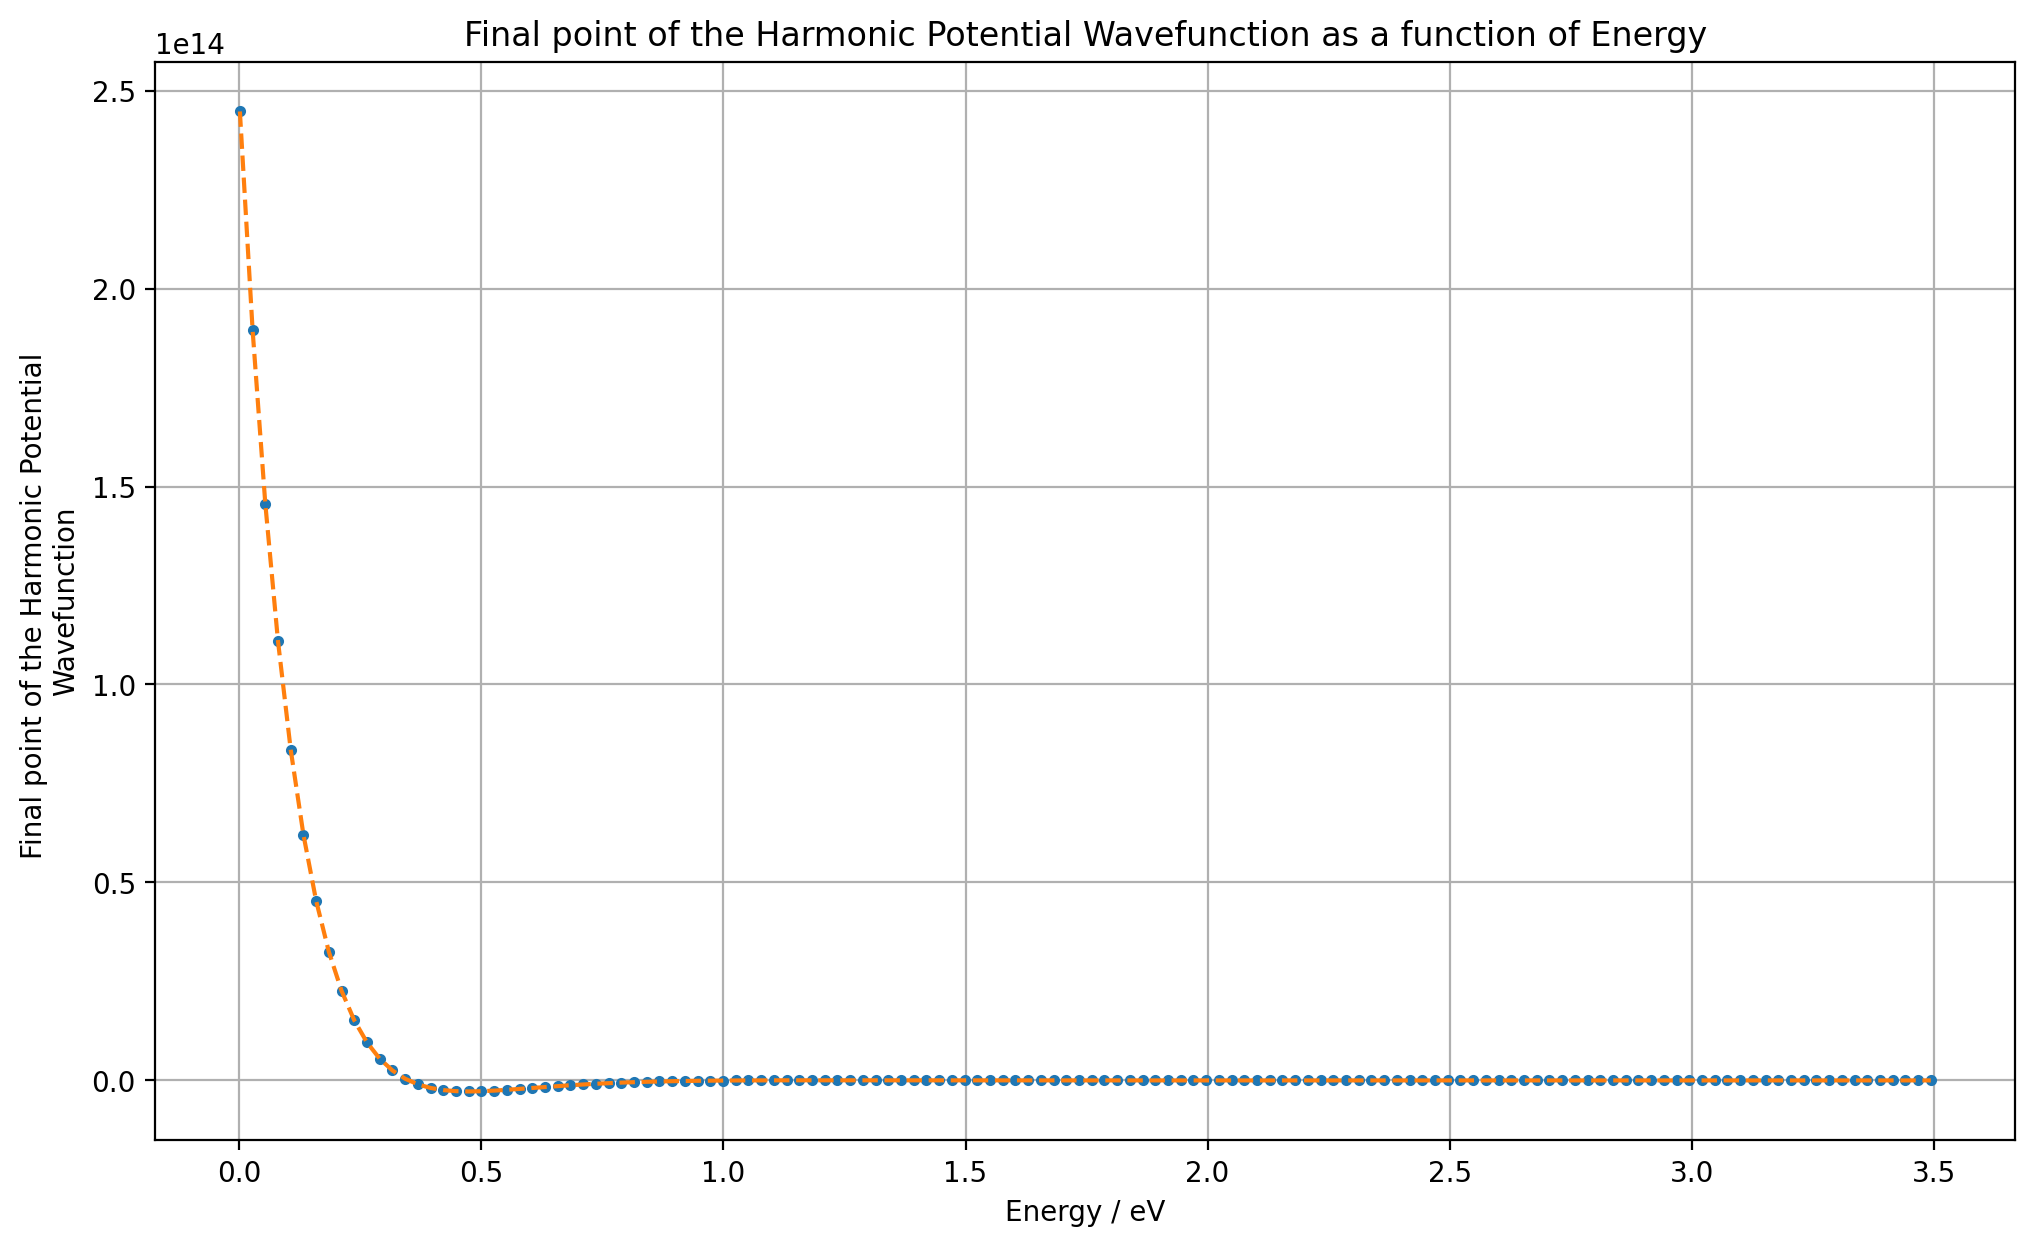

In [21]:
#plotting the final point of the wavefunction as a function of energy
plt.plot(E_range_harmonic/e, psi_final_harmonic, '.')
plt.plot(E_range_harmonic/e, psi_final_harmonic, '--')
plt.grid()
plt.xlabel("Energy / eV")
plt.ylabel("Final point of the Harmonic Potential \nWavefunction")
plt.title("Final point of the Harmonic Potential Wavefunction as a function of Energy")
print(f"The first five eigen energy guesses: {np.array(E_ansatz_harmonic)/e}eV")

This plot procures the first five guessed eigen energies for the embedded harmonic potential. The density of datapoints in the above plot is 20/0.5eV. Unlike the 'final point as a function of energy' plot in the infinite square well, x-axis intersections are hard to eyeball for the embedded harmonic potential case; this warrants the use of the 'energy_guess' and 'guess_energy_higher' functions, which does it systematically.

### Ground State of the Embedded Harmonic Potential 

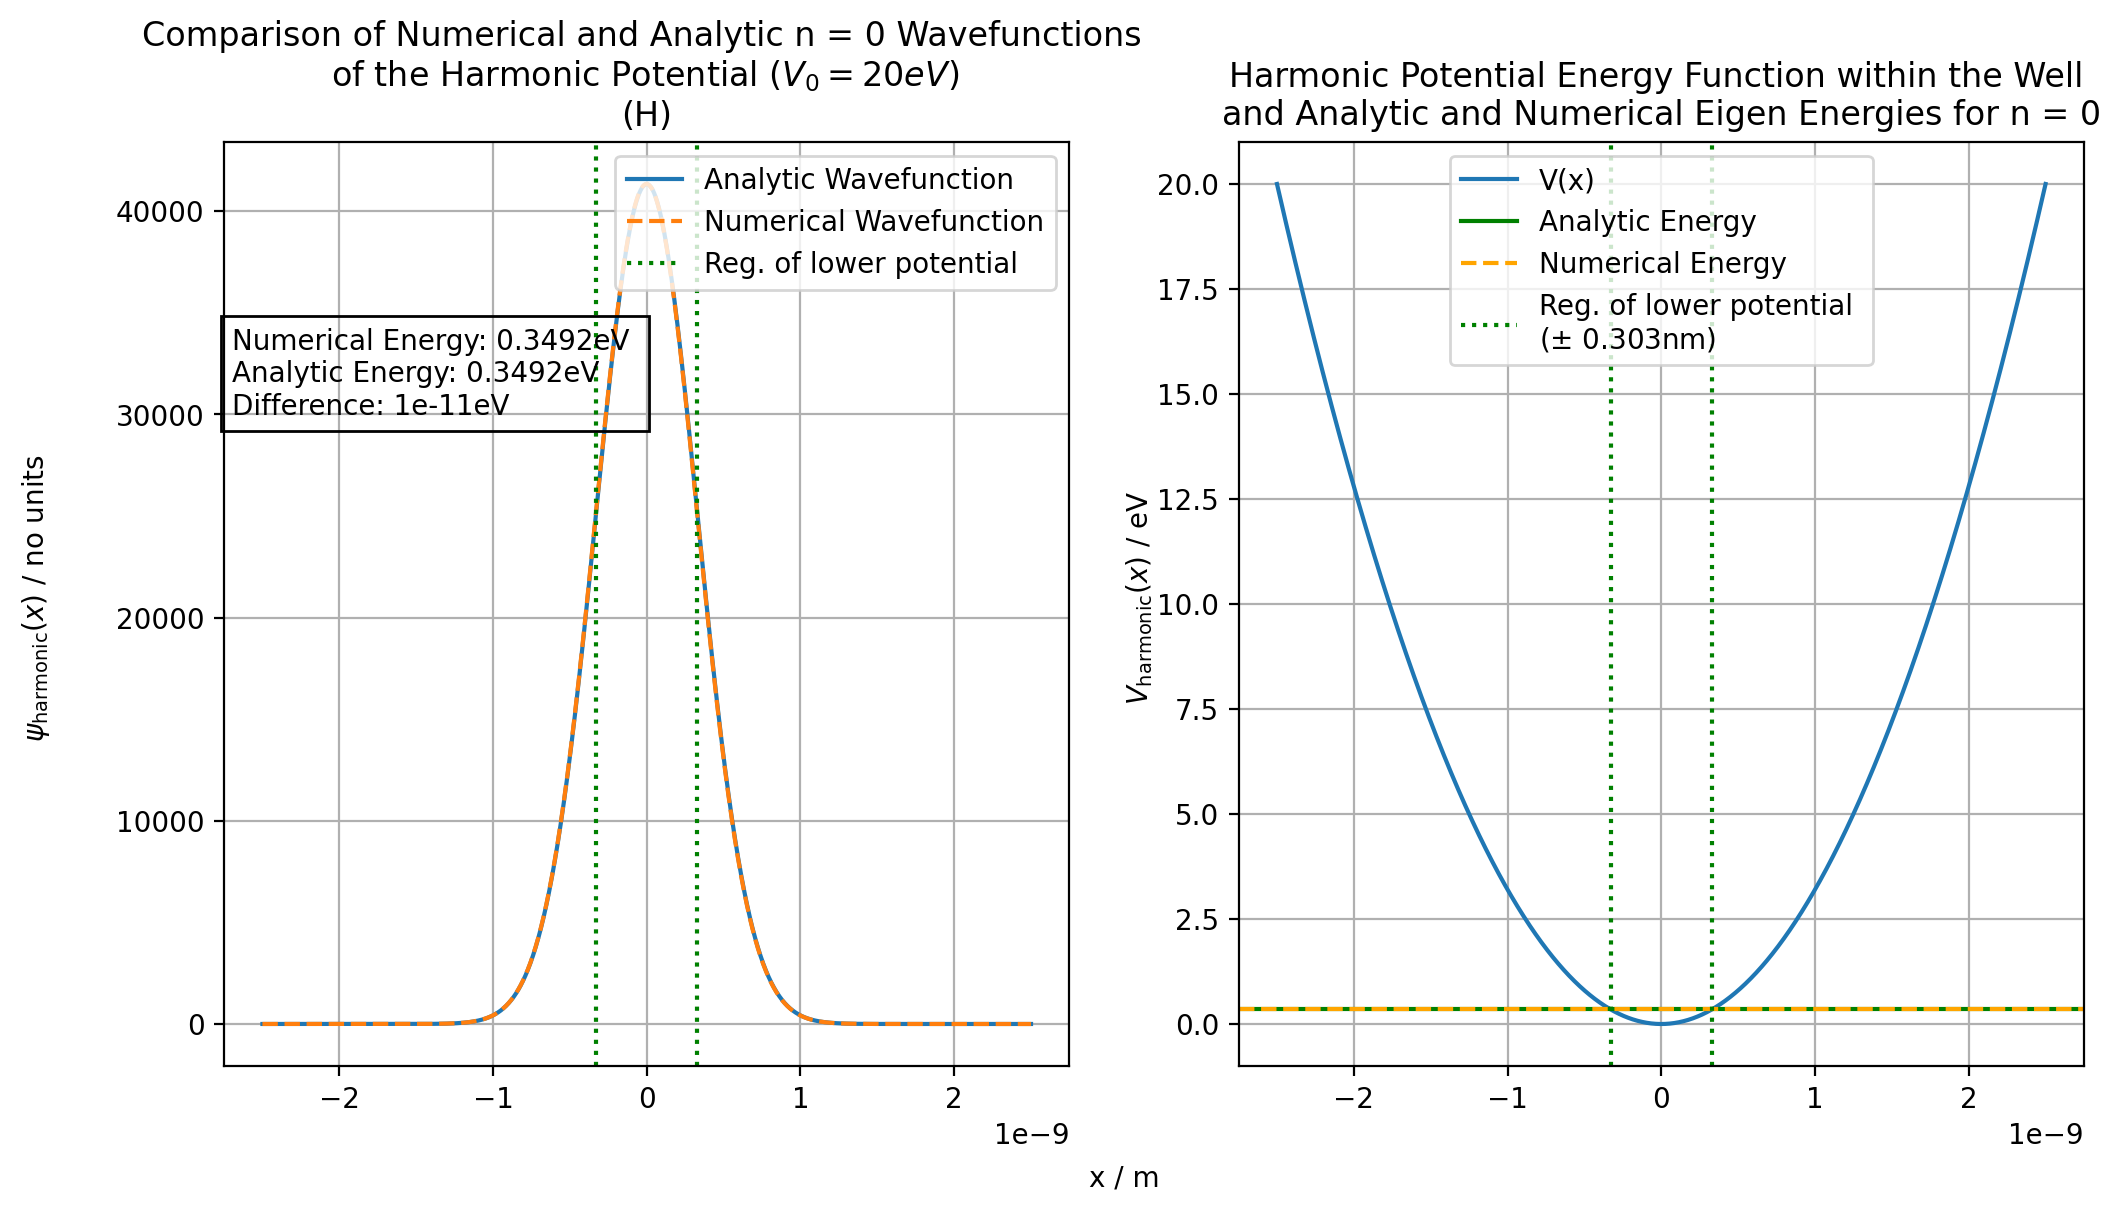

In [22]:
a = d/2
#calculating the numerical ground state wavefunction anad normalising
E_gnd_harmonic_ansatz = np.array([E_ansatz_harmonic[0]*0.9,E_ansatz_harmonic[0]])
E_gnd_harmonic, psi_gnd_harmonic = secant_method(np.array([0,1]), xpoints, V_harmonic, f_tise, E_gnd_harmonic_ansatz, e*10e-100)
psi_gnd_harmonic_norm = psi_gnd_harmonic[0]/np.sqrt(integrate(psi_gnd_harmonic[0]**2, h))
#calculating analytic energy
E_gnd_harmonic_analytic = h_bar* (1/a) * np.sqrt(2*V0_harmonic/m_e) * (1/2)

#plotting numerical and analytic wavefunctions
fig, axs = plt.subplots(1,2, sharex = 'col', sharey = 'col', figsize = (12,6))
fig.text(0.5, 0.01, 'x / m', ha='center')
fig.text(0.04, 0.5, r'$\psi_{\mathrm{harmonic}} (x)$ / no units', va='center', rotation='vertical')
fig.text(0.50, 0.5, r'$V_{\mathrm{harmonic}} (x)$ / eV', va='center', rotation='vertical')


axs[0].grid()
axs[0].set_title("Comparison of Numerical and Analytic n = 0 Wavefunctions \nof the Harmonic Potential ($V_0 = 20eV$) \n(H)")
axs[0].plot(xarray, norm_const(0)*eval_hermite(0, ((2*V0_harmonic*m_e/((h_bar*a)**2))**(1/4))*xarray)*np.exp(-np.sqrt(2*V0_harmonic*m_e)*xarray**2 / (2*h_bar*a)), label = "Analytic Wavefunction")
axs[0].plot(xarray, psi_gnd_harmonic_norm, "--", label = "Numerical Wavefunction")
str8 = f"Numerical Energy: {E_gnd_harmonic/e:.4f}eV \nAnalytic Energy: {E_gnd_harmonic_analytic/e:.4f}eV \nDifference: {(abs(E_gnd_harmonic_analytic-E_gnd_harmonic)/e ):.0e}eV"
axs[0].text(-2.7e-9,30000,str8, fontsize = 10, bbox=dict(facecolor='none', edgecolor="black"))
axs[0].axvline(3.3e-10, linestyle = ":", color = "green")
axs[0].axvline(-3.3e-10, linestyle = ":", color = "green", label = "Reg. of lower potential")
axs[0].legend(loc = "upper right")

axs[1].grid()
axs[1].set_title("Harmonic Potential Energy Function within the Well \nand Analytic and Numerical Eigen Energies for n = 0")
axs[1].plot(xarray, V0_harmonic*(xarray/(a))**2 / e, label = "V(x)")
axs[1].axhline(E_gnd_harmonic_analytic/e, color = "green", linestyle = '-', label = "Analytic Energy")
axs[1].axhline(E_gnd_harmonic/e, color = 'orange', linestyle = '--', label = "Numerical Energy")
axs[1].axvline(3.3e-10, linestyle = ":", color = "green")
axs[1].axvline(-3.3e-10, linestyle = ":", color = "green", label = "Reg. of lower potential \n($\pm$ 0.303nm)")
axs[1].legend(loc = "best")

In Figure $\textbf{(H)}$ and its corresponding embedded harmonic plot on the right, it is noted that $V_0 = 20eV$ defines the maximum height of the potential, obtained at the boundaries of the well. 

The numerical and analytical ground state agree to a large extent, with the energies only differing by ~$10^{-9}$%. Noting the behaviour of the wavefunctions, it is seen that the wavefunction is non-zero for regions where the potential is greater than the energy of the electron (the region $\pm 0.303$nm has lower potential than the electron), though the wavefunction rapidly decays, tending to zero.

### Excited States of the Embedded Harmonic Potential

<Figure size 1200x700 with 0 Axes>

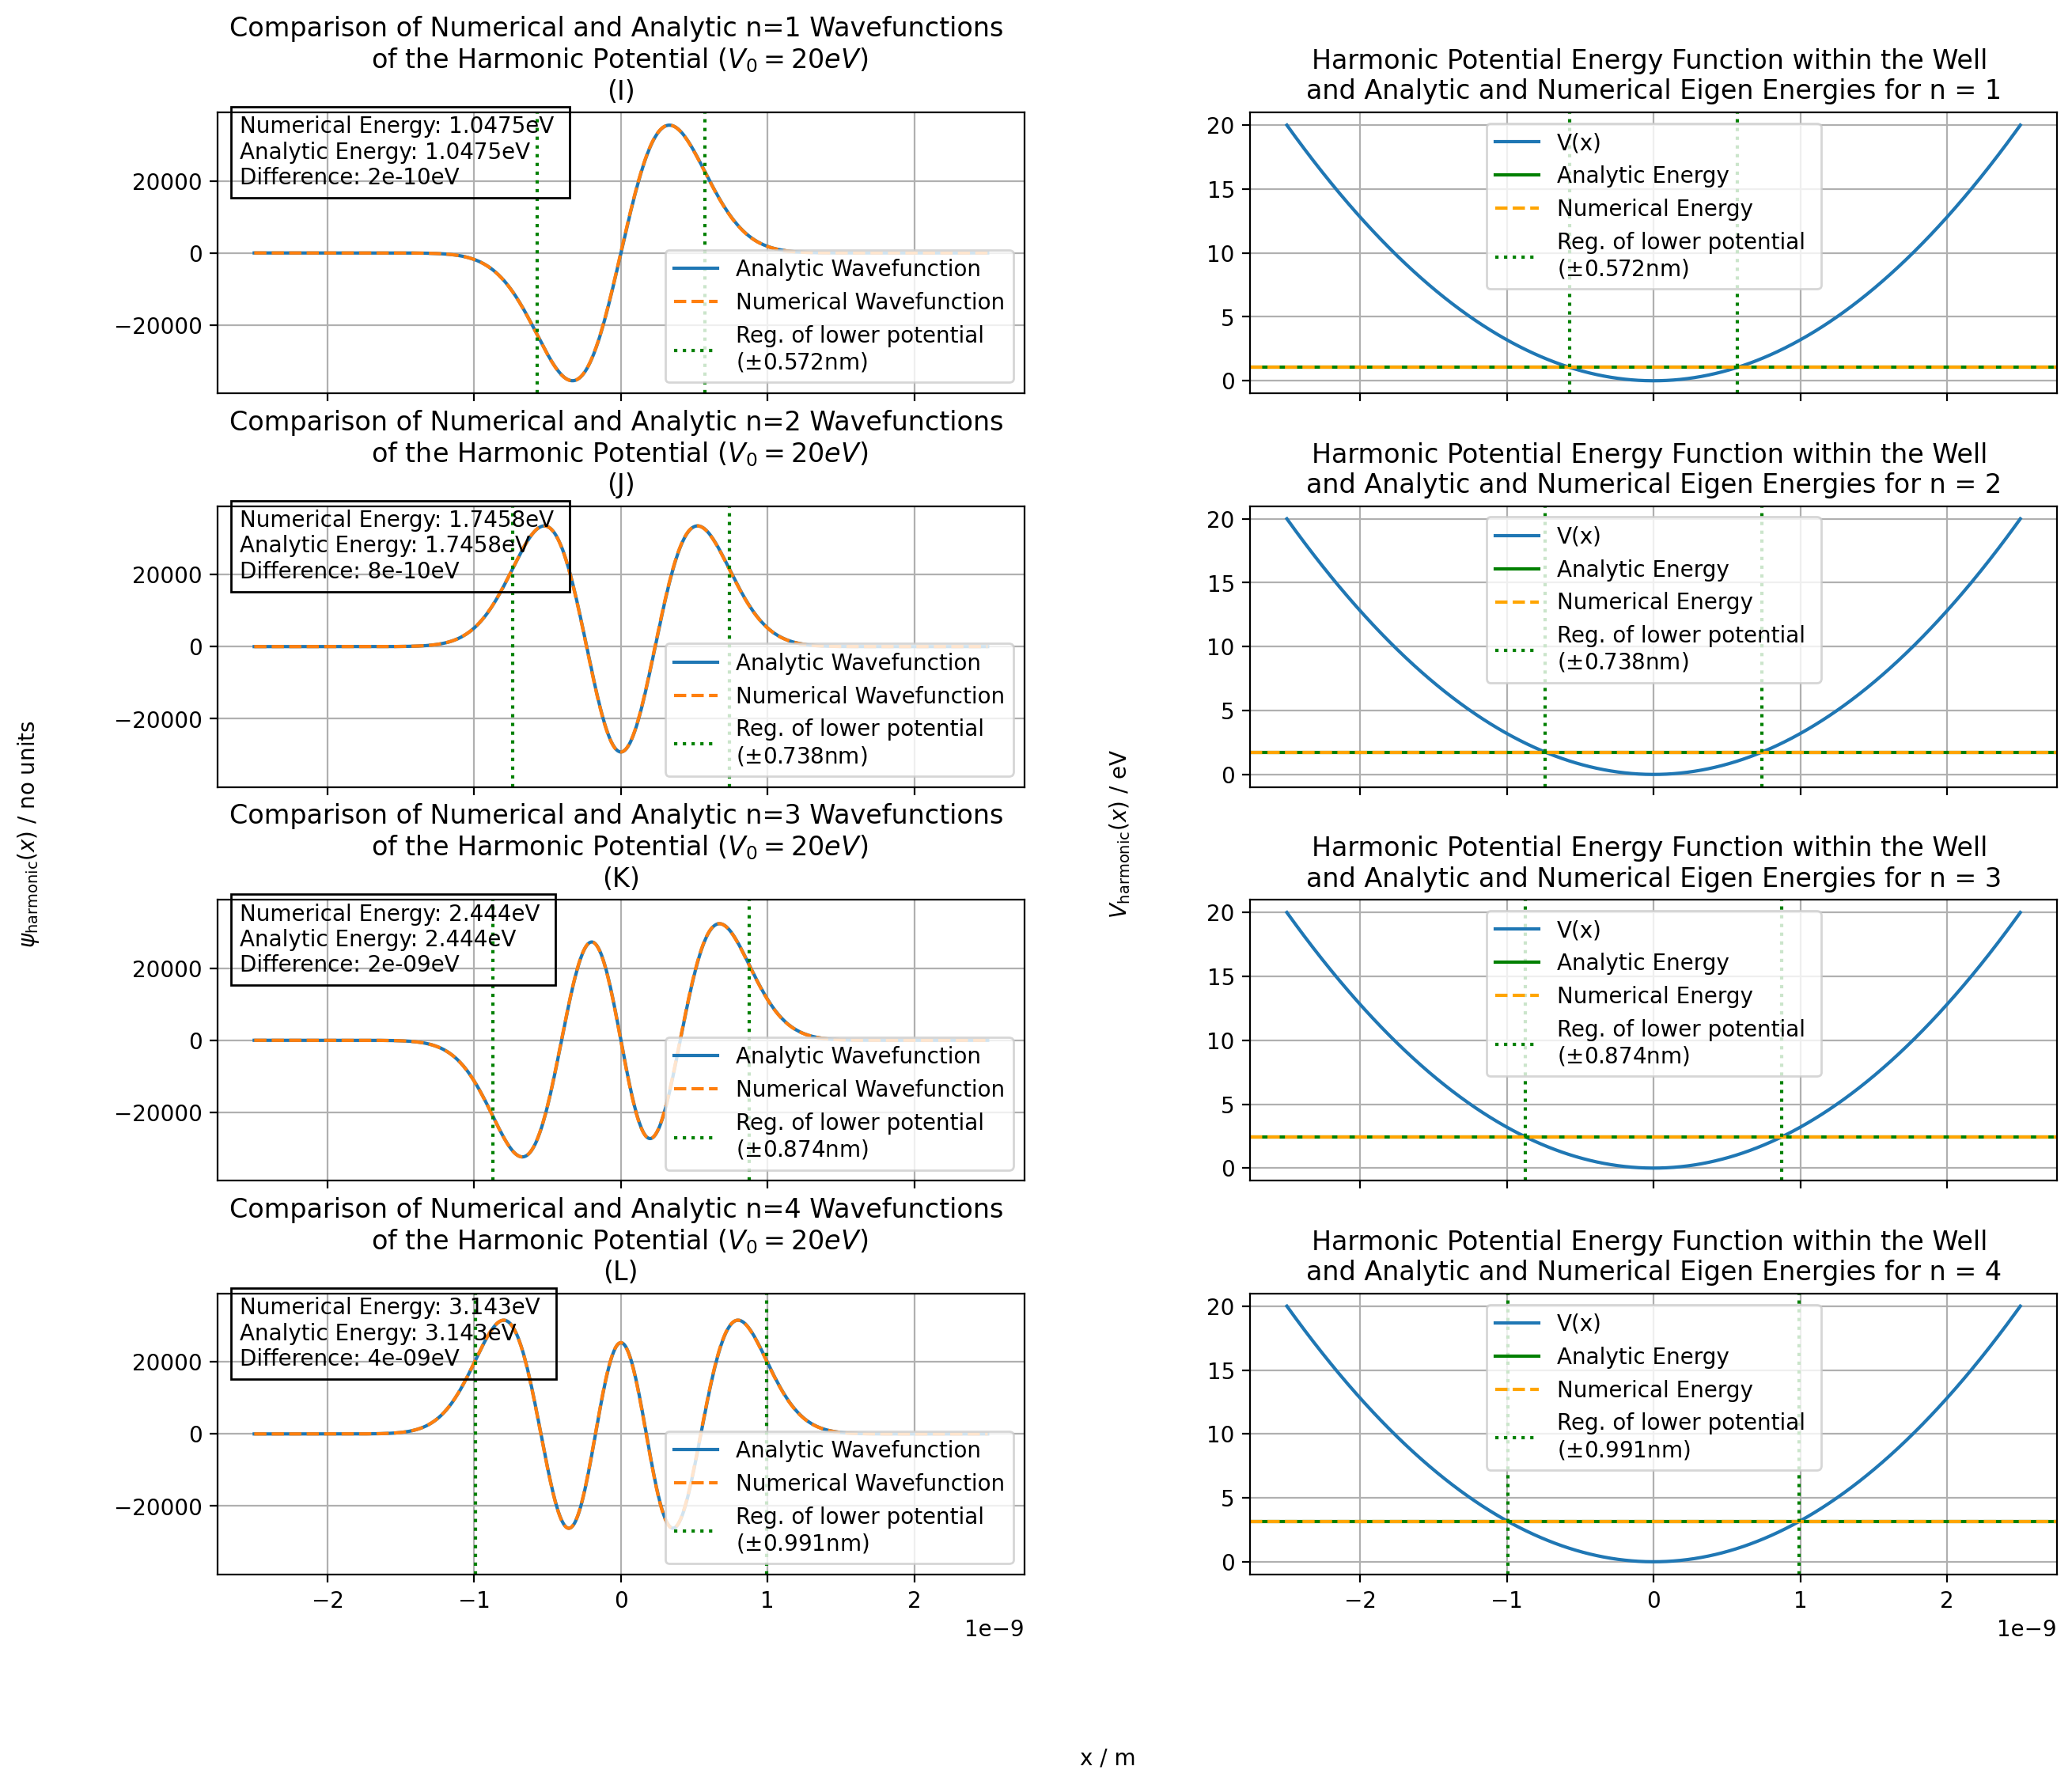

In [23]:
#n = 1 harmonic potential wavefunction calculation
E_n1_harmonic_ansatz = np.array([E_ansatz_harmonic[1]*0.95,E_ansatz_harmonic[1]])
E_n1_harmonic, psi_n1_harmonic = secant_method(np.array([0,-1]), xpoints, V_harmonic, f_tise, E_n1_harmonic_ansatz, e*10e-100)
psi_n1_harmonic_norm = psi_n1_harmonic[0]/np.sqrt(integrate(psi_n1_harmonic[0]**2, h))
#analytic energy for n=1
E_n1_harmonic_analytic = h_bar* (1/a) * np.sqrt(2*V0_harmonic/m_e) * (1 + 1/2)

#n = 2 harmonic potential wavefunction calculation
E_n2_harmonic_ansatz = np.array([E_ansatz_harmonic[2]*0.95,E_ansatz_harmonic[2]])
E_n2_harmonic, psi_n2_harmonic = secant_method(np.array([0,1]), xpoints, V_harmonic, f_tise, E_n2_harmonic_ansatz, e*10e-100)
psi_n2_harmonic_norm = psi_n2_harmonic[0]/np.sqrt(integrate(psi_n2_harmonic[0]**2, h))
#analytic energy for n=2
E_n2_harmonic_analytic = h_bar* (1/a) * np.sqrt(2*V0_harmonic/m_e) * (2 + 1/2)

#n = 3 harmonic potential wavefunction calculation
E_n3_harmonic_ansatz = np.array([E_ansatz_harmonic[3]*0.95,E_ansatz_harmonic[3]])
E_n3_harmonic, psi_n3_harmonic = secant_method(np.array([0,-1]), xpoints, V_harmonic, f_tise, E_n3_harmonic_ansatz, e*10e-100)
psi_n3_harmonic_norm = psi_n3_harmonic[0]/np.sqrt(integrate(psi_n3_harmonic[0]**2, h))
#analytic energy for n=3
E_n3_harmonic_analytic = h_bar* (1/a) * np.sqrt(2*V0_harmonic/m_e) * (3 + 1/2)

#n = 4 harmonic potential wavefunction calculation
E_n4_harmonic_ansatz = np.array([E_ansatz_harmonic[4]*0.95,E_ansatz_harmonic[4]])
E_n4_harmonic, psi_n4_harmonic = secant_method(np.array([0,1]), xpoints, V_harmonic, f_tise, E_n4_harmonic_ansatz, e*10e-100)
psi_n4_harmonic_norm = psi_n4_harmonic[0]/np.sqrt(integrate(psi_n4_harmonic[0]**2, h))
#analytic energy for n=4
E_n4_harmonic_analytic = h_bar* (1/a) * np.sqrt(2*V0_harmonic/m_e) * (4 + 1/2)


#initialising plots
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
fig, axs = plt.subplots(4,2, sharex = "col", sharey = "col", figsize = (15,12))
fig.subplots_adjust(wspace=0.28, hspace=0.40)
fig.text(0.5, 0.01, 'x / m', ha='center')
fig.text(0.04, 0.5, r'$\psi_{\mathrm{harmonic}} (x)$ / no units', va='center', rotation='vertical')
fig.text(0.50, 0.5, r'$V_{\mathrm{harmonic}} (x)$ / eV', va='center', rotation='vertical')

#setting up grid
for i in range(4):
    for j in range(2):
        axs[i,j].grid()

#titles for plots
axs[0,0].set_title("Comparison of Numerical and Analytic n=1 Wavefunctions \nof the Harmonic Potential ($V_0 = 20eV$) \n(I)")
axs[1,0].set_title("Comparison of Numerical and Analytic n=2 Wavefunctions \nof the Harmonic Potential ($V_0 = 20eV$) \n(J)")
axs[2,0].set_title("Comparison of Numerical and Analytic n=3 Wavefunctions \nof the Harmonic Potential ($V_0 = 20eV$) \n(K)")
axs[3,0].set_title("Comparison of Numerical and Analytic n=4 Wavefunctions \nof the Harmonic Potential ($V_0 = 20eV$) \n(L)")

axs[0,1].set_title("Harmonic Potential Energy Function within the Well \nand Analytic and Numerical Eigen Energies for n = 1")
axs[1,1].set_title("Harmonic Potential Energy Function within the Well \nand Analytic and Numerical Eigen Energies for n = 2")
axs[2,1].set_title("Harmonic Potential Energy Function within the Well \nand Analytic and Numerical Eigen Energies for n = 3")
axs[3,1].set_title("Harmonic Potential Energy Function within the Well \nand Analytic and Numerical Eigen Energies for n = 4")

#plotting wavefunctions
#the function eval_hermite from scipy.special is used to evaluate the nth hermite polynomial for the analytic wavefunction
axs[0,0].plot(xarray, norm_const(1)*eval_hermite(1, ((2*V0_harmonic*m_e/((h_bar*a)**2))**(1/4))*xarray)*np.exp(-np.sqrt(2*V0_harmonic*m_e)*xarray**2 / (2*h_bar*a)), label = "Analytic Wavefunction")
axs[0,0].plot(xarray, psi_n1_harmonic_norm, "--", label = "Numerical Wavefunction")
axs[0,0].axvline(5.72e-10, linestyle = ":", color = "green")
axs[0,0].axvline(-5.72e-10, linestyle = ":", color = "green", label = "Reg. of lower potential \n($\pm$0.572nm)")
axs[0,0].legend(loc = "lower right")
str9 = f"Numerical Energy: {E_n1_harmonic/e:.4f}eV \nAnalytic Energy: {E_n1_harmonic_analytic/e:.4f}eV \nDifference: {(abs(E_n1_harmonic_analytic-E_n1_harmonic)/e ):.0e}eV"
axs[0,0].text(-2.6e-9,19000,str9, fontsize = 10, bbox=dict(facecolor='none', edgecolor="black"))

axs[1,0].plot(xarray, norm_const(2)*eval_hermite(2, ((2*V0_harmonic*m_e/((h_bar*a)**2))**(1/4))*xarray)*np.exp(-np.sqrt(2*V0_harmonic*m_e)*xarray**2 / (2*h_bar*a)), label = "Analytic Wavefunction")
axs[1,0].plot(xarray, psi_n2_harmonic_norm, "--", label = "Numerical Wavefunction")
axs[1,0].axvline(7.386e-10, linestyle = ":", color = "green")
axs[1,0].axvline(-7.386e-10, linestyle = ":", color = "green", label = "Reg. of lower potential \n($\pm$0.738nm)")
axs[1,0].legend(loc = "lower right")
str10 = f"Numerical Energy: {E_n2_harmonic/e:.4f}eV \nAnalytic Energy: {E_n2_harmonic_analytic/e:.4f}eV \nDifference: {(abs(E_n2_harmonic_analytic-E_n2_harmonic)/e ):.0e}eV"
axs[1,0].text(-2.6e-9,19000,str10, fontsize = 10, bbox=dict(facecolor='none', edgecolor="black"))

axs[2,0].plot(xarray, norm_const(3)*eval_hermite(3, ((2*V0_harmonic*m_e/((h_bar*a)**2))**(1/4))*xarray)*np.exp(-np.sqrt(2*V0_harmonic*m_e)*xarray**2 / (2*h_bar*a)), label = "Analytic Wavefunction")
axs[2,0].plot(xarray, psi_n3_harmonic_norm, "--", label = "Numerical Wavefunction")
axs[2,0].axvline(8.739e-10, linestyle = ":", color = "green")
axs[2,0].axvline(-8.739e-10, linestyle = ":", color = "green", label = "Reg. of lower potential \n($\pm$0.874nm)")
axs[2,0].legend(loc = "lower right")
str11 = f"Numerical Energy: {E_n3_harmonic/e:.3f}eV \nAnalytic Energy: {E_n3_harmonic_analytic/e:.3f}eV \nDifference: {(abs(E_n3_harmonic_analytic-E_n3_harmonic)/e ):.0e}eV"
axs[2,0].text(-2.6e-9,19000,str11, fontsize = 10, bbox=dict(facecolor='none', edgecolor="black"))


axs[3,0].plot(xarray, norm_const(4)*eval_hermite(4, ((2*V0_harmonic*m_e/((h_bar*a)**2))**(1/4))*xarray)*np.exp(-np.sqrt(2*V0_harmonic*m_e)*xarray**2 / (2*h_bar*a) ), label = "Analytic Wavefunction")
axs[3,0].plot(xarray, psi_n4_harmonic_norm, "--", label = "Numerical Wavefunction")
axs[3,0].axvline(9.910e-10, linestyle = ":", color = "green")
axs[3,0].axvline(-9.910e-10, linestyle = ":", color = "green", label = "Reg. of lower potential \n($\pm$0.991nm)")
axs[3,0].legend(loc = "lower right")
str12 = f"Numerical Energy: {E_n4_harmonic/e:.3f}eV \nAnalytic Energy: {E_n4_harmonic_analytic/e:.3f}eV \nDifference: {(abs(E_n4_harmonic_analytic-E_n4_harmonic)/e ):.0e}eV"
axs[3,0].text(-2.6e-9,19000,str12, fontsize = 10, bbox=dict(facecolor='none', edgecolor="black"))

#plotting potential
axs[0,1].plot(xarray, V0_harmonic*(xarray/(a))**2 / e, label = "V(x)")
axs[0,1].axhline(E_n1_harmonic_analytic/e, color = "green", linestyle = '-', label = "Analytic Energy")
axs[0,1].axhline(E_n1_harmonic/e, color = 'orange', linestyle = '--', label = "Numerical Energy")
axs[0,1].axvline(5.72e-10, linestyle = ":", color = "green")
axs[0,1].axvline(-5.72e-10, linestyle = ":", color = "green", label = "Reg. of lower potential \n($\pm$0.572nm)")
axs[0,1].legend(loc = "best")

axs[1,1].plot(xarray, V0_harmonic*(xarray/(a))**2 / e, label = "V(x)")
axs[1,1].axhline(E_n2_harmonic_analytic/e, color = "green", linestyle = '-', label = "Analytic Energy")
axs[1,1].axhline(E_n2_harmonic/e, color = 'orange', linestyle = '--', label = "Numerical Energy")
axs[1,1].axvline(7.386e-10, linestyle = ":", color = "green")
axs[1,1].axvline(-7.386e-10, linestyle = ":", color = "green", label = "Reg. of lower potential \n($\pm$0.738nm)")
axs[1,1].legend(loc = "best")

axs[2,1].plot(xarray, V0_harmonic*(xarray/(a))**2 / e, label = "V(x)")
axs[2,1].axhline(E_n3_harmonic_analytic/e, color = "green", linestyle = '-', label = "Analytic Energy")
axs[2,1].axhline(E_n3_harmonic/e, color = 'orange', linestyle = '--', label = "Numerical Energy")
axs[2,1].axvline(8.739e-10, linestyle = ":", color = "green")
axs[2,1].axvline(-8.739e-10, linestyle = ":", color = "green", label = "Reg. of lower potential \n($\pm$0.874nm)")
axs[2,1].legend(loc = "best")

axs[3,1].plot(xarray, V0_harmonic*(xarray/(a))**2 / e, label = "V(x)")
axs[3,1].axhline(E_n4_harmonic_analytic/e, color = "green", linestyle = '-', label = "Analytic Energy")
axs[3,1].axhline(E_n4_harmonic/e, color = 'orange', linestyle = '--', label = "Numerical Energy")
axs[3,1].axvline(9.910e-10, linestyle = ":", color = "green")
axs[3,1].axvline(-9.910e-10, linestyle = ":", color = "green", label = "Reg. of lower potential \n($\pm$0.991nm)")
axs[3,1].legend(loc = "best")

Figures $\textbf{(I)}$ to $\textbf{(L)}$ show the excited states of the embedded and regular harmonic potential. It may be noted that as the energy state increases, so does the region in which the wavefunction is spread out (the ground state had the electron in a highly localised region, while excited states allow the electron to occupy more room).

Inspecting the overlaid wavefunctions, no significant difference is noted. Furthermore, their eigen energies agree to a high precision. Thus, the embedded harmonic potential is a good approximation to the regular harmonic potential for low lying excited states in the case of $V_0 = 20eV$.

#### Higher Energy States of the Harmonic Potential

Given that the embedded harmonic potential has a value of 20eV at the edges of the well; thus, there is a finite number of states where the electron has a lower energy than the potential that confines it within the width of the well. In this part of the investigation, edge cases will be explored, where the energy of the electron comes close to the maximum energy of the embedded harmonic potential.

In [24]:
#finding guess eigen energies with a density of 10 datapoints / 0.5eV over the range 0 to 20eV
E_ansatz_harmonic2, psi_final_harmonic2 = energy_guess([0,1], xpoints, f_tise, V_harmonic, np.linspace(0.001*e, 20*e, 400))

In [25]:
#determining the final energy state of embedded harmonic potential
print(f"The guessed eigen energies up to 20eV for the embedded harmonic potential: \n{np.array(E_ansatz_harmonic2)/e}eV. \nThe final energy state is n = {len(E_ansatz_harmonic2)-1}")

The guessed eigen energies up to 20eV for the embedded harmonic potential: 
[ 0.30173684  1.00345614  1.70517544  2.40689474  3.10861404  3.81033333
  4.51205263  5.21377193  5.91549123  6.61721053  7.31892982  8.02064912
  8.72236842  9.42408772 10.12580702 10.77740351 11.47912281 12.18084211
 12.8825614  13.5842807  14.286      14.9877193  15.6894386  16.39115789
 17.09287719 17.8447193  18.5464386  19.34840351]eV. 
The final energy state is n = 27


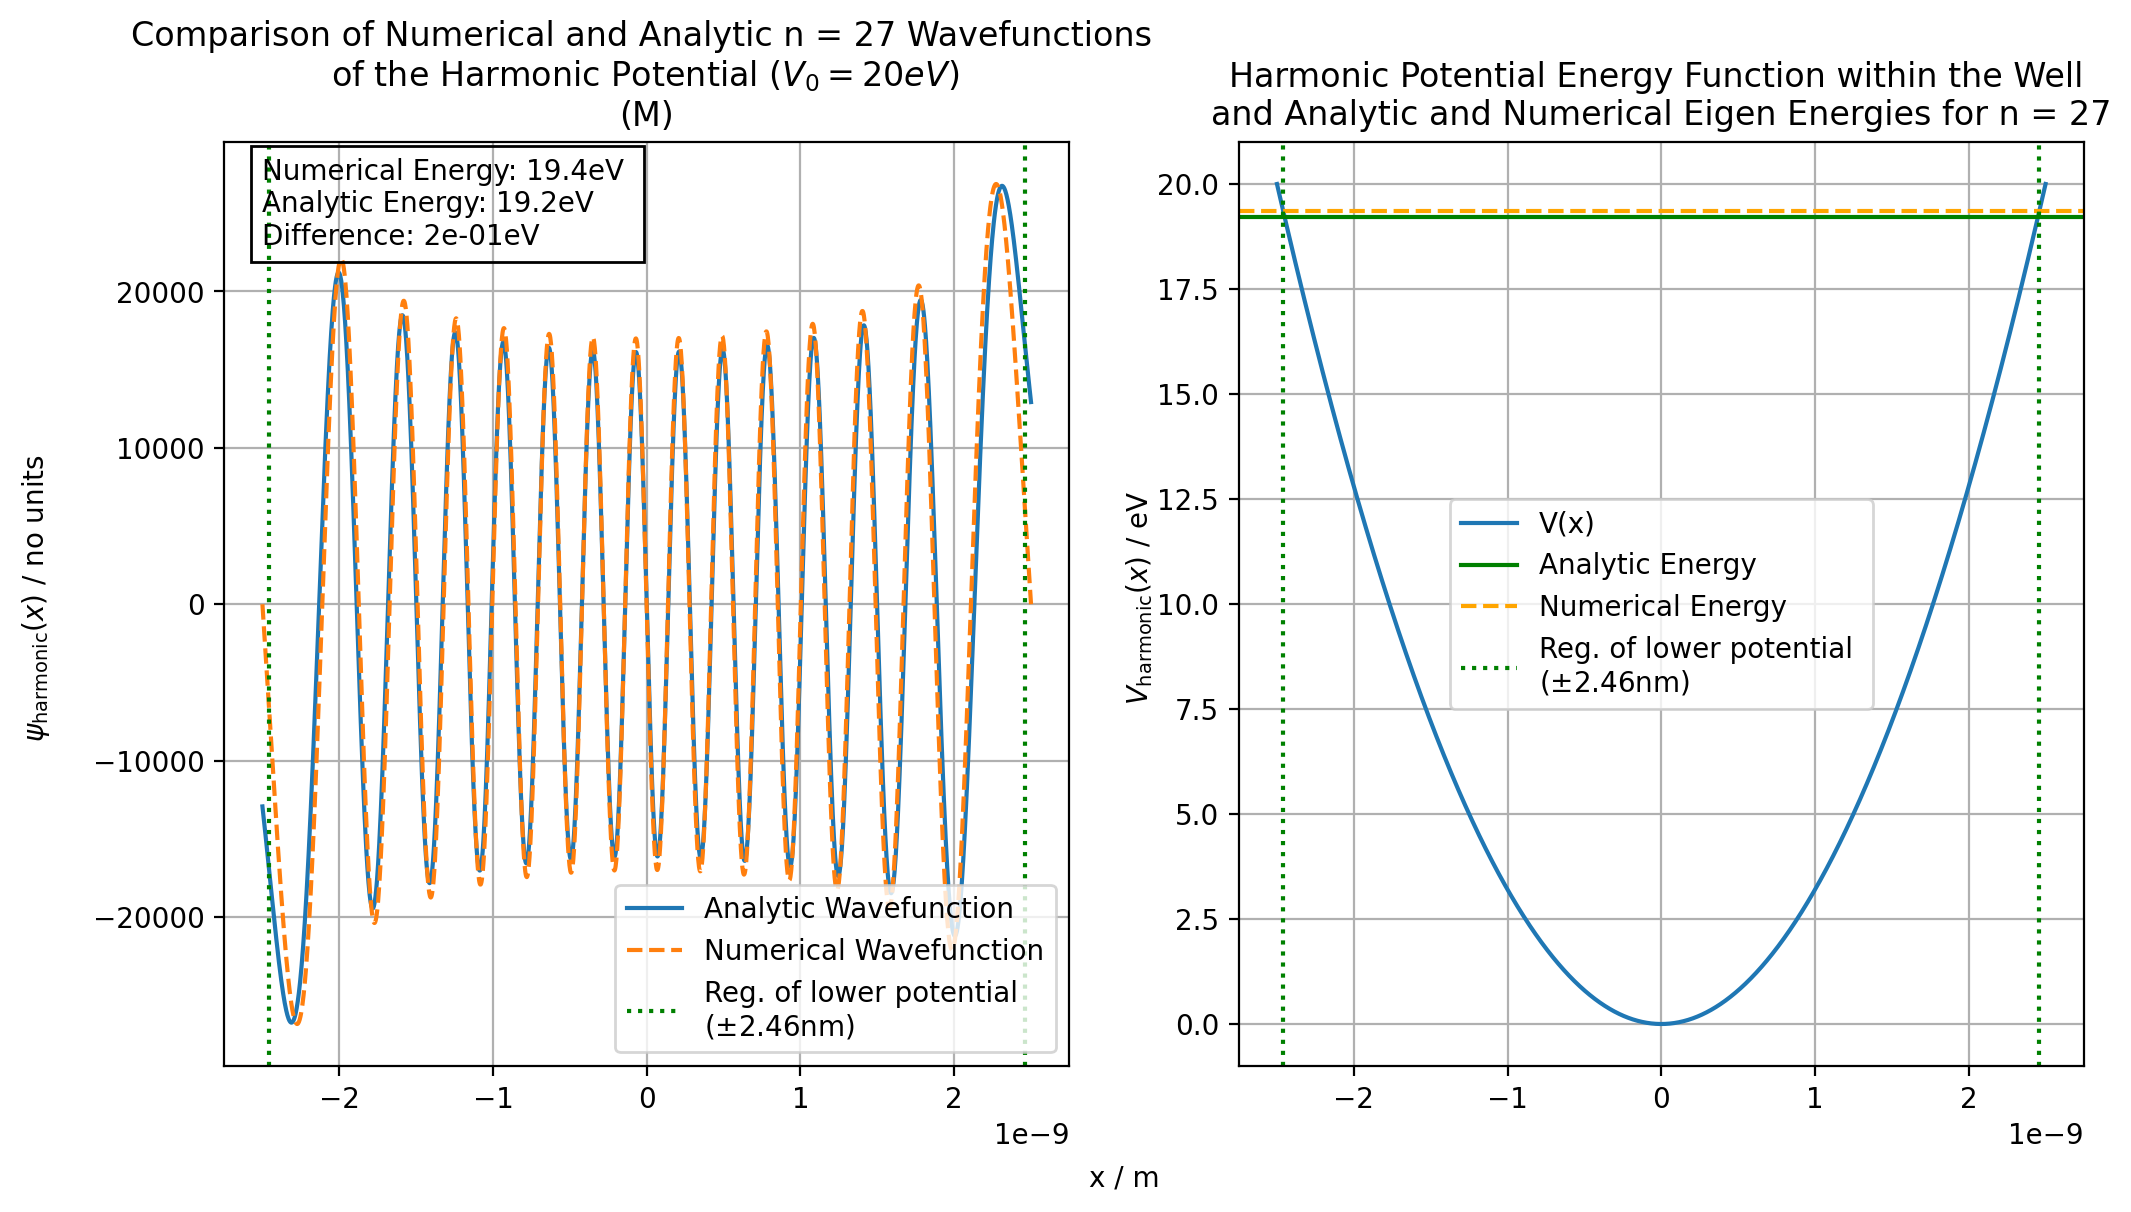

In [26]:
#n = 27 harmonic potential wavefunction calculation
E_n27_harmonic_ansatz = np.array([E_ansatz_harmonic2[27]*0.95,E_ansatz_harmonic2[27]])
E_n27_harmonic, psi_n27_harmonic = secant_method(np.array([0,-1]), xpoints, V_harmonic, f_tise, E_n27_harmonic_ansatz, e*10e-100)
psi_n27_harmonic_norm = psi_n27_harmonic[0]/np.sqrt(integrate(psi_n27_harmonic[0]**2, h))
#analytic energy for n=27
E_n27_harmonic_analytic = h_bar* (1/a) * np.sqrt(2*V0_harmonic/m_e) * (27 + 1/2)

fig, axs = plt.subplots(1,2, sharex = 'col', sharey = 'col', figsize = (12,6))
fig.text(0.5, 0.01, 'x / m', ha='center')
fig.text(0.04, 0.5, r'$\psi_{\mathrm{harmonic}} (x)$ / no units', va='center', rotation='vertical')
fig.text(0.50, 0.5, r'$V_{\mathrm{harmonic}} (x)$ / eV', va='center', rotation='vertical')


axs[0].grid()
axs[0].set_title("Comparison of Numerical and Analytic n = 27 Wavefunctions \nof the Harmonic Potential ($V_0 = 20eV$) \n(M)")
axs[0].plot(xarray, norm_const(27)*eval_hermite(27, ((2*V0_harmonic*m_e/((h_bar*a)**2))**(1/4))*xarray)*np.exp(-np.sqrt(2*V0_harmonic*m_e)*xarray**2 / (2*h_bar*a)), label = "Analytic Wavefunction")
axs[0].plot(xarray, psi_n27_harmonic_norm, "--", label = "Numerical Wavefunction")
axs[0].axvline(2.46e-9, linestyle = ":", color = "green")
axs[0].axvline(-2.46e-9, linestyle = ":", color = "green", label = "Reg. of lower potential \n($\pm$2.46nm)")
axs[0].legend(loc = "lower right")
str13 = f"Numerical Energy: {E_n27_harmonic/e:.1f}eV \nAnalytic Energy: {E_n27_harmonic_analytic/e:.1f}eV \nDifference: {(abs(E_n27_harmonic_analytic-E_n27_harmonic)/e ):.0e}eV"
axs[0].text(-2.5e-9,23000,str13, fontsize = 10, bbox=dict(facecolor='none', edgecolor="black"))

axs[1].grid()
axs[1].set_title("Harmonic Potential Energy Function within the Well \nand Analytic and Numerical Eigen Energies for n = 27")
axs[1].plot(xarray, V0_harmonic*(xarray/(a))**2 / e, label = "V(x)")
axs[1].axhline(E_n27_harmonic_analytic/e, color = "green", linestyle = '-', label = "Analytic Energy")
axs[1].axhline(E_n27_harmonic/e, color = 'orange', linestyle = '--', label = "Numerical Energy")
axs[1].axvline(2.46e-9, linestyle = ":", color = "green")
axs[1].axvline(-2.46e-9, linestyle = ":", color = "green", label = "Reg. of lower potential \n($\pm$2.46nm)")
axs[1].legend(loc = "best")

As the energy state of the electron grows, so does the difference in wavefunction behaviour of the embedded and regular case. Firstly, noticeable difference between eigen energies is seen in the corresponding potential plot on the right. Secondly, as the wavefunction of the regular harmonic potential reaches the boundaries of the well, the value of the wavefunction is still well above zero. Furthermore, the amplitude of the numerical wavefunction of the embedded potential is noticeably greater than the analytic wavefunction of the regular potential; since the probability density of the embedded case is forced to be equal to one within the well, while not so for the regular case (performing a numerical integration, a probability of ~0.9796 was obtained for the regular harmonic wavefunction, suggesting an extra ~0.02 to be accounted for outside the well), which is expected; this confinement of the electron to a finite limit also raises the energy of the electron - since in the regular case, the electron is more spread out over space, its wavelength is longer, thus leading to a lower energy in the regular case.

### Finite Square Well

Similar to the harmonic potential, a regular finite square well solution (defined in the domain $x \in [-\infty, \infty]$), and an embedded finite square solution well will be considered and compared in this section. The regular finite square well potential is given by:
$$
V_{\mathrm{fin}}(x) = \begin{cases}
0 & |x| \le \frac{d}{2} \\
V_0 & |x| > \frac{d}{2} 
\end{cases}  \dots \ \dots \ \dots \ \dots \ \dots \ \dots (19)
$$

where $d$ is the width of the well and $V_0$ is the height of the well. Thus the TISE for this potential is given by:
\begin{align*}
-\frac{\hbar^2}{2m} \frac{\mathrm{d}^2 \psi(x)}{\mathrm{d}x^2} = E\,\psi(x), \ \ x \in \left [\frac{-d}{2}, \frac{d}{2} \right ] \dots \ \dots \ \dots \ \dots \ \dots \ \dots &(20) \\
-\frac{\hbar^2}{2m} \frac{\mathrm{d}^2 \psi(x)}{\mathrm{d}x^2} + V_0\psi(x) = E\,\psi(x), \ \ |x| > \frac{d}{2} \dots \ \dots \ \dots \ \dots \ \dots \ \dots &(21)
\end{align*}

Solving for the differential equations, the general solutions are obtained:

\begin{align*}
\psi_1 (x) &= C\exp(\kappa x), \ x < -d/2 \dots \ \dots \ \dots \ \dots \ \dots \ \dots \ \dots \ \dots \ \dots  &(22) \\
\psi_2 (x) &= A\cos(kx) + B\sin(kx), \ |x| \le d/2 \dots \ \dots \ \dots \ \dots \ \dots \ \dots &(23) \\
\psi_3 (x) &= G\exp(-\kappa x), \ x>d/2 \dots \ \dots \ \dots \ \dots \ \dots \ \dots \ \dots \ \dots \ \dots  &(24)\\
k &= \sqrt{\frac{2mE}{\hbar^2}}\dots \ \dots \ \dots \ \dots \ \dots \ \dots \ \dots \ \dots \ \dots \ \dots \ \dots \ \dots \ \dots &(25) \\ 
\kappa &= \sqrt{\frac{2m(V_0 - E)}{\hbar^2}} = \sqrt{\frac{2mV_0}{\hbar^2} - \frac{2mE}{\hbar^2}} = \sqrt{k_0^2 - k^2} \dots \ \dots \ \dots   &(26)
\end{align*}

Imposing the boundary conditions that wavefunctions at the boundary should be equal, and that their first derivatives should also be equal at the boundary, the following equations are obtained:

\begin{align*}
k\tan (k\frac{d}{2}) &= \kappa = \sqrt{k_0^2 - k^2} \\ 
\implies k\frac{d}{2}\tan \left (k\frac{d}{2}\right ) &=\sqrt{\left (k_0\frac{d}{2} \right )^2 - \left (k\frac{d}{2} \right )^2}; \ B=0, C = G  \dots \ \dots \ \dots \ \dots \ \dots \ \dots &(27)\\
&\rm{and} \\
k\cot (k\frac{d}{2}) &=- \kappa = -\sqrt{k_0^2 - k^2} \\ 
\implies k\frac{d}{2}\cot \left (k\frac{d}{2}\right ) &= -\sqrt{\left (k_0\frac{d}{2} \right )^2 - \left (k\frac{d}{2} \right )^2}; \ A = 0, C = -G  \dots \ \dots \ \dots \ \dots \ \dots \ \dots &(28)
\end{align*}

For each equation, a component of the $\psi_2$ is set to zero, thus giving rise to symmetric and antisymmetric wavefunctions (solving for (27) yields symmetric wavefunctions since $B$ is set to zero, and solving for (28) yields antisymmetric wavefunctions). This may be done by solving for the roots of the following functions:

\begin{align*}
f_{\tan} \left(\frac{d}{2}k \right) &= k\frac{d}{2}\tan \left (k\frac{d}{2}\right ) - \sqrt{\left (k_0\frac{d}{2} \right )^2 - \left (k\frac{d}{2} \right )^2} = 0  \dots \ \dots \ \dots \ \dots \ \dots \ \dots &(29)\\
f_{\cot} \left(\frac{d}{2}k \right) &= k\frac{d}{2}\cot \left (k\frac{d}{2}\right ) + \sqrt{\left (k_0\frac{d}{2} \right )^2 - \left (k\frac{d}{2} \right )^2} = 0  \dots \ \dots \ \dots \ \dots \ \dots \ \dots &(30)
\end{align*}

Solving for $k\frac{d}{2}$ procures an expression for energy given by:

\begin{align*}
E = \frac{\hbar^2}{2m} \frac{\left (\frac{d}{2}k \right)^2}{(d/2)^2}  \dots \ \dots \ \dots \ \dots \ \dots \ \dots &(31)
\end{align*}

However, there are no analytic solutions to the above equations, and thus a numerical approach is required to determine the values for $\frac{d}{2}k$. This will be further discussed below.

### Embedded Finite Square Well

The embedded finite square well describes a finite well embedded within an infinite well given by:

$$
V_{\mathrm{emb. \ fin}}(x) = \begin{cases}
0 & |x| \le \frac{d}{2} \\
V_0 &  \frac{d}{2} < |x| \le L \\
\infty & L < |x| 
\end{cases} \dots \ \dots \ \dots \ \dots \ \dots \ \dots (32)
$$

Similar to the embedded harmonic potential, discrepancies between energy and wavefunction behaviour are expected. Only bound states of the electron will be considered (i.e. where the potential is greater than the electron energy). For the investigation concerning the finite well, $L = 2.5\rm{nm}$ and $d/2 = 1.25\rm{nm}$.

#### Determining Energies Numerically via $f_{\tan}$ and $f_{\cot}$

A similar approach used in the function 'energy_guess' will be employed, with slight modifications due to the discontinuous nature of the functions.

In order to determine the eigen energies for the regular finite square well with reasonable accuracy a dense enough plot will have to be considered such that the numerically solved value for energy converges to the actual solution.

In [27]:
def tan_finite(E, a):
    """Calculates the function f_tan as in eqn (29) for a range of E values specified and a 
    specified width of the finite well.
    Inputs:
        E - array of energy values
        a - half width of the finite well
    Returns the output of the function at every point in the array"""
        
    ak = (a)*np.sqrt(2*m_e*E/h_bar**2)
    ak0 = (a)*np.sqrt(2*m_e*V0_finite/h_bar**2)
    return ak*np.tan(ak) - np.sqrt(ak0**2 - ak**2)

def cotan_finite(E, a):
    """Calculates the function f_cot as in eqn (30) for a range of E values specified and a 
    specified width of the finite well.
    Inputs:g
        E - array of energy values
        a - half width of the finite well
    Returns the output of the function at every point in the array"""
    ak = (a)*np.sqrt(2*m_e*E/h_bar**2)
    ak0 = (a)*np.sqrt(2*m_e*V0_finite/h_bar**2)
    return ak*(1/np.tan(ak)) + np.sqrt(ak0**2 - ak**2)

#Check the energy space 0 to 10eV, which is the height of the finite well for 10000 points.
E_array = np.linspace(e*0.001,  10*e, N*10)
#we set the width of the well to be from -d/4 to d/4, where we defined the variable d = 2.5nm
f_tan = tan_finite(E_array, d/4)
f_cotan = cotan_finite(E_array, d/4)

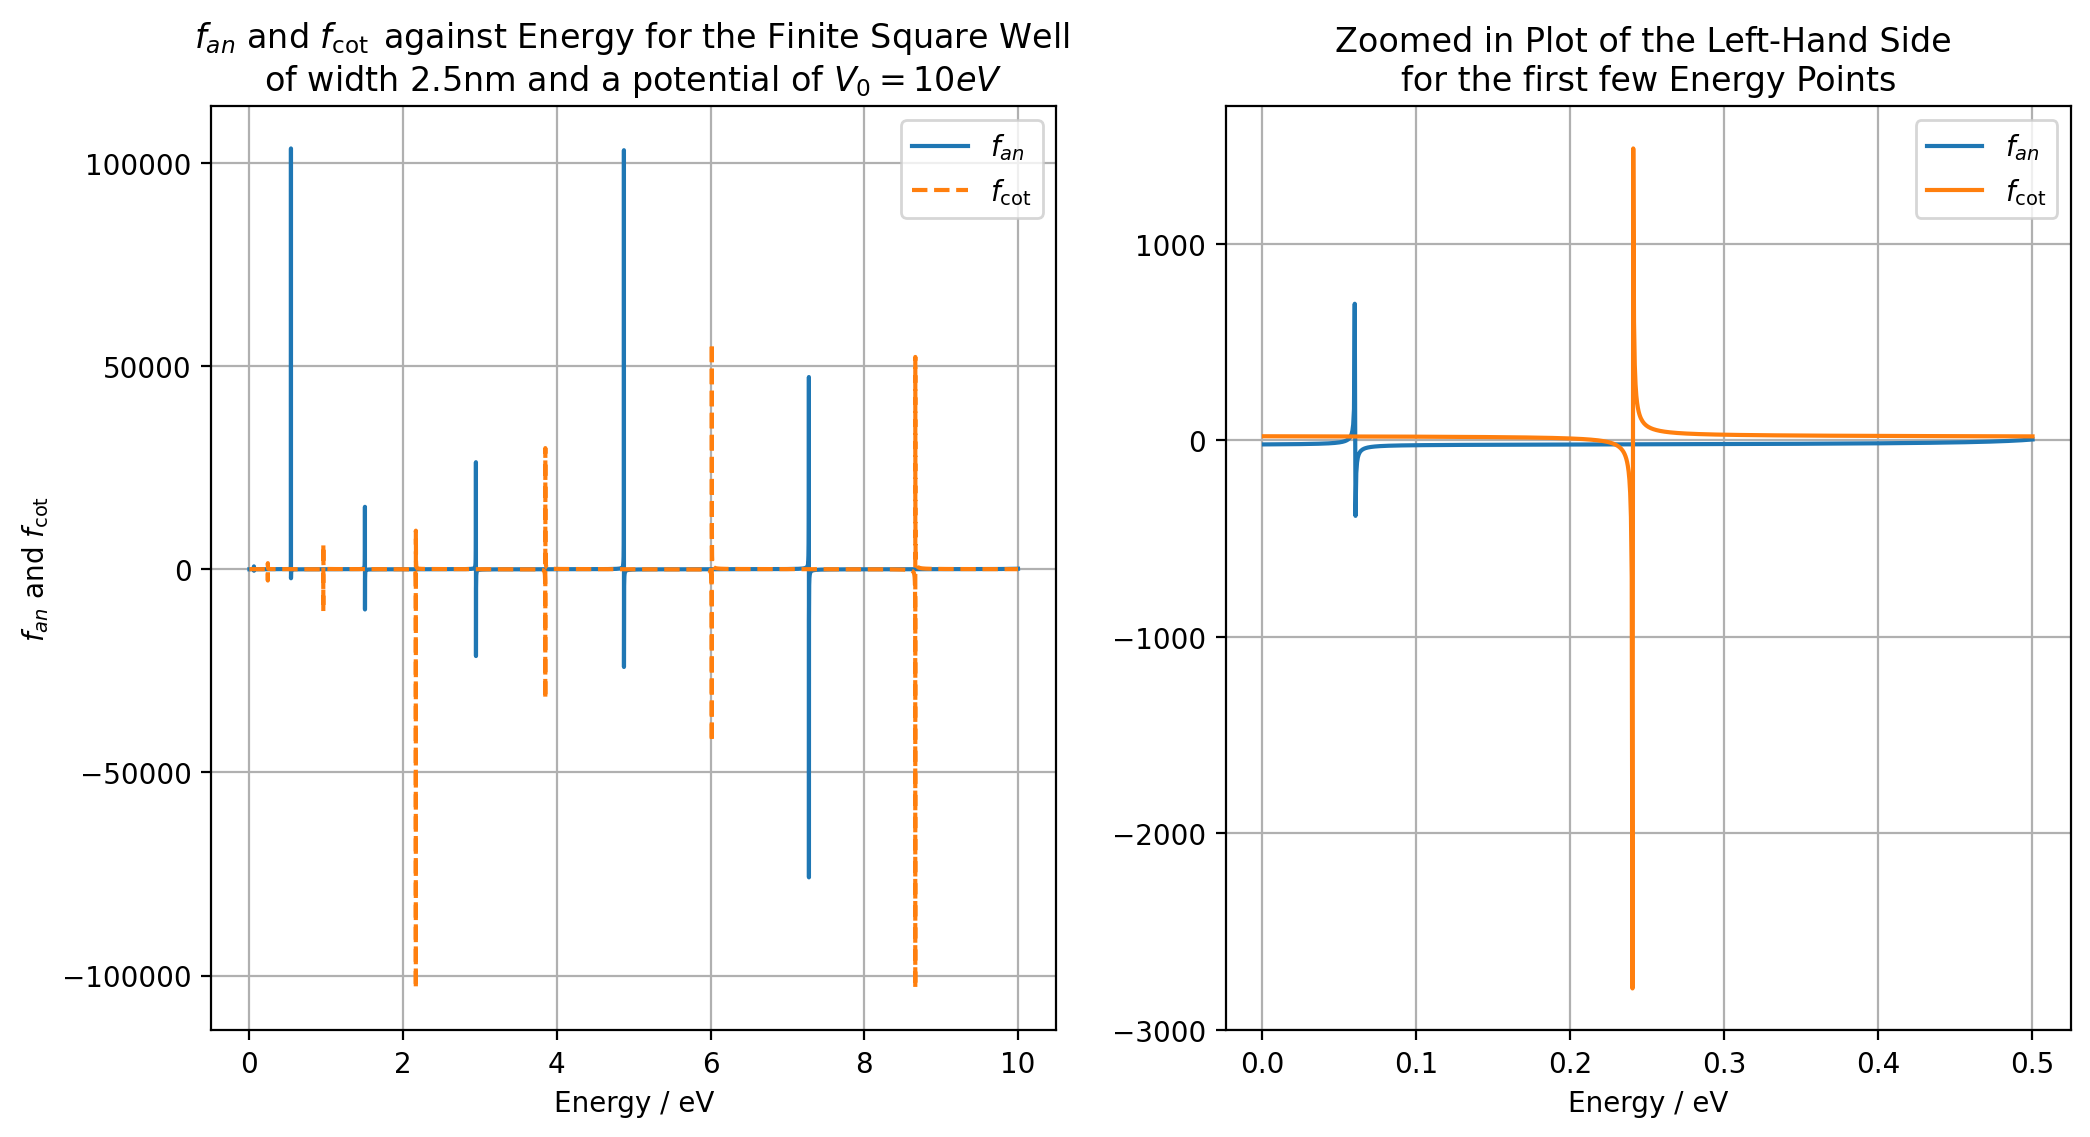

In [28]:
#plotting the functions against E;
#the intersections with the x-axis yield the eigen energy point
fig, axs = plt.subplots(1,2, figsize = (12,6))
axs[0].grid()
axs[0].plot(E_array/e, f_tan, label = "$f_{\tan}$")
axs[0].plot(E_array/e, f_cotan, '--', label = "$f_{\cot}$")
axs[0].set_xlabel("Energy / eV")
axs[0].set_ylabel("$f_{\tan}$ and $f_{\cot}$")
axs[0].set_title("$f_{\tan}$ and $f_{\cot}$ against Energy for the Finite Square Well \nof width 2.5nm and a potential of $V_0 = 10eV$")
axs[0].legend(loc = "best")

axs[1].grid()
axs[1].plot(E_array[:-19000]/e, f_tan[:-19000], label = "$f_{\tan}$")
axs[1].plot(E_array[:-19000]/e, f_cotan[:-19000], label = "$f_{\cot}$")
axs[1].set_xlabel("Energy / eV")
axs[1].set_title("Zoomed in Plot of the Left-Hand Side \nfor the first few Energy Points")
axs[1].legend(loc = "best")

Plotting $f_{\rm{tan}}$ and  $f_{\rm{cot}}$ as a function of energy allows complete comprehension of how the function behaves regarding discontinuities and roots. The discontinuities in the plot result in a sign change, and thus, due to the nature of the method employed, will return the energies close to the discontinuities although they are not eigen energies.

To combat this issue, a new function is defined which excludes these discontinuities, and only accounts for smooth transitions above and below the x-axis. A key observation is that the y values near discontinuities are extremely large (reaching a few hundred to a few thousand to a few hundred thousand); furthermore the points near the x-axis are near zero, as seen in the graph on the right hand side. Thus, this knowledge may be implemented to extract only the root energies and not the discontinuities.

In [29]:
def energy_guess_finite_well(Earray, f, a):
    """A function to return guessed eigen energies for a specified energy range, designed specifically for
    the finite well, where discontinuities are present.
    
    Inputs:
        Earray - array of energy values to look through
        f - either the tangent or cotangent function 
        a - the half-width of the finite well
        
    Outputs a list of eigen energy guesses."""
    
    #evaluate the energy array at every point
    ypoints = f(Earray, a)
    #create a list to store guesses
    eigen_energy_guesses = []
    #perform the same technique of checking for a change of sign between points
    for i in range(len(ypoints)-1):
        tempvar1 = np.sign(ypoints[i])
        tempvar2 = np.sign(ypoints[i+1])
        
        #if there is a change of sign, check the condition that the ypoint is not more than 50
        #to confirm if it is a discontinuity or not
        if int(abs(tempvar2 + tempvar1)) == 0: 
            if abs(ypoints[i]) > 50:
                continue
            else:
                eigen_energy_guesses.append(Earray[i+1])
                
    return np.array(eigen_energy_guesses)

In [30]:
#Obtaining numerically obtained eigen energies for the symmetric and anti symmetric functions
symmetric_eigen_E = energy_guess_finite_well(E_array, tan_finite, d/4)
antisymmetric_eigen_E = energy_guess_finite_well(E_array, cotan_finite, d/4)
print(f"Eigen energies for the symmetric finite well functions:\n{symmetric_eigen_E/e}eV")
print("\n")
print(f"Eigen energies for the antisymmetric finite well functions:\n{antisymmetric_eigen_E/e}eV")

Eigen energies for the symmetric finite well functions:
[0.0549973  0.49147547 1.3629319  2.66486679 4.38728066 6.51067448
 8.96755163]eV


Eigen energies for the antisymmetric finite well functions:
[0.21848912 0.8729564  1.96040202 3.47432632 5.40072999 7.70711466]eV


#### Analytic Normalisation Constants for $\psi_1, \ \psi_2, \ \psi_3$

Once the energies have been determined numerically, normalisation constants for the regular finite square well may be determined analytically, by considering the normalisation condition (for the symmetric cases where $B=0$ and $C = G$ first):

\begin{align*}
\int_{-\infty}^{-a} |\psi_1|^2 dx + \  \int_{-a}^{a}  |\psi_2|^2 dx + \ \int_{a}^{\infty}  |\psi_3|^2 dx = 1 \dots \ \dots \ \dots \ \dots \ \dots \ \dots &(33)\\
C^2\int_{-\infty}^{-a} e^{2\kappa x} dx + \  A^2\int_{-a}^{a} \cos^2(kx) dx + \ C^2\int_{a}^{\infty} e^{-2\kappa x} dx = 1 \dots \ \dots \ \dots \ \dots \ \dots \ \dots &(34)
\end{align*}

Where $a = d/2$ which is the half-width of the finite well (in this case $d/2 = 1.25$nm). Simplifying this expression, the equation is obtained:

\begin{align*}
\frac{C^2}{\kappa} e^{-2\kappa a } + A^2 \left ( \frac{1}{2k}\sin(2ka) + a\right) = 1 \dots \ \dots \ \dots \ \dots \ \dots \ \dots (35)
\end{align*}

Furthermore, evauating the condition that $\psi_1 (-a) = \psi_2 (-a)$:

\begin{align*}
A\cos(ka) = Ce^{-\kappa a} \dots \ \dots \ \dots \ \dots \ \dots \ \dots &(36) \\
\implies C= \frac{A\cos(ka)}{e^{-\kappa a}} \dots \ \dots \ \dots \ \dots \ \dots \ \dots &(37)
\end{align*}

Substituting this expression for $C$ back into the previous equation:

\begin{align*}
A = \sqrt{\frac{1}{\frac{\cos^2(ka)}{\kappa} + \frac{1}{2k} \sin(2ka) + a}} \dots \ \dots \ \dots \ \dots \ \dots \ \dots &(38) \\
C = \sqrt{\frac{1}{\frac{\cos^2(ka)}{\kappa} + \frac{1}{2k} \sin(2ka) + a}} \cos(ka)e^{\kappa a} \dots \ \dots \ \dots \ \dots \ \dots \ \dots &(39)
\end{align*}

Thus, for a known $ka$ value, $A$ and $C$ may be determined. The same logic may be extended for when $A = 0$, and $B$ is non-zero to obtain:

\begin{align*}
B = \sqrt{\frac{1}{\frac{\sin^2(ka)}{\kappa} - \frac{1}{2k} \sin(2ka) + a}}\dots \ \dots \ \dots \ \dots \ \dots \ \dots &(40) \\
C'= -\sqrt{\frac{1}{\frac{\sin^2(ka)}{\kappa} - \frac{1}{2k} \sin(2ka) + a}} \sin(ka)e^{\kappa a} \dots \ \dots \ \dots \ \dots \ \dots \ \dots &(41)
\end{align*}

In [31]:
#defining functions to calculate the normalisation constants for a specific eigen energy
def norm_const_psi2_symmetric(E, a):
    """Returns the normalisation constant for psi_2 in the symmetric case via equation (38).
    Takes an eigen energy E as an input, and the half-width of the well, a.
    Outputs the normalisation constant, A."""
    k = np.sqrt(2*m_e*E/h_bar**2)
    k0 = np.sqrt(2*m_e*V0_finite/h_bar**2)
    kappa = np.sqrt(k0**2 - k**2)
    A = np.sqrt(1/( (np.cos(a*k)**2)/kappa + (1/(2*k))*np.sin(2*k*a) + a) )
    return A

def norm_const_psi1_symmetric(E, a):
    """Returns the normalisation constant for psi_1 in the symmetric case via equation (39).
    Takes an eigen energy E as an input, and the half-width of the well, a.
    Outputs the normalisation constant, C."""
    k = np.sqrt(2*m_e*E/h_bar**2)
    k0 = np.sqrt(2*m_e*V0_finite/h_bar**2)
    kappa = np.sqrt(k0**2 - k**2)
    C = np.sqrt(1/( (np.cos(a*k)**2)/kappa + (1/(2*k))*np.sin(2*k*a) + a) ) * np.cos(k*a) * np.exp(kappa*a)
    return C
    
def norm_const_psi2_antisymmetric(E, a):
    """Returns the normalisation constant for psi_2 in the antisymmetric case via equation (40).
    Takes an eigen energy E as an input, and the half-width of the well, a.
    Outputs the normalisation constant, B."""
    k = np.sqrt(2*m_e*E/h_bar**2)
    k0 = np.sqrt(2*m_e*V0_finite/h_bar**2)
    kappa = np.sqrt(k0**2 - k**2)
    B = np.sqrt(1/( (np.sin(a*k)**2)/kappa - (1/(2*k))*np.sin(2*k*a) + a) )
    return B

def norm_const_psi1_antisymmetric(E, a):
    """Returns the normalisation constant for psi_1 in the antisymmetric case via equation (41).
    Takes an eigen energy E as an input, and the half-width of the well, a.
    Outputs the normalisation constant, C'."""
    k = np.sqrt(2*m_e*E/h_bar**2)
    k0 = np.sqrt(2*m_e*V0_finite/h_bar**2)
    kappa = np.sqrt(k0**2 - k**2)
    C = np.sqrt(1/( (np.sin(a*k)**2)/kappa - (1/(2*k))*np.sin(2*k*a) + a) ) * np.sin(k*a) * np.exp(kappa*a)
    return C


def norm_consts_finite_symm(E, a):
    """Returns the two normalisation constants for an eigen energy input and the half width of the well
    for the symmetric case."""
    
    #return const for psi_1 then psi_2
    return norm_const_psi1_symmetric(E, a), norm_const_psi2_symmetric(E, a)

def norm_consts_finite_antisymm(E, a):
    """Returns the two normalisation constants for an eigen energy input and the half width of the well
    for the antisymmetric case."""
    
    #return const for psi_1 then psi_2
    return norm_const_psi1_antisymmetric(E, a), norm_const_psi2_antisymmetric(E, a)

In [32]:
def finite_well_symmetric_wavefn(xpoints_reg_1, xpoints_reg_2, xpoints_reg_3, E, a):
    """Function calculates the full normalised wavefunction for the regular finite square well
    in the symmetric case (when B = 0, A != 0 as described in equation (27)).
    Inputs:
        xpoints_reg_1 - array of x points corresponding to the domain of psi_1 (eqn (22))
        xpoints_reg_2 - array of x points corresponding to the domain of psi_2 (eqn (23))
        xpoints_reg_3 - array of x points corresponding to the domain of psi_3 (eqn (24))
        E - Eigen energy
        a - half width of the finite well
    Outputs the fully normalised array of wavefunction values ready to plot and the full x region over which
    the wavefunction is evaluated on."""
    
    #calculate k and k0 and kappa
    k = np.sqrt(2*m_e*E/h_bar**2)
    k0 = np.sqrt(2*m_e*V0_finite/h_bar**2)
    kappa = np.sqrt(k0**2 - k**2)
    
    #calculate the normalisation constants for the symm. case
    C, A = norm_consts_finite_symm(E,a)
    
    #multiply normalisation constants by the corresponding functions in each region
    psi_1 = C*np.exp(kappa*xpoints_reg_1)
    psi_2 = A*np.cos(k*xpoints_reg_2)
    psi_3 = C*np.exp(-kappa*xpoints_reg_3)
    
    #concatenate the full wave function and x regions
    psi_full_norm = np.concatenate((psi_1, psi_2, psi_3))
    x_region_full = np.concatenate((xpoints_reg_1, xpoints_reg_2, xpoints_reg_3))
    
    return psi_full_norm, x_region_full

def finite_well_antisymmetric_wavefn(xpoints_reg_1, xpoints_reg_2, xpoints_reg_3, E, a):
    """Function calculates the full normalised wavefunction for the regular finite square well
    in the antisymmetric case (when A = 0, B != 0, as described in eqn(28)).
    Inputs:
        xpoints_reg_1 - array of x points corresponding to the domain of psi_1
        xpoints_reg_2 - array of x points corresponding to the domain of psi_2
        xpoints_reg_3 - array of x points corresponding to the domain of psi_3
        E - Eigen energy
        a - half width of the finite well
    Outputs the fully normalised array of wavefunction values ready to plot and the full x region over which
    the wavefunction is evaluated on."""
    
    #calculate k and k0 and kappa
    k = np.sqrt(2*m_e*E/h_bar**2)
    k0 = np.sqrt(2*m_e*V0_finite/h_bar**2)
    kappa = np.sqrt(k0**2 - k**2)
    
    #calculate the normalisation constants for the antisymm. case
    C, A = norm_consts_finite_antisymm(E,a)
    
    #multiply normalisation constants by the corresponding functions in each region
    psi_1 = -C*np.exp(kappa*xpoints_reg_1)
    psi_2 = A*np.sin(k*xpoints_reg_2)
    psi_3 = C*np.exp(-kappa*xpoints_reg_3)
    
    #concatenate the full wave function and x regions
    psi_full_norm = np.concatenate((psi_1, psi_2, psi_3), axis = None)
    x_region_full = np.concatenate((xpoints_reg_1, xpoints_reg_2, xpoints_reg_3), axis = None)
    
    return psi_full_norm, x_region_full

#### Plots of Low Excited States of the Embedded Finite Square Well

In [33]:
xpoints1 = np.arange(-d/2, -d/4, h) # domain with V0_finite as the potential
xpoints2 = np.arange(-d/4, d/4+h, h) # domain with 0 potential
xpoints3 = np.arange(d/4+h, d/2 + h, h) # domain with V0_finite as the potential

#calculating gnd state analytically normalised wavefunction
psi_gnd_finite_analytic, x_full = finite_well_symmetric_wavefn(xpoints1, xpoints2, xpoints3,symmetric_eigen_E[0], d/4)

#calculating the first excited state, which is the first energy in the antisymmetric eigen energy array
psi_n2_finite_analytic = finite_well_antisymmetric_wavefn(xpoints1, xpoints2, xpoints3, antisymmetric_eigen_E[0], d/4)[0]

#calculating 3rd excited state, which is the 2nd energy in the symmetric eigen energy array
psi_n3_finite_analytic = finite_well_symmetric_wavefn(xpoints1, xpoints2, xpoints3,symmetric_eigen_E[1], d/4)[0]

#calculating the first excited state, which is the first energy in the antisymmetric eigen energy array
psi_n4_finite_analytic = finite_well_antisymmetric_wavefn(xpoints1, xpoints2, xpoints3, antisymmetric_eigen_E[1], d/4)[0]

<Figure size 1200x700 with 0 Axes>

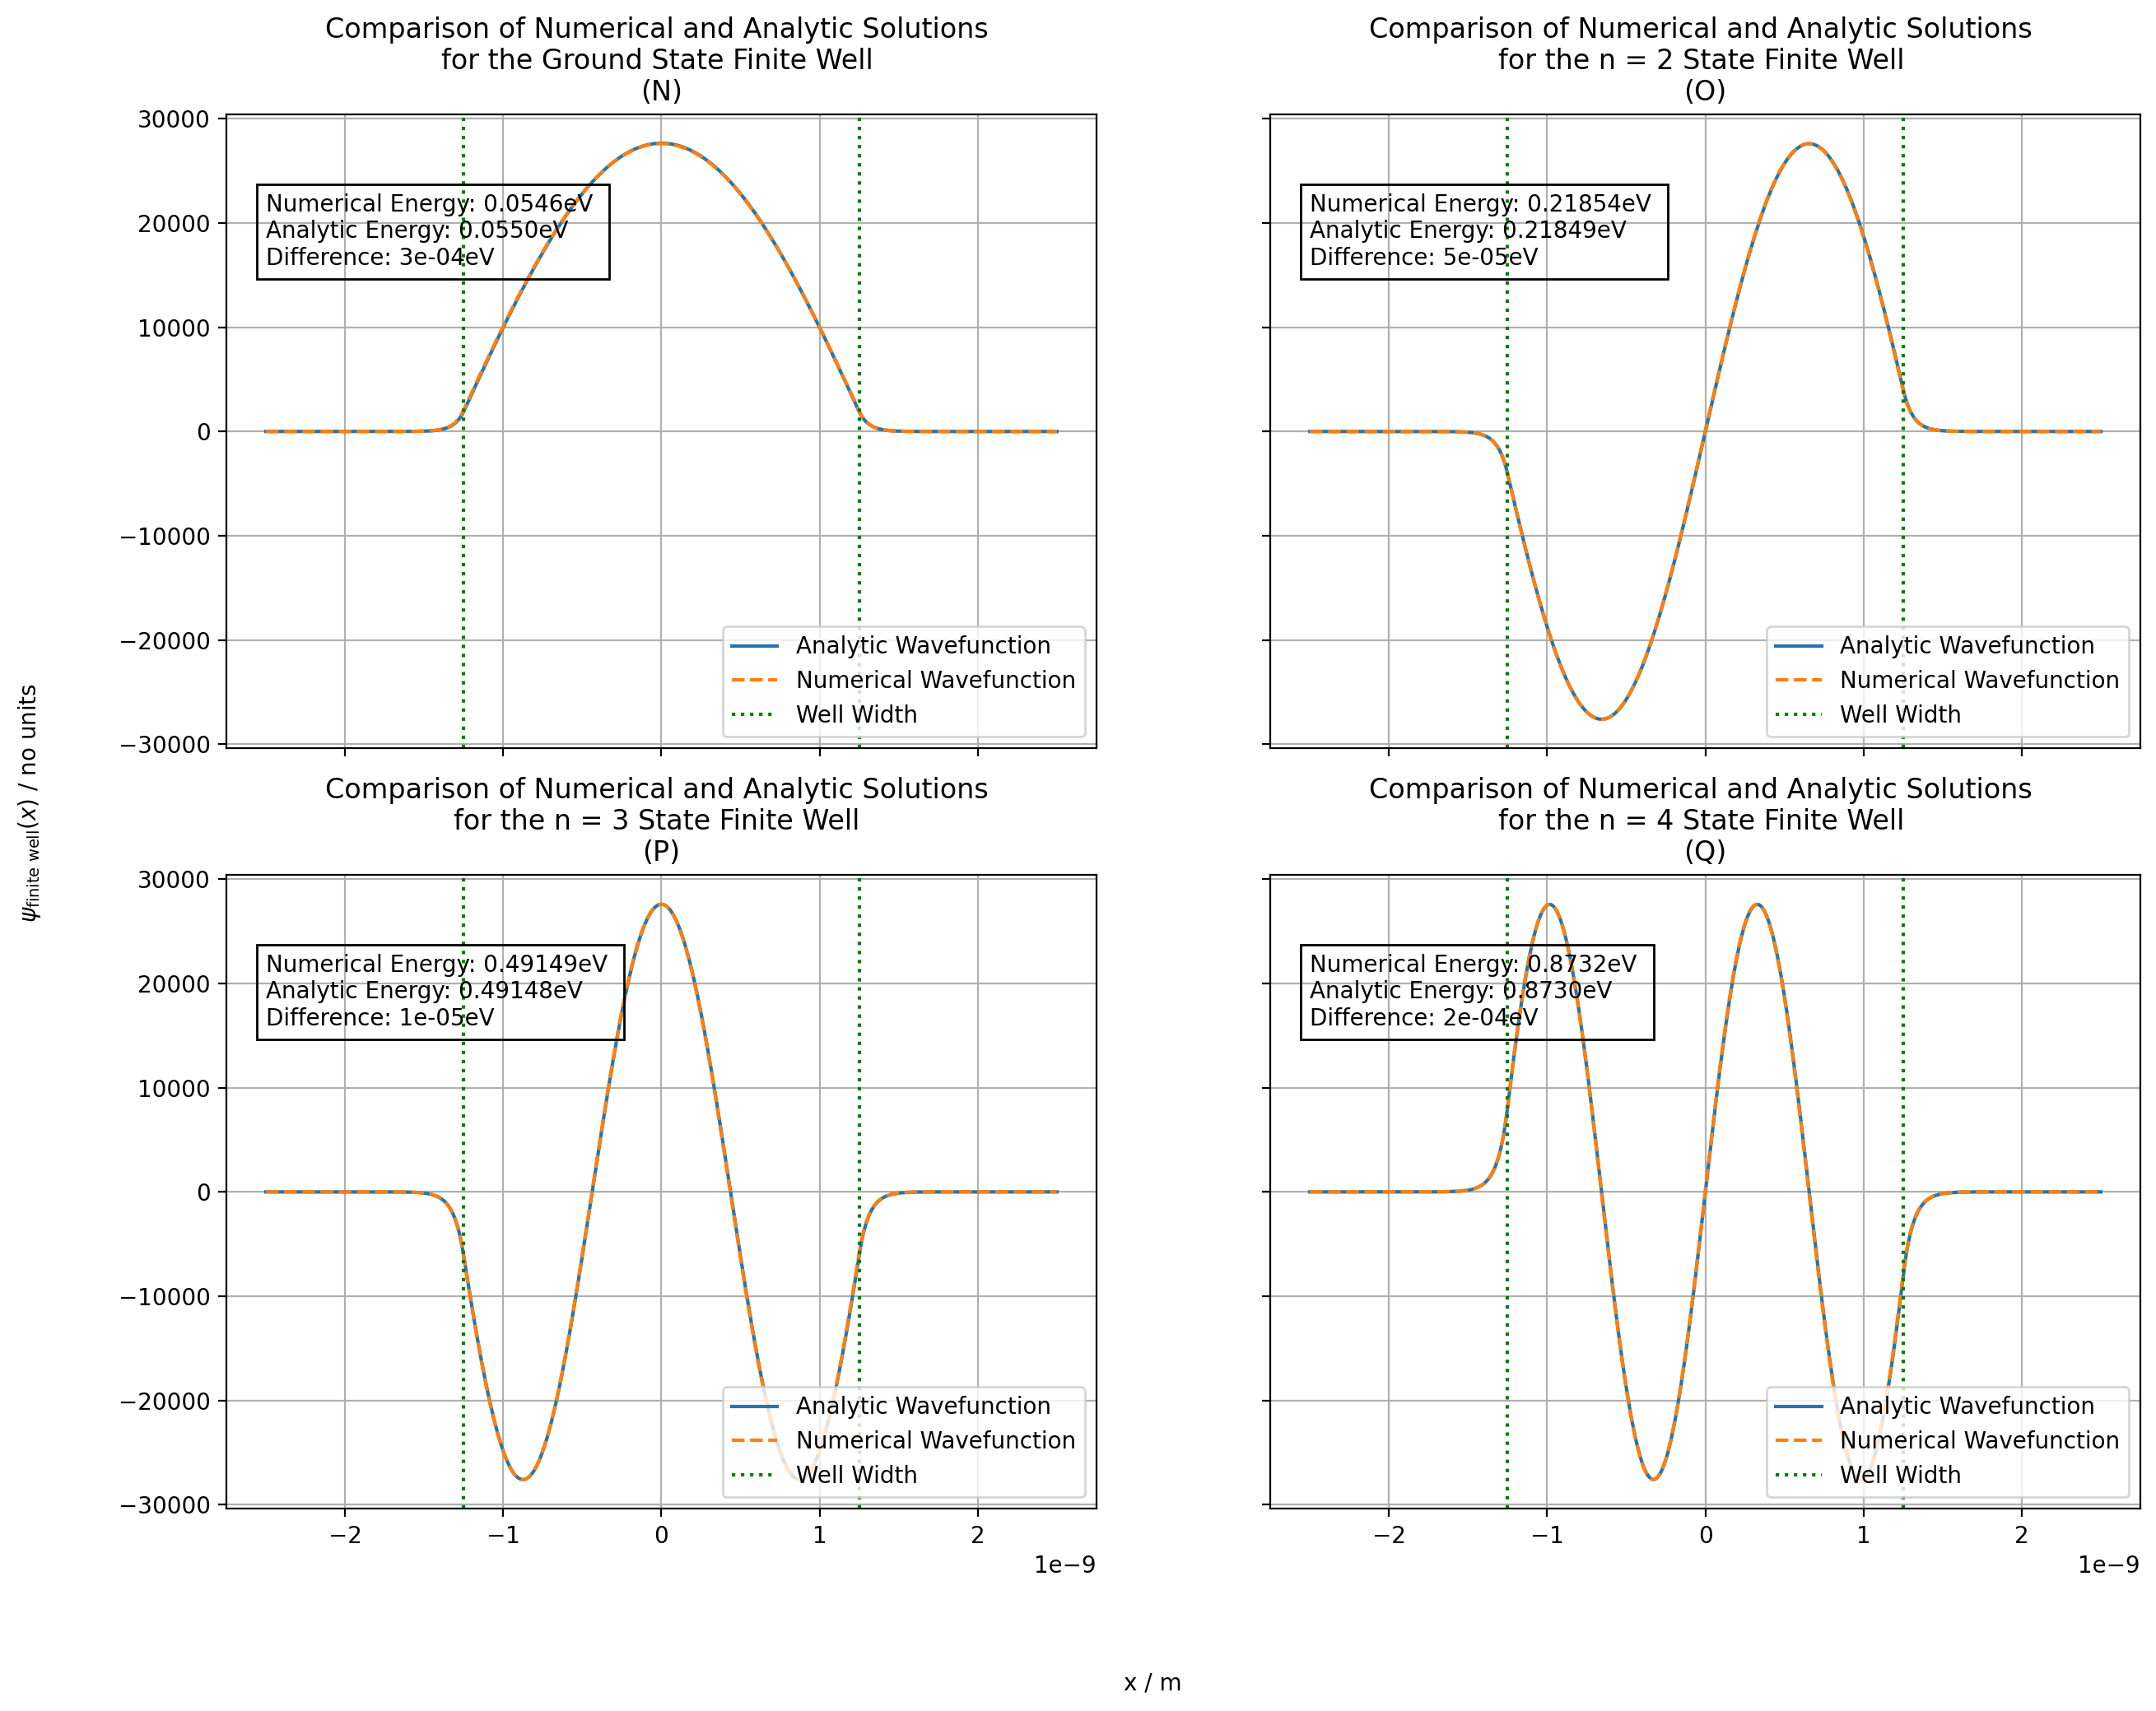

In [34]:
#numerical gnd state calculation for the embedded finite potential
#using the numerically obtained energies of the regular finite well as guess energies
E_gnd_finite_ansatz = np.array([0.9*symmetric_eigen_E[0],symmetric_eigen_E[0]])
E_gnd_finite, psi_gnd_finite = secant_method(np.array([0,1]), xpoints, V_finite, f_tise, E_gnd_finite_ansatz, e*10e-100)
psi_gnd_finite_norm = psi_gnd_finite[0] * 1/np.sqrt(integrate(psi_gnd_finite[0]**2, h))

#numerical n=2 state calculation for the embedded finite potential
E_n2_finite_ansatz = np.array([0.9*antisymmetric_eigen_E[0],antisymmetric_eigen_E[0]])
E_n2_finite, psi_n2_finite = secant_method(np.array([0,-1]), xpoints, V_finite, f_tise, E_n2_finite_ansatz, e*10e-100)
psi_n2_finite_norm = psi_n2_finite[0] * 1/np.sqrt(integrate(psi_n2_finite[0]**2, h))

#numerical n=3 state calculation for the embedded finite potential
E_n3_finite_ansatz = np.array([0.9*symmetric_eigen_E[1],symmetric_eigen_E[1]])
E_n3_finite, psi_n3_finite = secant_method(np.array([0,-1]), xpoints, V_finite, f_tise, E_n3_finite_ansatz, e*10e-100)
psi_n3_finite_norm = psi_n3_finite[0] * 1/np.sqrt(integrate(psi_n3_finite[0]**2, h))

#numerical n=4 state calculation for the embedded finite potential
E_n4_finite_ansatz = np.array([0.9*antisymmetric_eigen_E[1],antisymmetric_eigen_E[1]])
E_n4_finite, psi_n4_finite = secant_method(np.array([0,1]), xpoints, V_finite, f_tise, E_n4_finite_ansatz, e*10e-100)
psi_n4_finite_norm = psi_n4_finite[0] * 1/np.sqrt(integrate(psi_n4_finite[0]**2, h))


#setting up plots
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
fig, axs = plt.subplots(2,2, sharex = True, sharey = True, figsize = (15,11))
fig.text(0.5, 0.01, 'x / m', ha='center')
fig.text(0.04, 0.5, r'$\psi_{\mathrm{finite \ well}} (x)$ / no units', va='center', rotation='vertical')

for i in range(2):
    for j in range(2):
        axs[i,j].grid()
        
axs[0,0].set_title("Comparison of Numerical and Analytic Solutions \nfor the Ground State Finite Well \n(N)")
axs[0,1].set_title("Comparison of Numerical and Analytic Solutions \nfor the n = 2 State Finite Well \n(O)")
axs[1,0].set_title("Comparison of Numerical and Analytic Solutions \nfor the n = 3 State Finite Well \n(P)")
axs[1,1].set_title("Comparison of Numerical and Analytic Solutions \nfor the n = 4 State Finite Well \n(Q)")

#plotting wavefunctions
axs[0,0].plot(x_full, psi_gnd_finite_analytic, label = "Analytic Wavefunction")
axs[0,0].plot(xarray, psi_gnd_finite_norm, "--", label = "Numerical Wavefunction")
str14 = f"Numerical Energy: {E_gnd_finite/e:.4f}eV \nAnalytic Energy: {symmetric_eigen_E[0]/e:.4f}eV \nDifference: {(abs(symmetric_eigen_E[0]-E_gnd_finite)/e ):.0e}eV"
axs[0,0].text(-2.5e-9,16000,str14, fontsize = 10, bbox=dict(facecolor='none', edgecolor="black"))
axs[0,0].axvline(d/4, color = 'green', linestyle = ':', label = "Well Width")
axs[0,0].axvline(-d/4, color = 'green', linestyle = ':')
axs[0,0].legend(loc = "lower right")

axs[0,1].plot(x_full, psi_n2_finite_analytic, label = "Analytic Wavefunction")
axs[0,1].plot(xarray, psi_n2_finite_norm, "--", label = "Numerical Wavefunction")
str15 = f"Numerical Energy: {E_n2_finite/e:.5f}eV \nAnalytic Energy: {antisymmetric_eigen_E[0]/e:.5f}eV \nDifference: {(abs(antisymmetric_eigen_E[0]-E_n2_finite)/e ):.0e}eV"
axs[0,1].text(-2.5e-9,16000,str15, fontsize = 10, bbox=dict(facecolor='none', edgecolor="black"))
axs[0,1].axvline(d/4, color = 'green', linestyle = ':', label = "Well Width")
axs[0,1].axvline(-d/4, color = 'green', linestyle = ':')
axs[0,1].legend(loc = "lower right")

axs[1,0].plot(x_full, psi_n3_finite_analytic, label = "Analytic Wavefunction")
axs[1,0].plot(xarray, psi_n3_finite_norm, "--", label = "Numerical Wavefunction")
str16 = f"Numerical Energy: {E_n3_finite/e:.5f}eV \nAnalytic Energy: {symmetric_eigen_E[1]/e:.5f}eV \nDifference: {(abs(symmetric_eigen_E[1]-E_n3_finite)/e ):.0e}eV"
axs[1,0].text(-2.5e-9,16000,str16, fontsize = 10, bbox=dict(facecolor='none', edgecolor="black"))
axs[1,0].axvline(d/4, color = 'green', linestyle = ':', label = "Well Width")
axs[1,0].axvline(-d/4, color = 'green', linestyle = ':')
axs[1,0].legend(loc = "lower right")

axs[1,1].plot(x_full, psi_n4_finite_analytic, label = "Analytic Wavefunction")
axs[1,1].plot(xarray, psi_n4_finite_norm, "--", label = "Numerical Wavefunction")
str17 = f"Numerical Energy: {E_n4_finite/e:.4f}eV \nAnalytic Energy: {antisymmetric_eigen_E[1]/e:.4f}eV \nDifference: {(abs(antisymmetric_eigen_E[1]-E_n4_finite)/e ):.0e}eV"
axs[1,1].text(-2.5e-9,16000,str17, fontsize = 10, bbox=dict(facecolor='none', edgecolor="black"))
axs[1,1].axvline(d/4, color = 'green', linestyle = ':', label = "Well Width")
axs[1,1].axvline(-d/4, color = 'green', linestyle = ':')
axs[1,1].legend(loc = "lower right")

In the above plots, the region -1.25nm to 1.25nm has zero potential, and a potential of 10eV for $\pm$ 1.25nm to $\pm$ 2.5nm. Beyond $\pm$ 2.5nm, the potential is infinite. For similar reasons previously discussed in Figure $\textbf{(M)}$, the embedded case has a higher energy than the regular non-embedded case due to the particle being more spread out in space for the non-embedded case, and thus possessing a greater wavelength.

However, most of the regular finite wavefunction is concentrated in the zero potential region of the well, and thus the embedded well is a good approximation to the regular finite well for low excited states (similar to the embedded harmonic potential).

#### Higher Excited States of the Finite Square Well

The finite potential well has a finite number of bound states (where the energy of the electron is lower than the energy of the potential well, $V_0$). The final excited state will be considered, and discrepancies between the embedded and regular cases will be discussed.

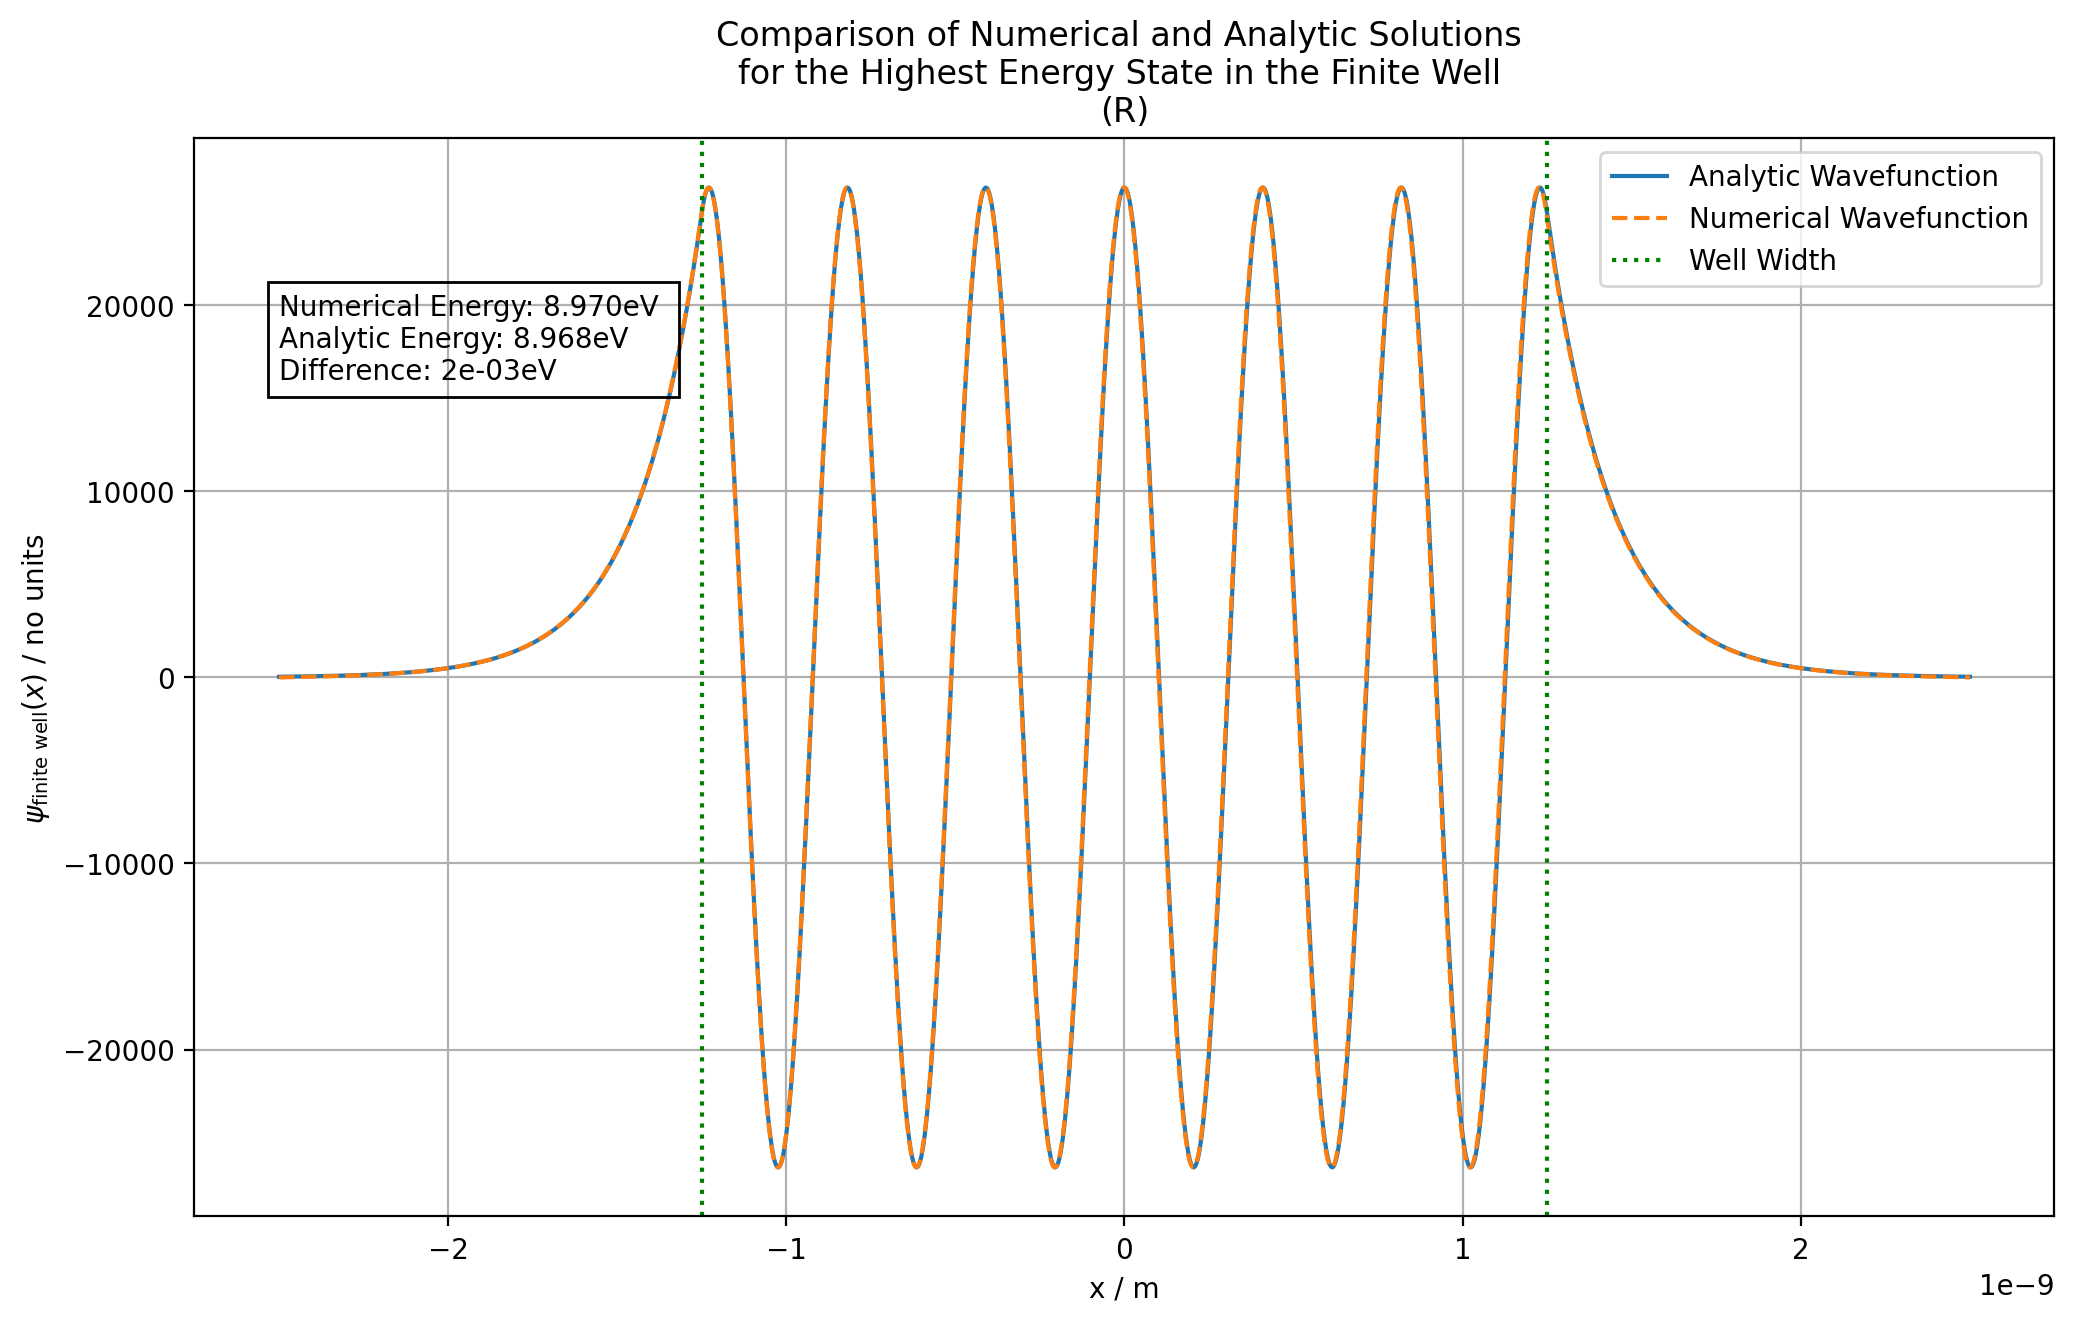

In [35]:
#numerical highest excited state calculation for the embedded finite potential
E_final_finite_ansatz = np.array([0.9*symmetric_eigen_E[-1],symmetric_eigen_E[-1]])
E_final_finite, psi_final_finite = secant_method(np.array([0,1]), xpoints, V_finite, f_tise, E_final_finite_ansatz, e*10e-100)
psi_final_finite_norm = psi_final_finite[0] * 1/np.sqrt(integrate(psi_final_finite[0]**2, h))

#calculating the highest excited state analytically, which is the last energy in the symmetric eigen energy array
psi_final_finite_analytic = finite_well_symmetric_wavefn(xpoints1, xpoints2, xpoints3,symmetric_eigen_E[-1], d/4)[0]

plt.grid()
plt.plot(x_full, psi_final_finite_analytic, label = "Analytic Wavefunction")
plt.plot(xarray, psi_final_finite_norm, '--', label = "Numerical Wavefunction")
plt.xlabel("x / m")
plt.ylabel("$\psi_{\mathrm{finite \ well}} (x)$ / no units")
plt.title("Comparison of Numerical and Analytic Solutions \nfor the Highest Energy State in the Finite Well \n(R)")
str18 = f"Numerical Energy: {E_final_finite/e:.3f}eV \nAnalytic Energy: {symmetric_eigen_E[-1]/e:.3f}eV \nDifference: {(abs(symmetric_eigen_E[-1]-E_final_finite)/e ):.0e}eV"
plt.text(-2.5e-9,16000,str18, fontsize = 10, bbox=dict(facecolor='none', edgecolor="black"))
plt.axvline(d/4, color = 'green', linestyle = ':', label = "Well Width")
plt.axvline(-d/4, color = 'green', linestyle = ':')
plt.legend(loc = "best")

No significant discrepancy was observed in the plot of the highest bound excited state. Performing a numerical integration on the analytic wavefunction in the bounds of $\pm 2.5$nm yielded a value of ~0.99999972, indicating most of the wavefunction was present in the well.

In this investigation, a relatively narrow finite well was considered (full width of 2.5nm). This allowed the analytic wavefunction to decay before reaching the infinite well boundaries. Should a wider finite well be considered, more of the analytic wavefunction would probably be present outside the infinite well boundaries, resulting in a larger discrepancy between energies, and wavefunction amplitude.

Thus, for a narrow finite well width, the embedded finite well approximates the actual finite well quite closely for all bound excited states.

## Embedded Double Well Potential

The final potential under consideration is the embedded double well potential given by (Jelic & Marsiglio, 2012):

\begin{align*}
V(x) = \begin{cases}
V_0 \left( 4\frac{x^2}{a^2} + 4 \frac{x}{a} +1 \right) & -a < x \le 0  \\
V_0 \left( 4\frac{x^2}{a^2} - 4 \frac{x}{a} +1 \right) & 0 < x < a \\
\infty & |x| > a
\end{cases} \dots \ \dots \ \dots \ \dots \ \dots \ \dots (42)
\end{align*}

where $a$ is the half-width of the well, $V_0$ determines the maximum potential in the well (the potential is symmetric about $x=0$). In the function the half-width of the well considered is 2.5nm. The double well potential is of particular importance in model quantum tunneling effects (e.g. in nuclear decay), and in molecules such as ammonia, where the molecule undergoes what is known as an inversion, which may be modelled as a tunneling problem (Yang & Han, 2021). 

In [36]:
#defining a new potential function
V0_double_well = 10*e
#defining a new finite well potential
def V_double_well(x):
    """Double well potential function.
    Takes a single value, x (float) (within the well boundaries) and returns the corresponding value at the point."""
    if x <= 0:
        return V0_double_well*(4*(x/(d/2))**2 + 4*(x/(d/2)) + 1)
    else:
        return V0_double_well*(4*(x/(d/2))**2 - 4*(x/(d/2)) + 1)

def V_double_well_plot(xarray):
    """Double well potential specifically for returning an array to plot.
    Takes an array of x values, and returns the corresponding defined potential in the region.
    Outputs an array of corresponding potential values"""
    #list to store the potential evaluated at each x value
    V_array = []
    for x in xarray:
        V_array.append(V_double_well(x))
    
    return np.array(V_array)

#### Guessing Energies for the Double Potential Well

It was noted that - via plotting the final point of the wavefunction as a function of energy - the eigen energies were minima of the final point of the wavefunction; as such, the method of detecting a root through a sign change would not work in this case. Rather, another function would need to be defined to scan through for minima numerically throughout the energy space. A minima would be such that its neighbouring points would be larger than itself. So, this may be implemented via a function.

In [37]:
def find_minima(x_array, y_array):
    """Finds the minimum points for a specified array of y points, and returns the
    x points at which the minima occurs.
    Inputs:
        x_array - array of x points
        y_array - array of corresponding y values"""
    
    #list to store x points which give a min
    minimum_pts = []
    #scan through whole array of y pts, if y[i] is lower than its neighbouring pts,
    #append x[i] to the list
    for i in range(len(y_array)-1):
        if i == 0:
            continue
        if y_array[i] < y_array[i-1] and y_array[i] < y_array[i+1]:
            minimum_pts.append(x_array[i])
    
    return np.array(minimum_pts)

In [38]:
#Give the roots of the double well potential if the values cross the x-axis
#also return the final points of psi as a function of energy to find the minima
#do this for the range 0 to 10eV, which is the max energy of the double well.
psi_full_double_well = energy_guess([0,1], xpoints, f_tise, V_double_well, np.linspace(0.001*e, 10*e, 200))[1]
E_ansatz_double_well = find_minima(np.linspace(0.001*e, 10*e, 200), psi_full_double_well)
print(f"The eigen energy guesses for the double well in the range 0 to 10eV: \n{E_ansatz_double_well/e}eV")

The eigen energy guesses for the double well in the range 0 to 10eV: 
[0.50346231 1.50838693 2.46306533 3.46798995 4.42266834 5.42759296
 6.43251759 7.43744221 8.44236683 9.49753769]eV


Text(0.5, 1.0, '$\\psi{final}$ as a function of energy for the double well potential over 10eV')

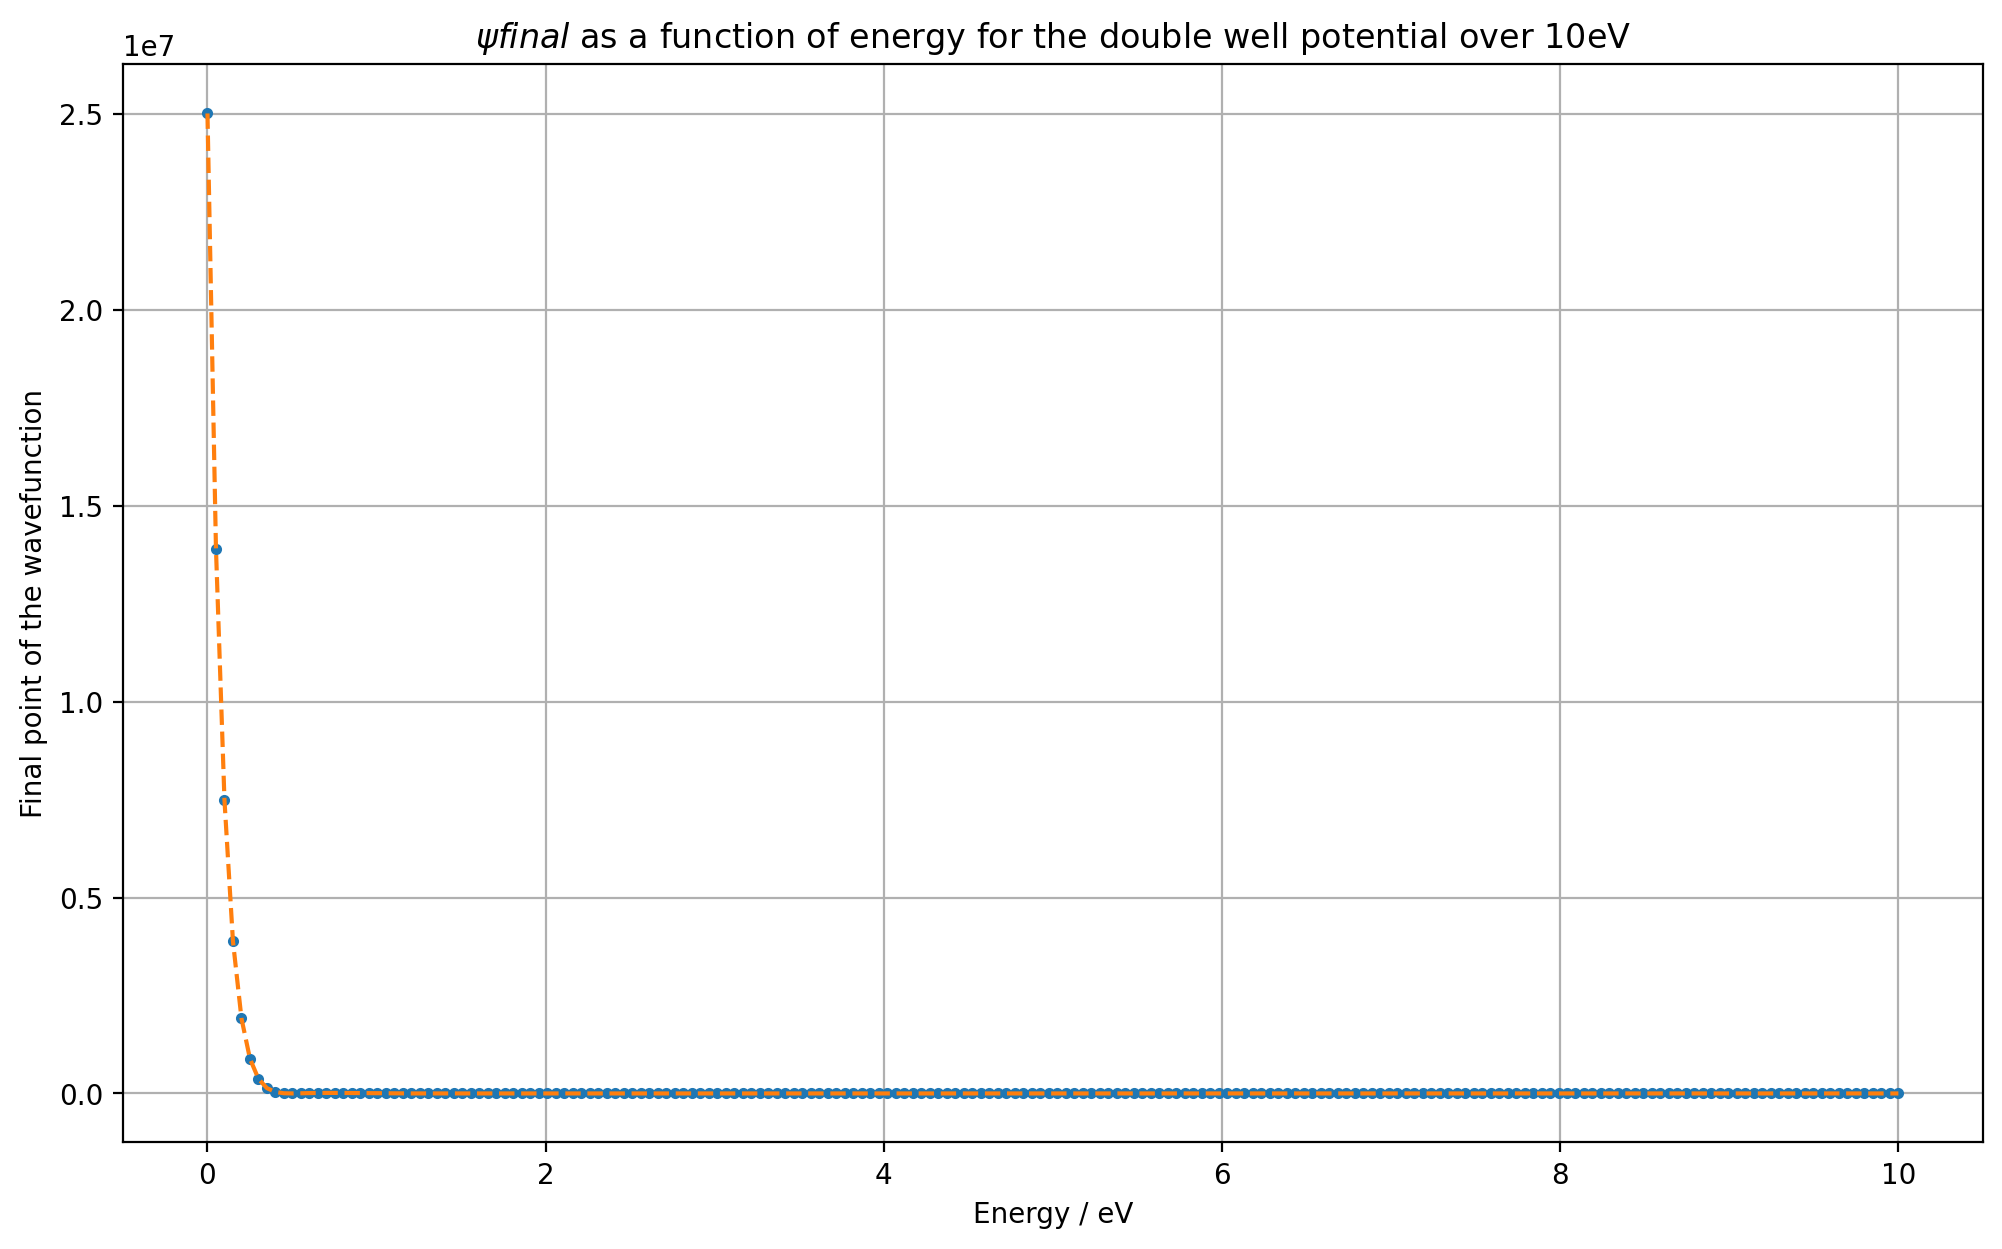

In [39]:
#plot the final psi points
plt.plot(np.linspace(0.001*e, 10*e, 200)/e, psi_full_double_well, '.')
plt.plot(np.linspace(0.001*e, 10*e, 200)/e, psi_full_double_well, '--')
plt.grid()
plt.xlabel("Energy / eV")
plt.ylabel("Final point of the wavefunction")
plt.title("$\psi{final}$ as a function of energy for the double well potential over 10eV")

In applying the 'energy_guess' function to this plot, it was found that the points of the function never crossed the x-axis, and hence no sign change was recorded. Thus, the method would not procure eigen energy guesses. Instead, another method was devised: finding all the minima present in the discrete set of points as defined in the 'find_minima' function.

<Figure size 1200x700 with 0 Axes>

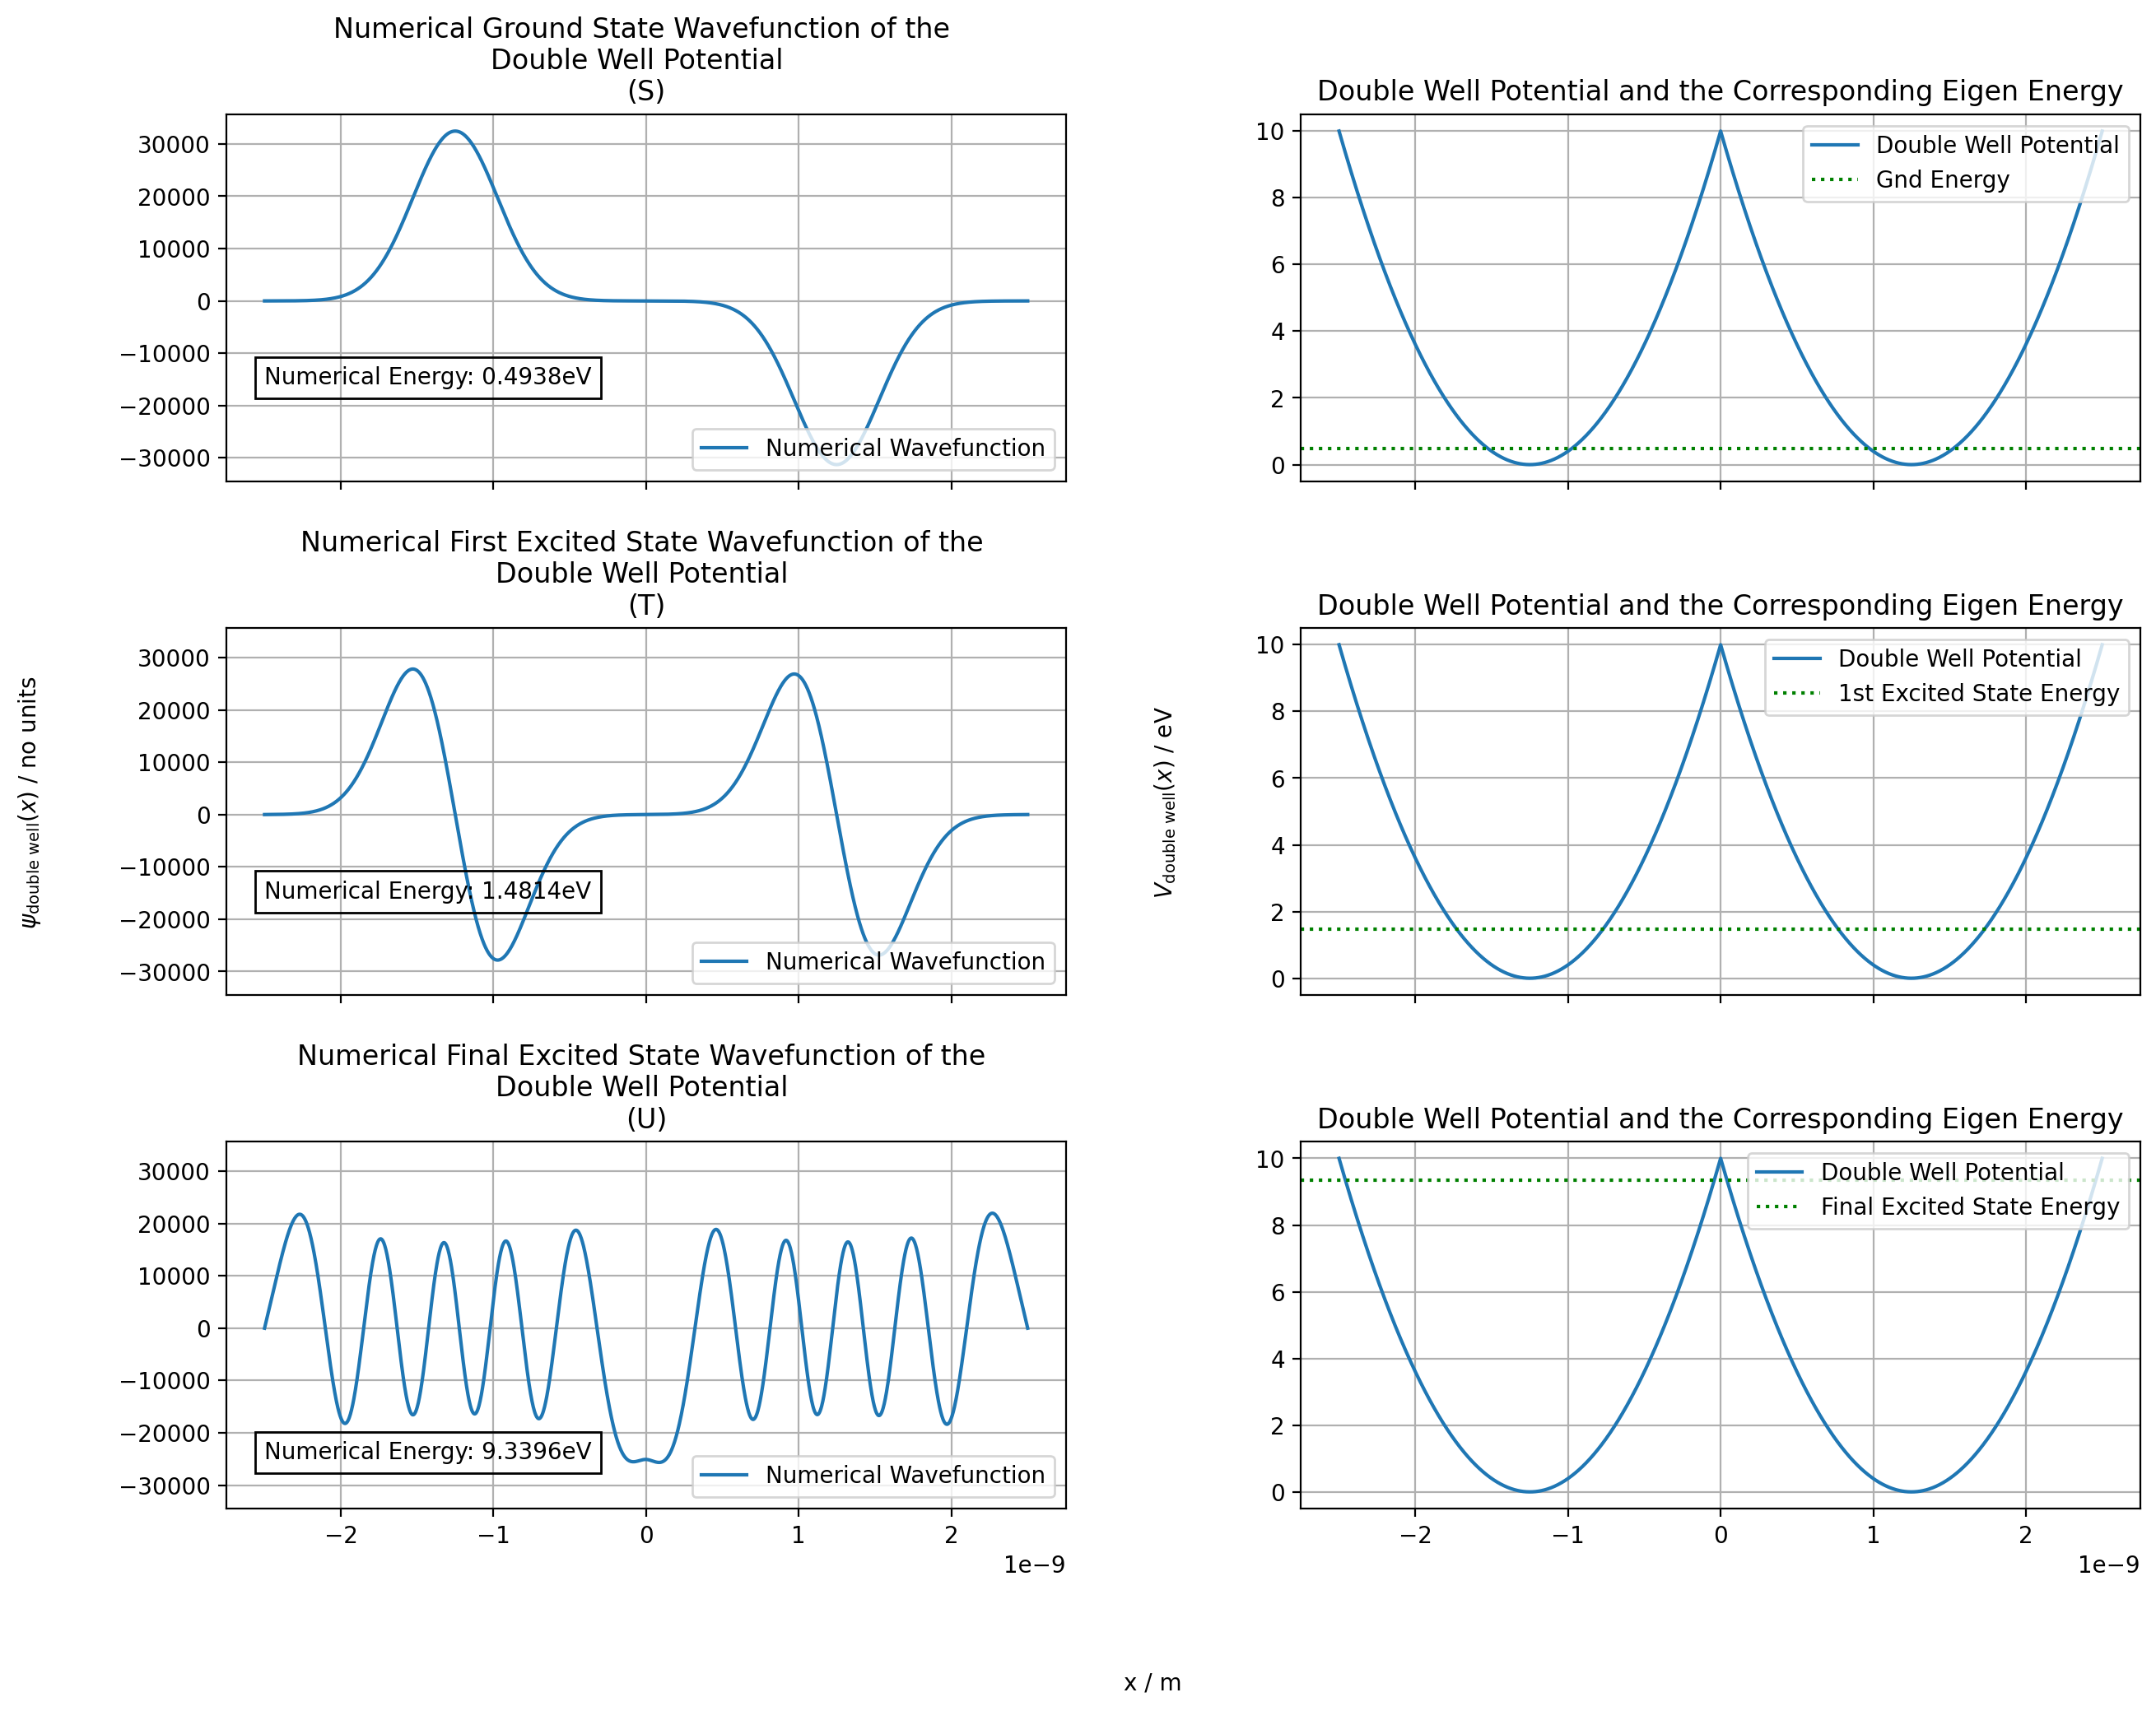

In [40]:
#calculating the ground state wavefunction of the double well
E_gnd_doublewell_ansatz = np.array([0.9*E_ansatz_double_well[0],E_ansatz_double_well[0]])
E_gnd_doublewell, psi_gnd_doublewell = secant_method(np.array([0,1]), xpoints, V_double_well, f_tise, E_gnd_doublewell_ansatz, e*10e-100)
psi_gnd_doublewell_norm = psi_gnd_doublewell[0] * 1/np.sqrt(integrate(psi_gnd_doublewell[0]**2, h))

#calculating the first excited state wavefunction of the double well
E_n2_doublewell_ansatz = np.array([0.9*E_ansatz_double_well[1],E_ansatz_double_well[1]])
E_n2_doublewell, psi_n2_doublewell = secant_method(np.array([0,1]), xpoints, V_double_well, f_tise, E_n2_doublewell_ansatz, e*10e-100)
psi_n2_doublewell_norm = psi_n2_doublewell[0] * 1/np.sqrt(integrate(psi_n2_doublewell[0]**2, h))

#calculating the final excited state wavefunction of the double well
E_final_doublewell_ansatz = np.array([0.9*E_ansatz_double_well[-1],E_ansatz_double_well[-1]])
E_final_doublewell, psi_final_doublewell = secant_method(np.array([0,1]), xpoints, V_double_well, f_tise, E_final_doublewell_ansatz, e*10e-100)
psi_final_doublewell_norm = psi_final_doublewell[0] * 1/np.sqrt(integrate(psi_final_doublewell[0]**2, h))


#setting up plots
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
fig, axs = plt.subplots(3,2, sharex = True, sharey = 'col', figsize = (15,11))
fig.text(0.5, 0.01, 'x / m', ha='center')
fig.text(0.04, 0.5, r'$\psi_{\mathrm{double \ well}} (x)$ / no units', va='center', rotation='vertical')
fig.text(0.50, 0.5, r'$V_{\mathrm{double \ well}} (x)$ / eV', va='center', rotation='vertical')
fig.subplots_adjust(wspace=0.28, hspace=0.40)

for i in range(3):
    for j in range(2):
        axs[i,j].grid()
        
axs[0,0].set_title("Numerical Ground State Wavefunction of the \nDouble Well Potential  \n(S)")
axs[0,1].set_title("Double Well Potential and the Corresponding Eigen Energy")
axs[1,0].set_title("Numerical First Excited State Wavefunction of the \nDouble Well Potential \n(T)")
axs[1,1].set_title("Double Well Potential and the Corresponding Eigen Energy")
axs[2,0].set_title("Numerical Final Excited State Wavefunction of the \nDouble Well Potential \n(U)")
axs[2,1].set_title("Double Well Potential and the Corresponding Eigen Energy")

#plotting wavefunctions
axs[0,0].plot(xarray, psi_gnd_doublewell_norm, label = "Numerical Wavefunction")
str19 = f"Numerical Energy: {E_gnd_doublewell/e:.4f}eV"
axs[0,0].text(-2.5e-9,-16000,str19, fontsize = 10, bbox=dict(facecolor='none', edgecolor="black"))
axs[0,0].legend(loc = "lower right")

axs[0,1].plot(xarray, V_double_well_plot(xarray)/e, label = "Double Well Potential")
axs[0,1].axhline(E_gnd_doublewell/e, color = 'green', linestyle = ':', label = "Gnd Energy")
axs[0,1].legend(loc = "best")

axs[1,0].plot(xarray, psi_n2_doublewell_norm, label = "Numerical Wavefunction")
str20 = f"Numerical Energy: {E_n2_doublewell/e:.4f}eV"
axs[1,0].text(-2.5e-9,-16000,str20, fontsize = 10, bbox=dict(facecolor='none', edgecolor="black"))
axs[1,0].legend(loc = "lower right")

axs[1,1].plot(xarray, V_double_well_plot(xarray)/e, label = "Double Well Potential")
axs[1,1].axhline(E_n2_doublewell/e, color = 'green', linestyle = ':', label = "1st Excited State Energy")
axs[1,1].legend(loc = "best")

axs[2,0].plot(xarray, psi_final_doublewell_norm, label = "Numerical Wavefunction")
str21 = f"Numerical Energy: {E_final_doublewell/e:.4f}eV"
axs[2,0].text(-2.5e-9,-25000,str21, fontsize = 10, bbox=dict(facecolor='none', edgecolor="black"))
axs[2,0].legend(loc = "lower right")

axs[2,1].plot(xarray, V_double_well_plot(xarray)/e, label = "Double Well Potential")
axs[2,1].axhline(E_final_doublewell/e, color = 'green', linestyle = ':', label = "Final Excited State Energy")
axs[2,1].legend(loc = "best")

In the lower energy states, displayed in $\textbf{(S)}$ and $\textbf{(T)}$, nodes are present at $x = 0$, where the potential is a maximum, and the energy state of the electron is much lower than the potential; it is also noted that the wavefunction decays quickly in the regions where the potential is greater than the energy of the electron. However, with a higher energy state, as shown in $\textbf{(U)}$, the particle has a non-zero wavefunction in the areas of greater potential. Furthermore, the wavefunction does not decay significantly in these regions of greater potential, thus indicating a greater probability of the electron tunneling through the potential barrier. 

The minima of the double potential could represent some equilibrium positions of some particle/molecule; in moving from equilibrium state to another equilibrium state, some potential needs to be overcome. However, the particle need not posses an energy greater than the barrier, and can instead tunnel through the barrier even with a lower energy than the barrier. As mentioned previously, this could be used to model ammonia molecules, where its pyramidal structure gets inverted.

## Conclusion

The infinite square well was used to model a quantum dot with an electron confined within. A total of four potential functions was embedded within the infinite well - the zero potential, harmonic potential, finite square potential, and the double well potential were solved for numerically via the Shooting Method and analytically (where possible). A method was devised (which varies depending on the potential considered) to procure eigen energy guesses to  be passed as input in the Secant Method to ensure convergence to the desired eigen state. Using this method, low lying excited states and higher excited bound states were considered in all cases, and compared to their analytic solutions (where possible); discrepancies between the analytic and numerical solutions were explored and discussed.

First backtesting our numerical results with the zero potential function, it was found that our numerical method was reliable and could be applied to non-trivial cases. The harmonic potential yielded that low lying excited states could be approximated very well with the embedded harmonic potential, only displaying significant deviation in highly excited states.

Furthermore, in the embedded finite well, choosing a relatively narrow finite well width ensured that most of the wavefunction of the analytic solution remained in the infinite well boundaries. Thus, the numerical embedded finite well solution did not deviate too far from the analytic case, even in highly excited states. This meant that for a narrow finite well width, the numerical solution could approximate the analytic case for most energy states.

Lastly, the Shooting Method was applied to the embedded double well potential. The behaviour of the numerical wavefunction at low lying energy levels and the highest excited state was considered, and potential applications were discussed.

Thus, the embedded cases of the regular potentials aptly approximated the regular potentials for low lying excited states, and in some cases, even highly excited states.

### Further Work

In extensions of this investigation, other numerical methods could be explored; the variational method utilising the Variational Principle could be considered in numerically solving wavefunctions (Tiernan8r, 2020). Furthermore, extensions of the same potentials to two or three dimensions could be considered for a more realistic model.

### References

Griffiths, D. & Schroeter, D. (2001) Introduction to Quantum Mechanics. 3rd edition. Cambridge University Press. doi:10.1017/9781316995433. 



Jelic, V. & Marsiglio, F. (2012) The double well potential in quantum mechanics: a simple, numerically exact formulation. European Journal of Physics. 33 (6). doi:10.1088/0143-0807/33/6/1651. 



Li, M., Li, R., Wu, L., Lin, X., Xia, X., Ao, Z., Sun, X., Chen, X. & Chen, S. (2024) Ultrabright and stable top-emitting quantum-dot light-emitting diodes with negligible angular color shift. Nature Communications. 15 (1). doi:10.1038/s41467-024-49574-6. 



McMillan, J., Batrakova, E. & Gendelman, H.E. (2011) Cell Delivery of Therapeutic Nanoparticles. Progress in Molecular Biology and Translational Science. 104, 563–601. doi:10.1016/B978-0-12-416020-0.00014-0. 



Newman, M.E.J.. (2013) Computational physics. Michigan. 


Rae, A.I.M.. & Napolitano, Jim. (2016) Quantum mechanics. 6th edition. CRC Press 



Tiernan8r (2020) Computational Physics-The Variational Principle. https://github.com/Tiernan8r/variational_principle/blob/master/report.pdf. 



Yang, C.D. & Han, S.Y. (2021) Tunneling quantum dynamics in ammonia. International Journal of Molecular Sciences. 22 (15). doi:10.3390/ijms22158282. 